In [46]:
import random
import numpy as np

In [78]:
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

    def displayAnswer(self,value):
        """Return the answer calculated by neural network when given an image"""
        return np.argmax(self.feedforward(value))
    def displayWrongAnswerIndices(self,test_data):
        """Return the indices of all wrongly classified images by network"""
        results = [(np.argmax(self.feedforward(x)),y) for (x,y) in test_data]
        index = 0
        wrong = []
        for (x,y) in results:
            if x!=y:
                wrong.append(index)
            index = index+1
        return wrong
#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

 

In [79]:
import pickle
import gzip

# Third-party libraries
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('./data/mnist.pkl.gz', 'rb')
    u = pickle._Unpickler( f )
    u.encoding = 'latin1'
    ##train, val, test = u.load()
    training_data, validation_data, test_data = u.load()
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [80]:
training_data, validation_data, test_data = load_data_wrapper()


In [81]:
net = Network([784, 30, 10])
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0: 9051 / 10000
Epoch 1: 9200 / 10000
Epoch 2: 9276 / 10000
Epoch 3: 9270 / 10000
Epoch 4: 9324 / 10000
Epoch 5: 9372 / 10000
Epoch 6: 9364 / 10000
Epoch 7: 9393 / 10000
Epoch 8: 9427 / 10000
Epoch 9: 9413 / 10000
Epoch 10: 9429 / 10000
Epoch 11: 9423 / 10000
Epoch 12: 9410 / 10000
Epoch 13: 9445 / 10000
Epoch 14: 9433 / 10000
Epoch 15: 9441 / 10000
Epoch 16: 9458 / 10000
Epoch 17: 9453 / 10000
Epoch 18: 9463 / 10000
Epoch 19: 9461 / 10000
Epoch 20: 9473 / 10000
Epoch 21: 9459 / 10000
Epoch 22: 9464 / 10000
Epoch 23: 9438 / 10000
Epoch 24: 9450 / 10000
Epoch 25: 9459 / 10000
Epoch 26: 9472 / 10000
Epoch 27: 9453 / 10000
Epoch 28: 9472 / 10000
Epoch 29: 9464 / 10000


In [87]:
f = gzip.open('./data/mnist.pkl.gz', 'rb')
u = pickle._Unpickler( f )
u.encoding = 'latin1'
##train, val, test = u.load()
training_data, validation_data, test_data = u.load()
f.close()


In [89]:
test_inputs = [np.reshape(x, (784, 1)) for x in test_data[0]]
test_dataa = list(zip(test_inputs, test_data[1]))

In [64]:
test_dataa[8]

(array([[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0

In [85]:
###display the number of wrolgly classified data
wronglist = net.displayWrongAnswerIndices(test_data)
len(wronglist)

536

In [97]:
###display the wrongly classified answer along with right answer
for z in wronglist:
    answer = net.displayAnswer(test_dataa[z][0])
    correct_value = test_dataa[z][1]
    print(f"Predicted: {answer}, Correct: {correct_value}")


Predicted: 6, Correct: 5
Predicted: 8, Correct: 2
Predicted: 8, Correct: 2
Predicted: 8, Correct: 9
Predicted: 4, Correct: 9
Predicted: 8, Correct: 9
Predicted: 6, Correct: 4
Predicted: 0, Correct: 6
Predicted: 4, Correct: 8
Predicted: 7, Correct: 2
Predicted: 8, Correct: 9
Predicted: 7, Correct: 2
Predicted: 3, Correct: 5
Predicted: 1, Correct: 5
Predicted: 3, Correct: 2
Predicted: 2, Correct: 8
Predicted: 1, Correct: 8
Predicted: 0, Correct: 6
Predicted: 8, Correct: 9
Predicted: 7, Correct: 3
Predicted: 8, Correct: 5
Predicted: 8, Correct: 9
Predicted: 3, Correct: 8
Predicted: 3, Correct: 5
Predicted: 1, Correct: 7
Predicted: 8, Correct: 3
Predicted: 3, Correct: 8
Predicted: 6, Correct: 0
Predicted: 6, Correct: 4
Predicted: 8, Correct: 1
Predicted: 1, Correct: 2
Predicted: 3, Correct: 5
Predicted: 3, Correct: 7
Predicted: 4, Correct: 8
Predicted: 9, Correct: 4
Predicted: 6, Correct: 0
Predicted: 8, Correct: 5
Predicted: 5, Correct: 7
Predicted: 9, Correct: 4
Predicted: 2, Correct: 7


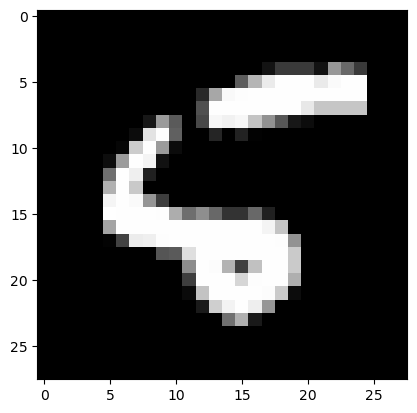

8


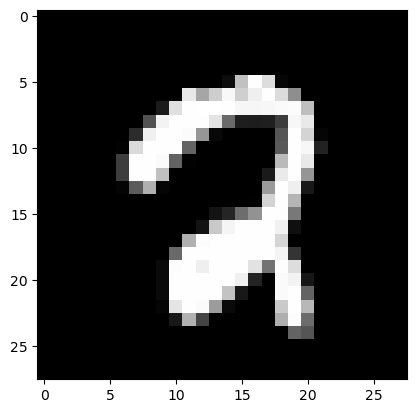

119


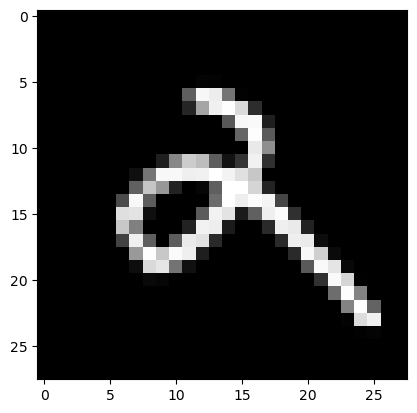

149


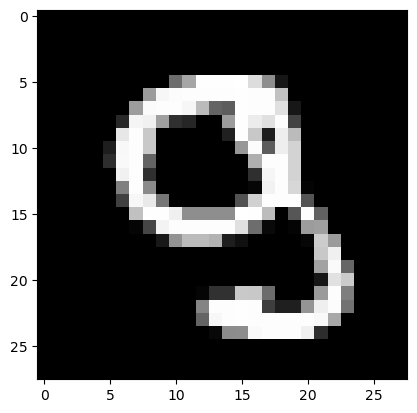

151


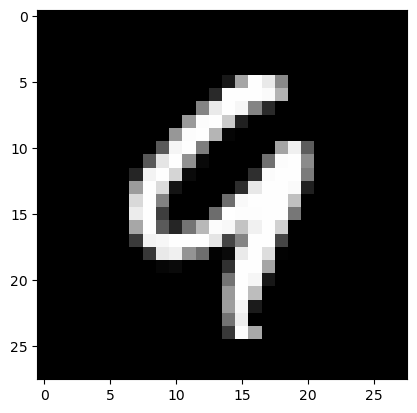

185


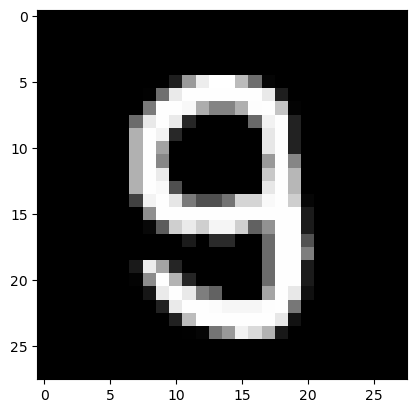

241


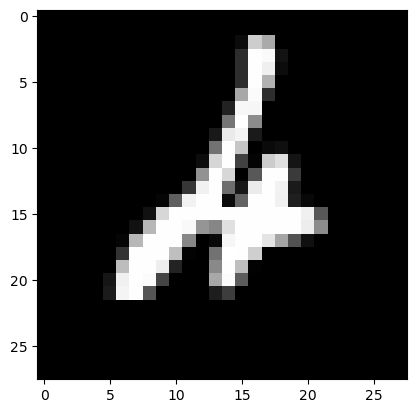

247


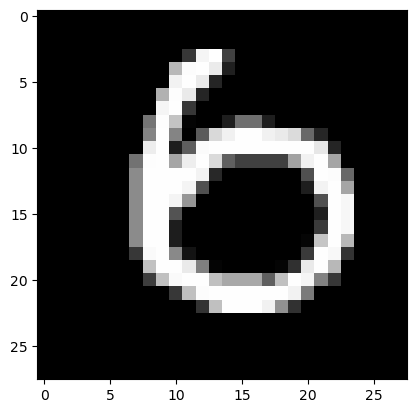

259


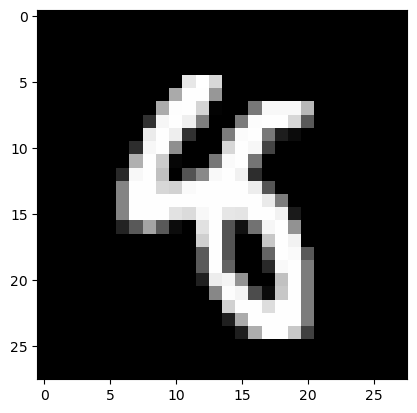

290


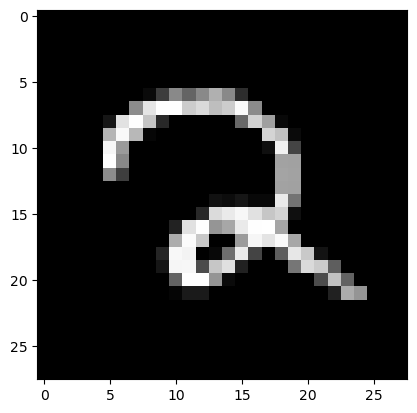

303


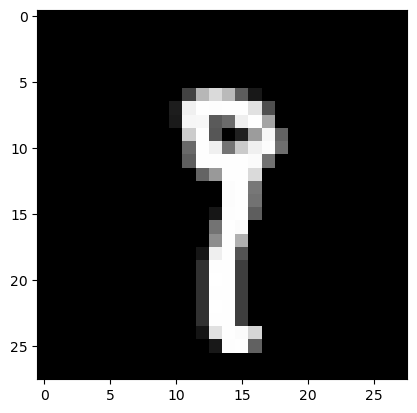

320


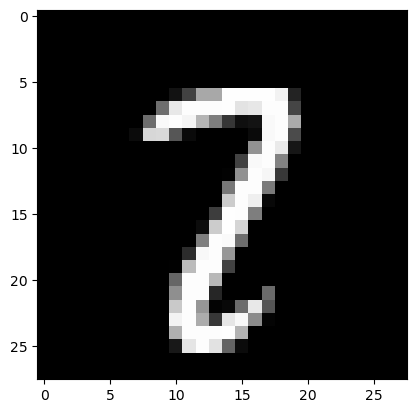

321


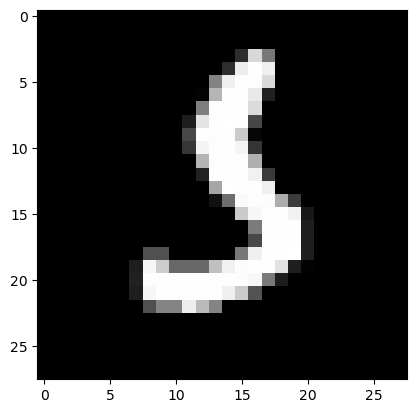

340


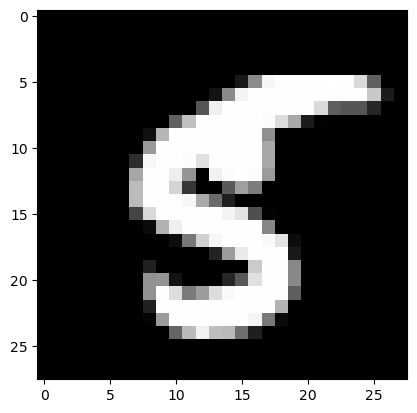

347


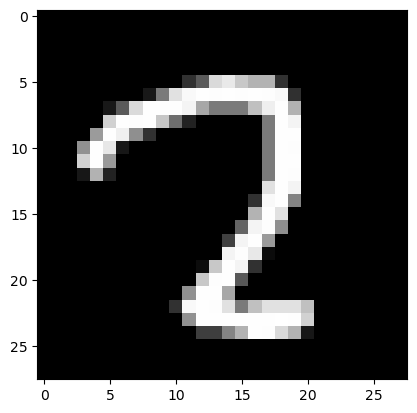

362


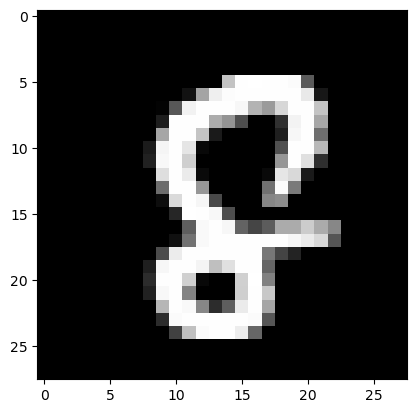

391


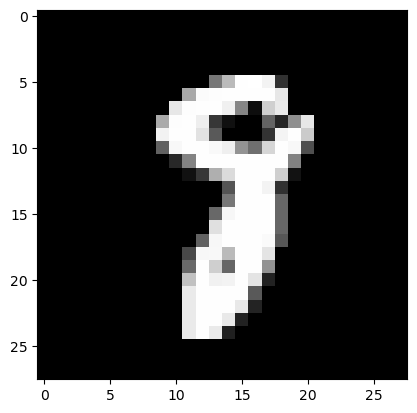

435


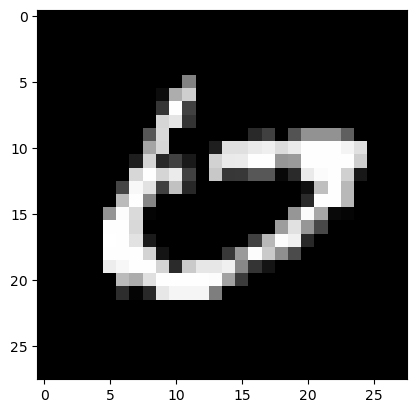

445


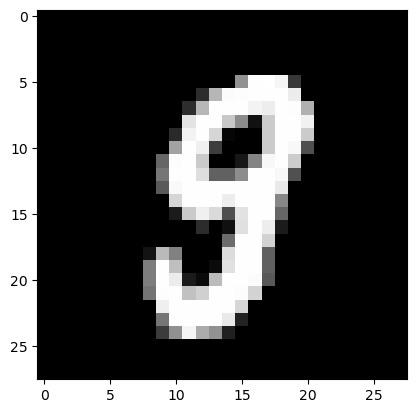

448


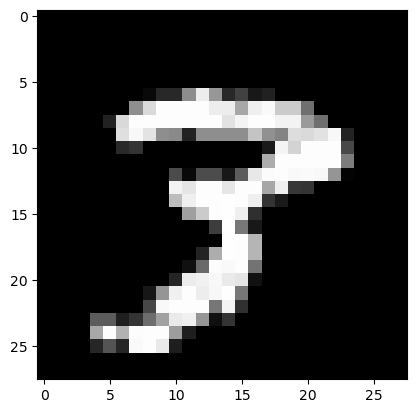

464


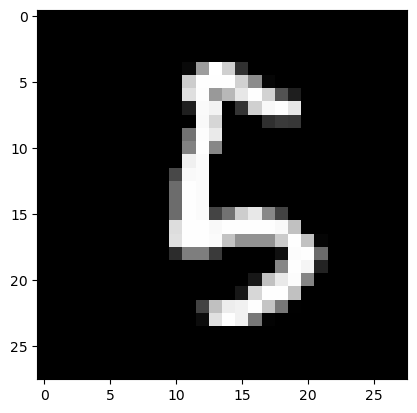

478


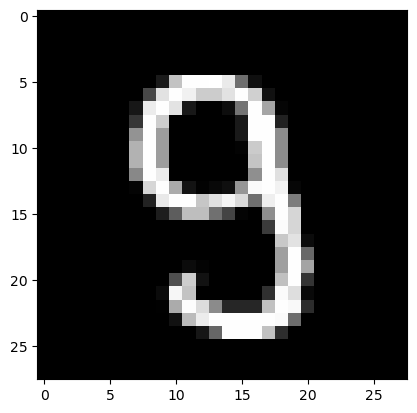

479


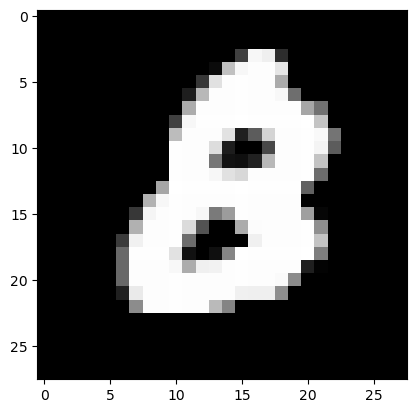

495


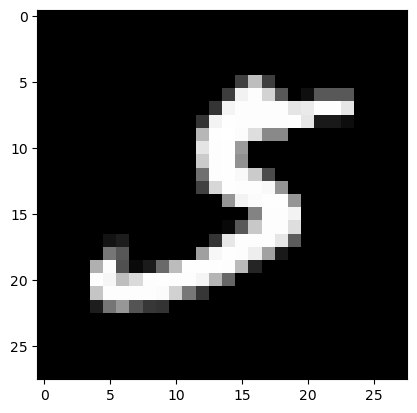

502


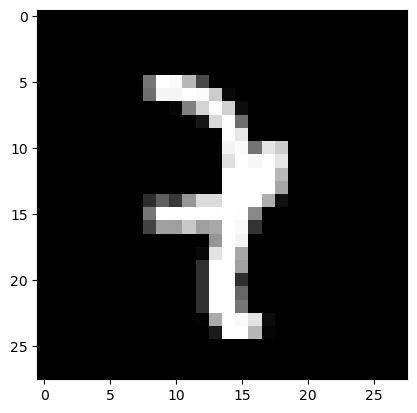

551


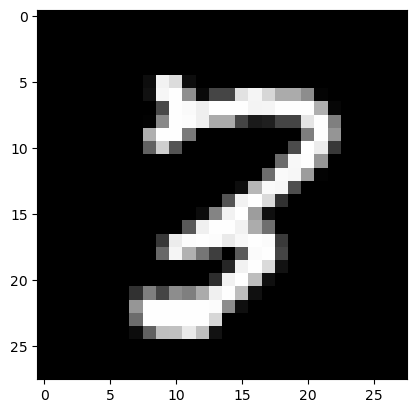

578


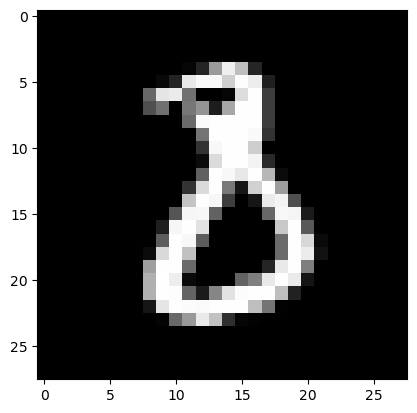

591


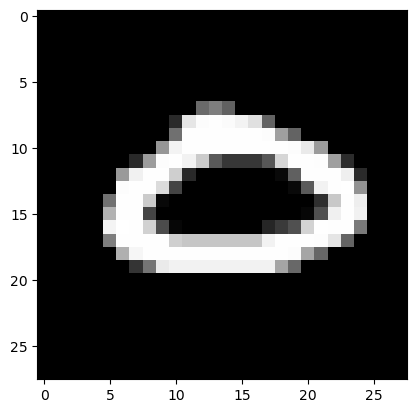

597


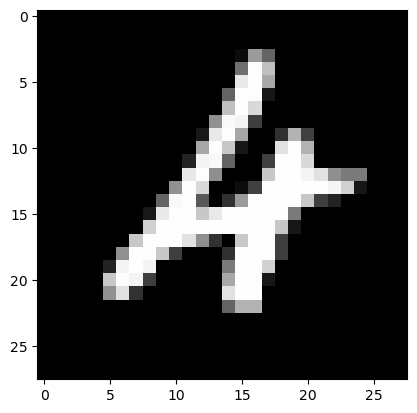

610


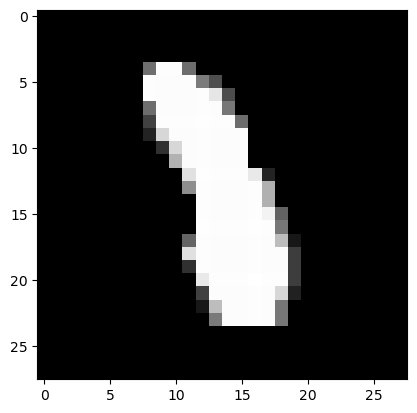

619


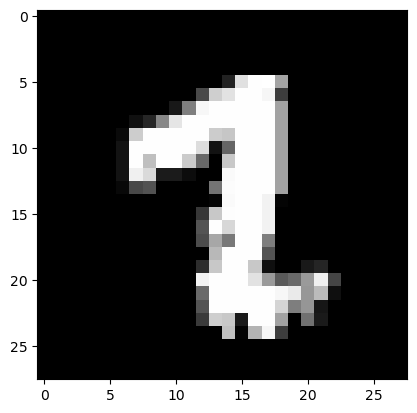

659


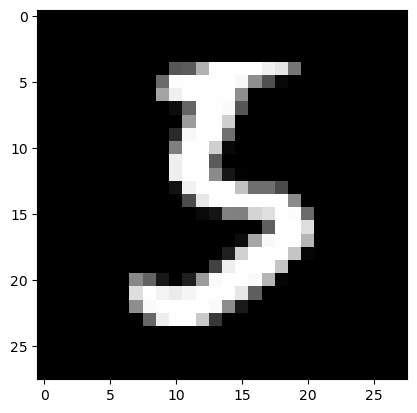

674


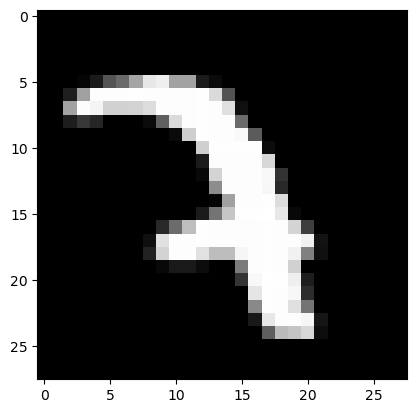

684


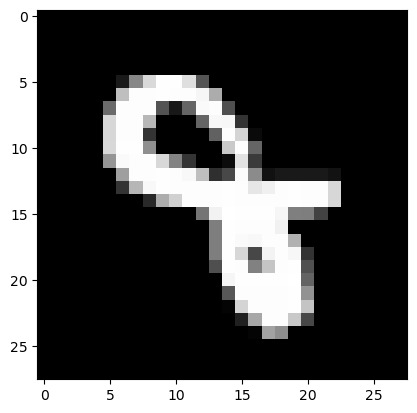

691


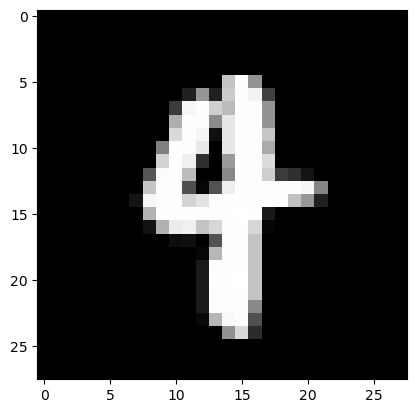

707


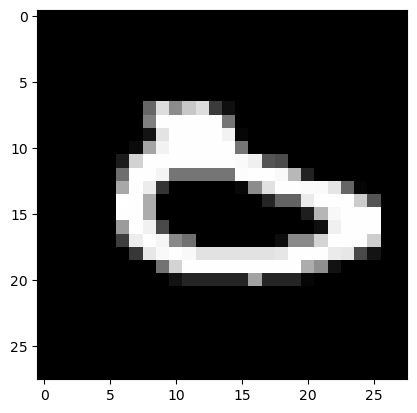

717


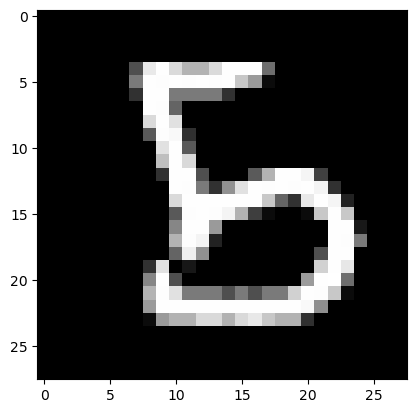

720


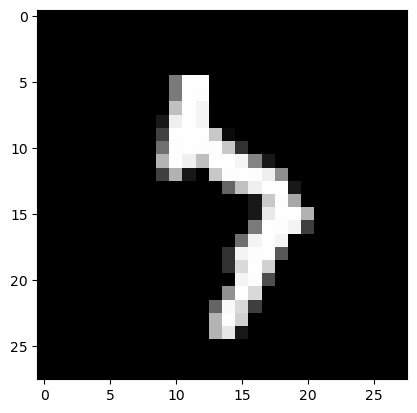

726


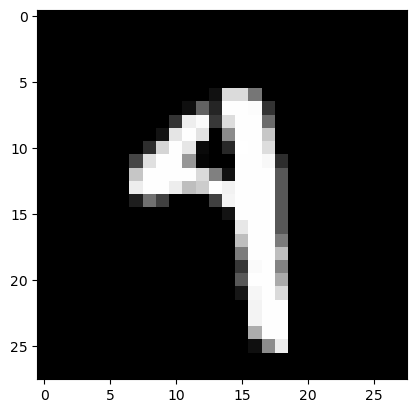

740


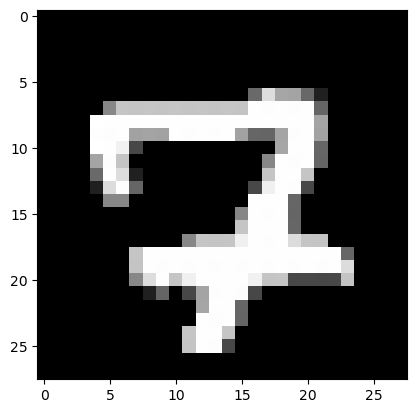

810


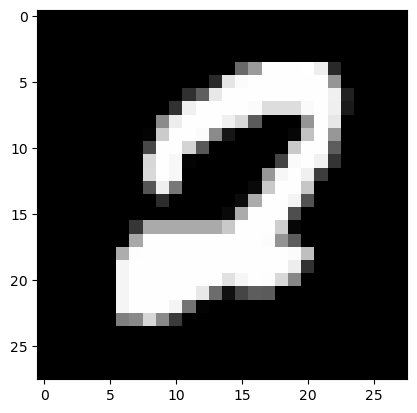

823


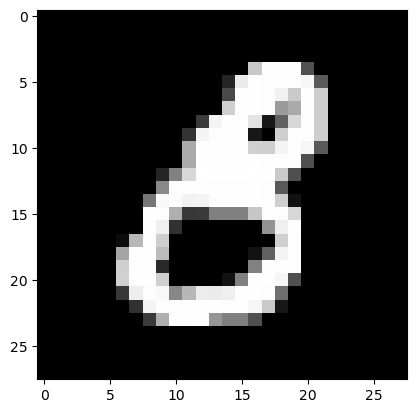

839


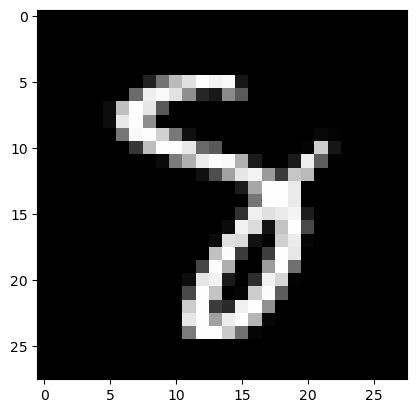

844


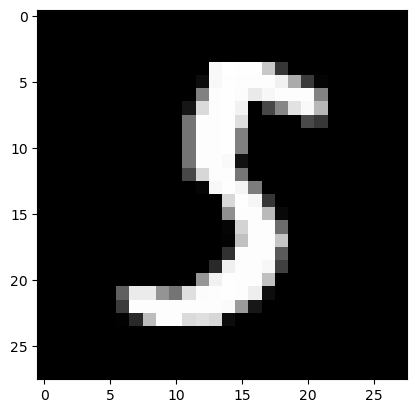

857


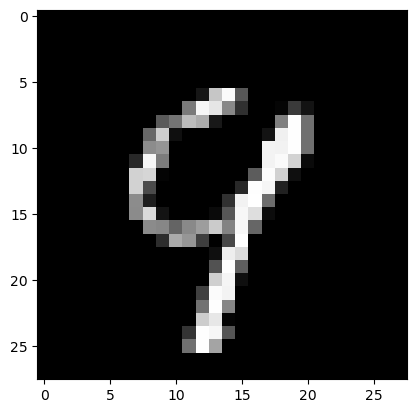

882


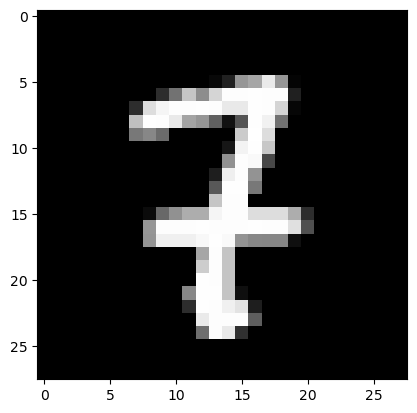

898


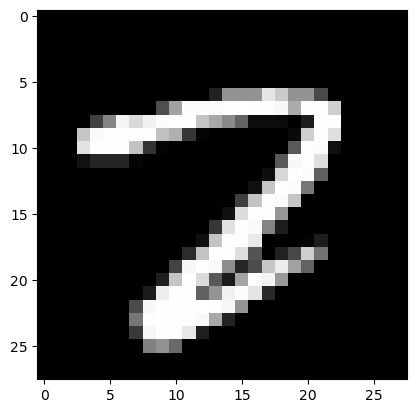

924


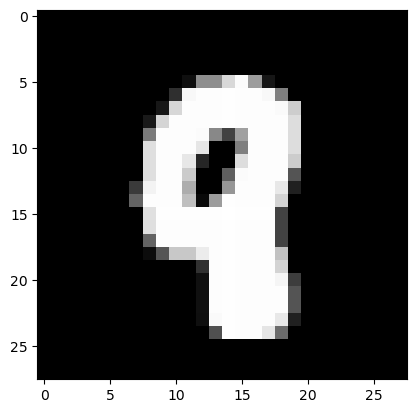

947


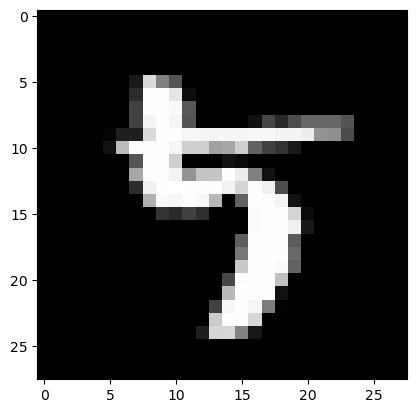

951


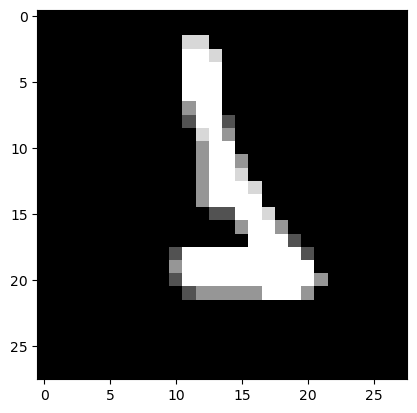

956


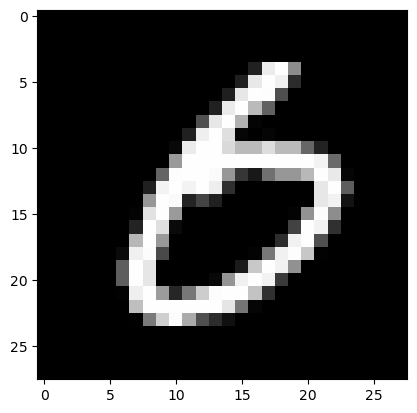

965


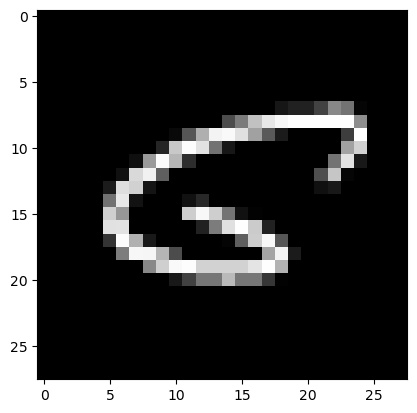

1014


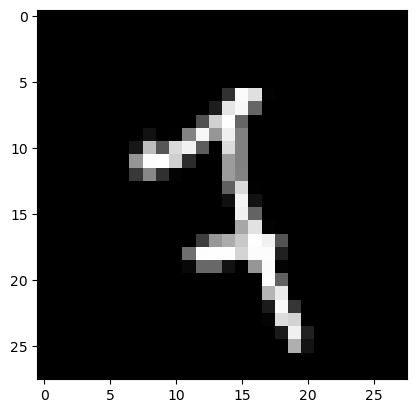

1039


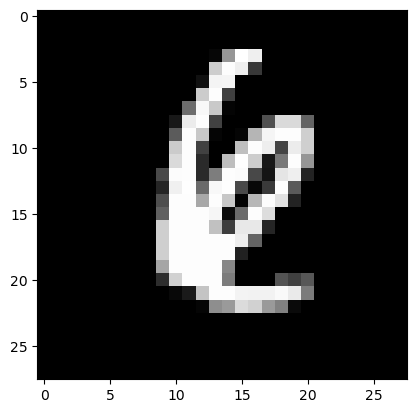

1044


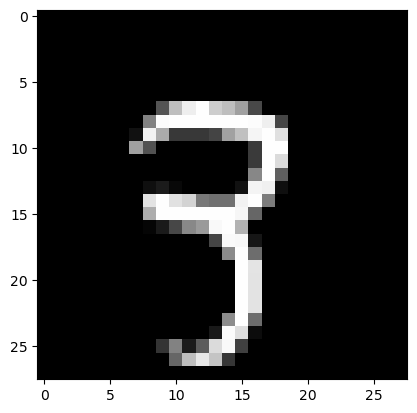

1062


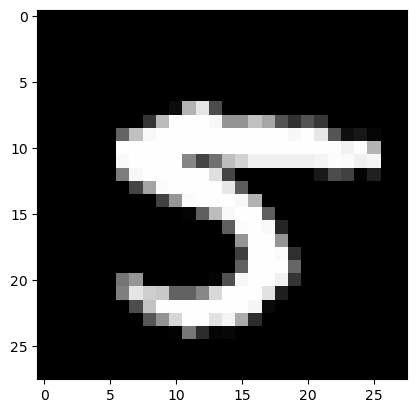

1073


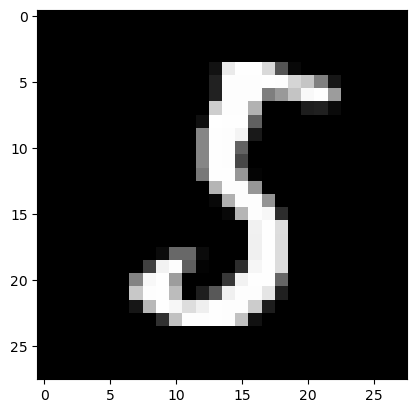

1082


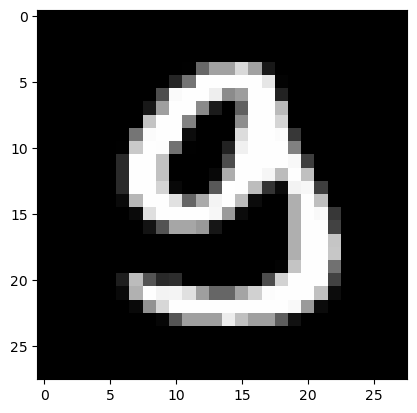

1107


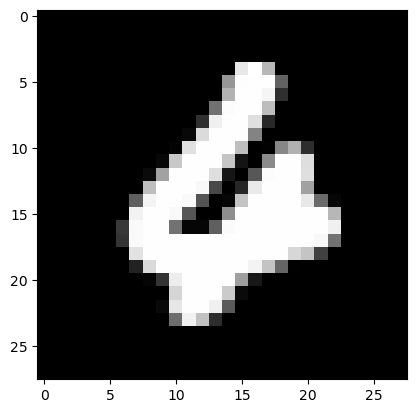

1112


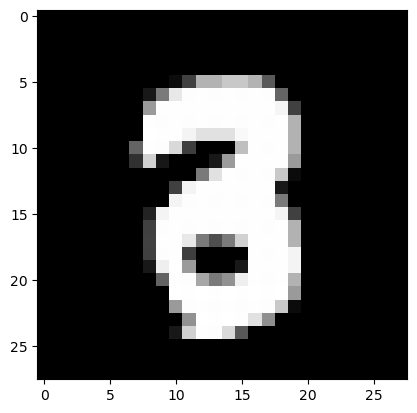

1114


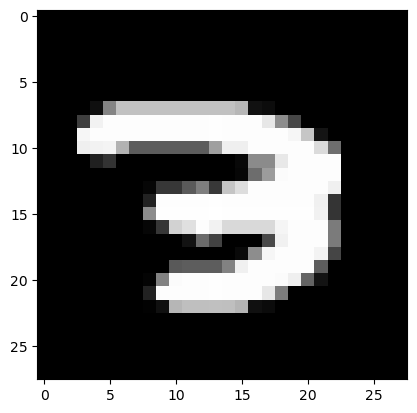

1128


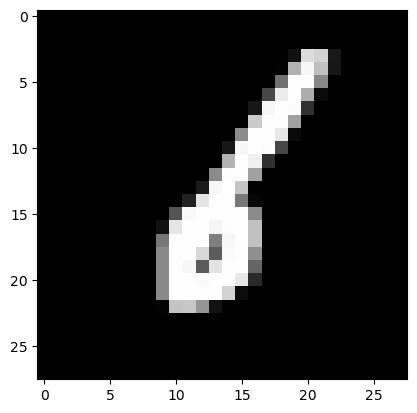

1181


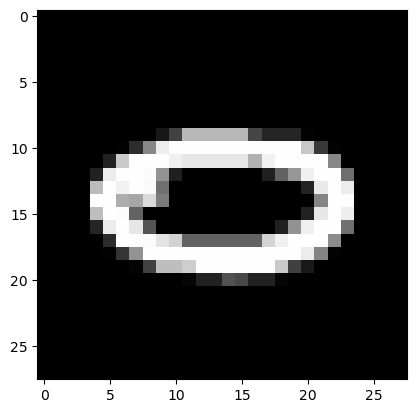

1191


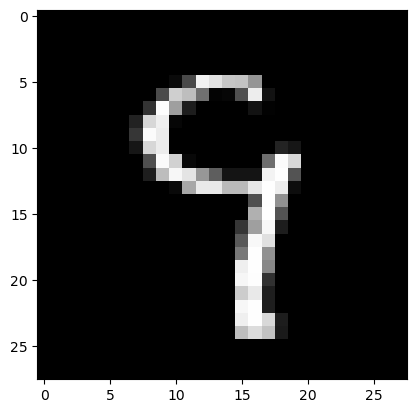

1192


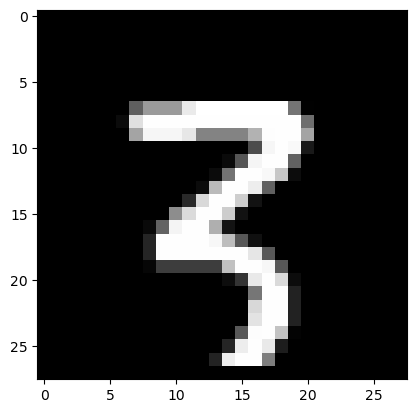

1204


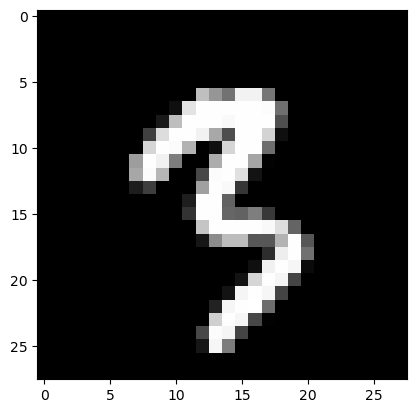

1208


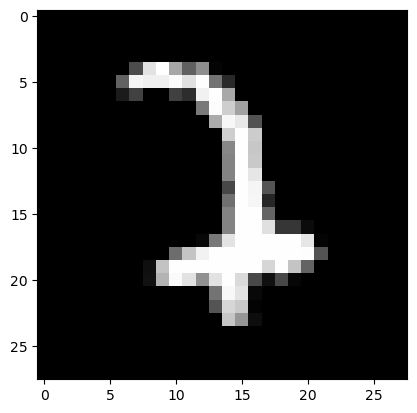

1226


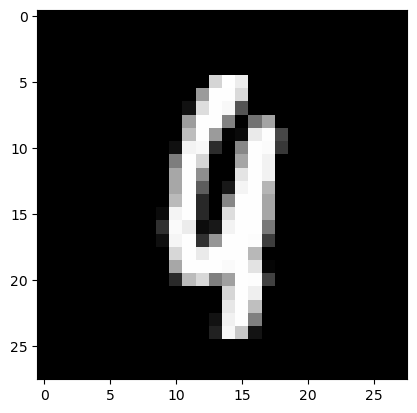

1232


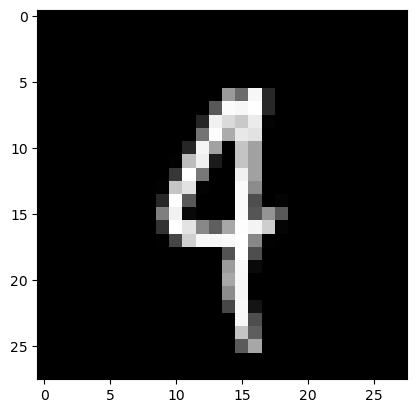

1242


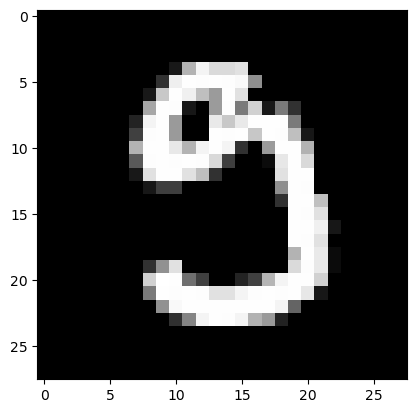

1247


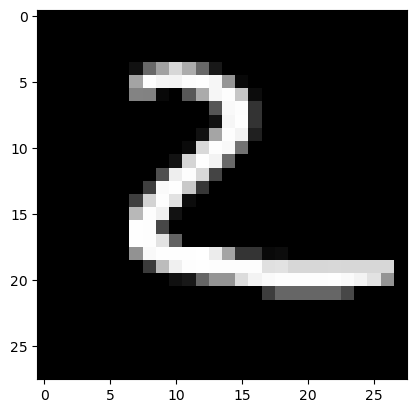

1251


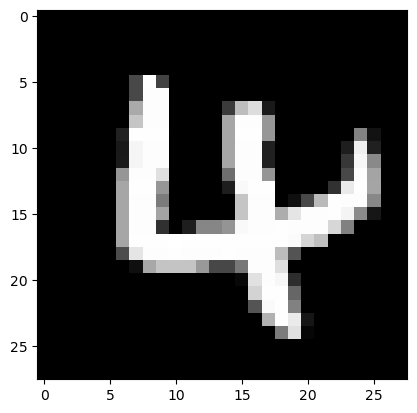

1253


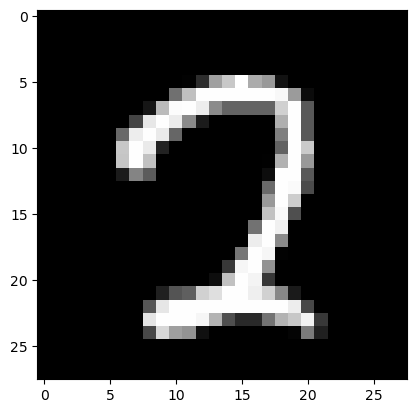

1256


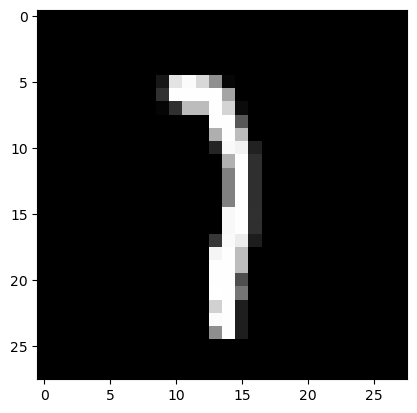

1260


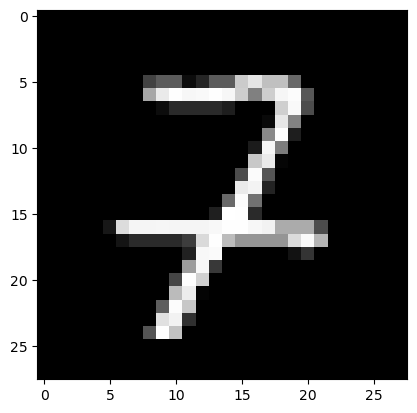

1283


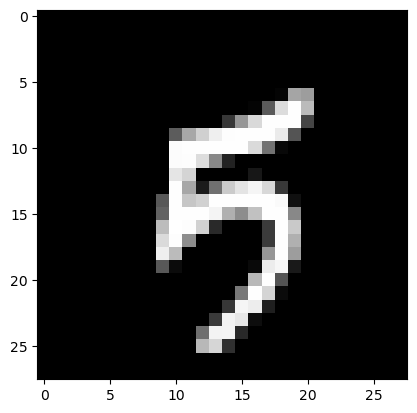

1289


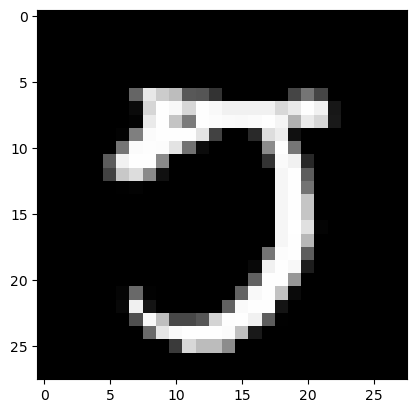

1299


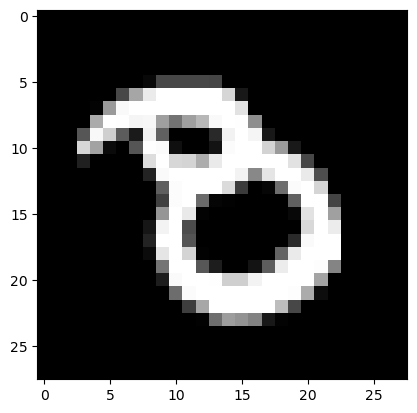

1319


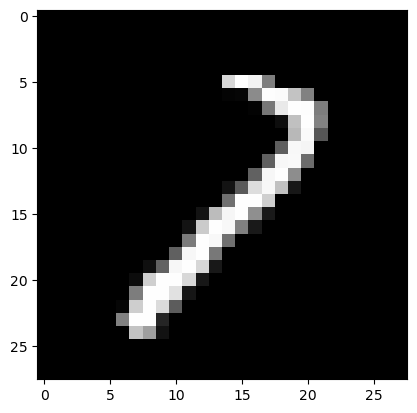

1326


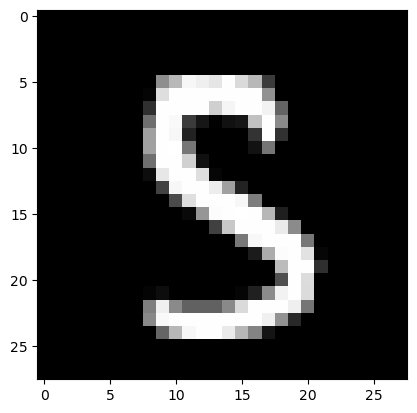

1331


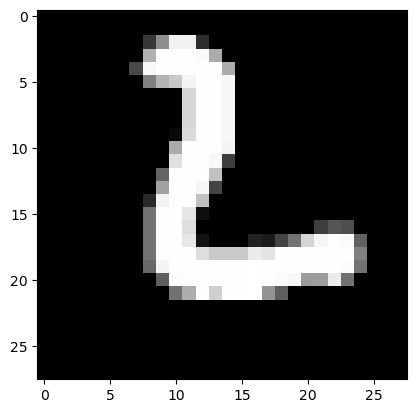

1337


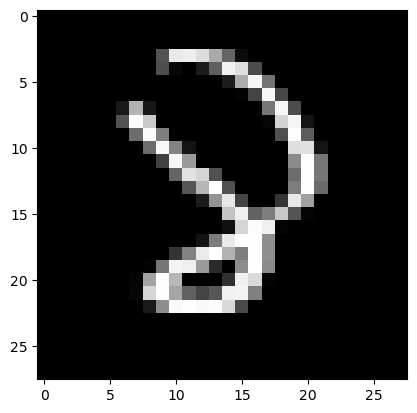

1364


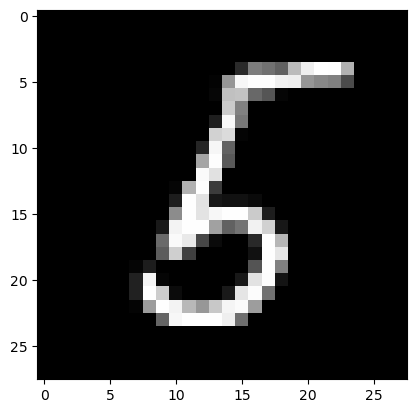

1378


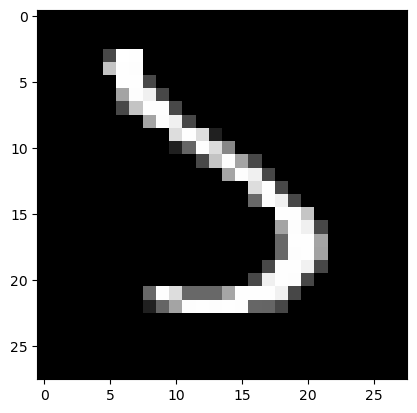

1393


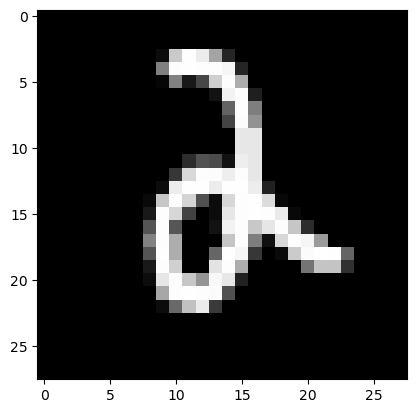

1410


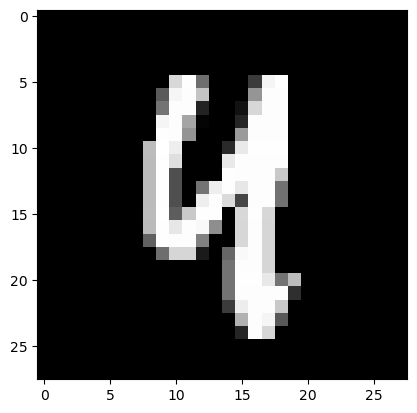

1413


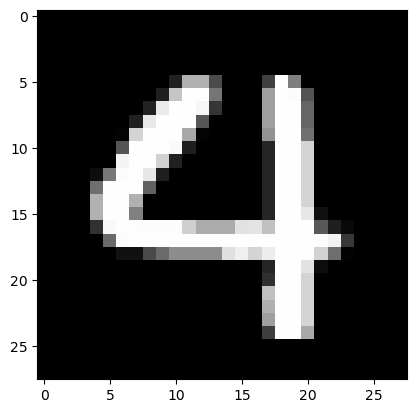

1422


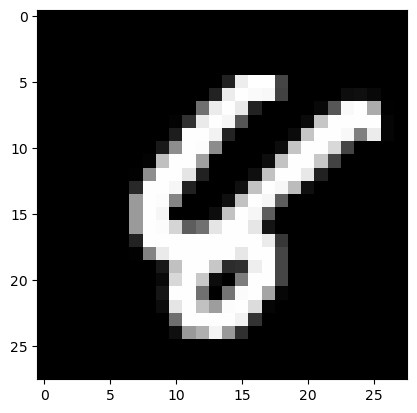

1425


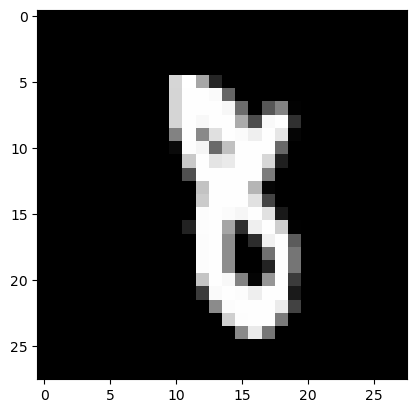

1433


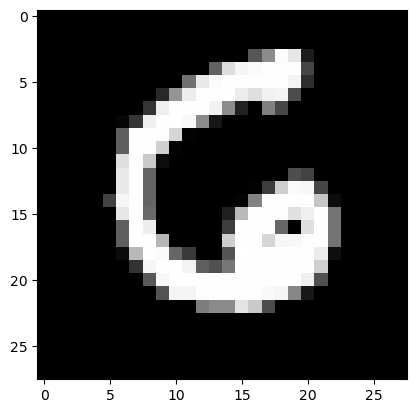

1458


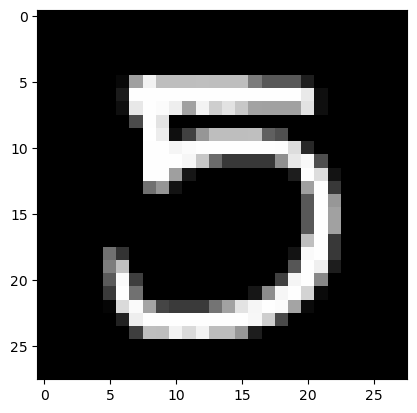

1466


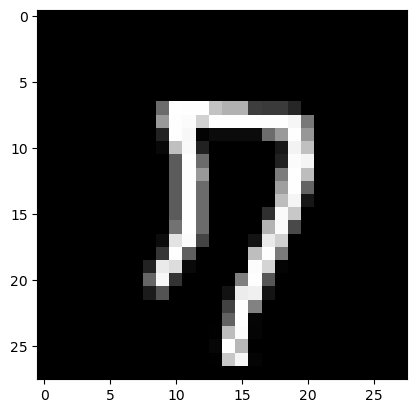

1494


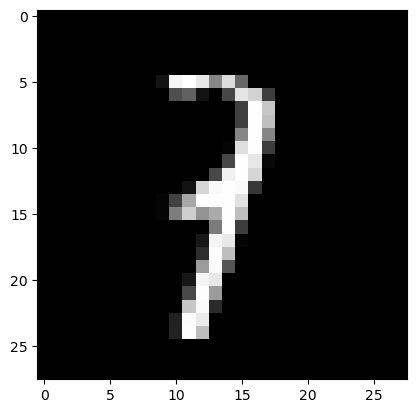

1500


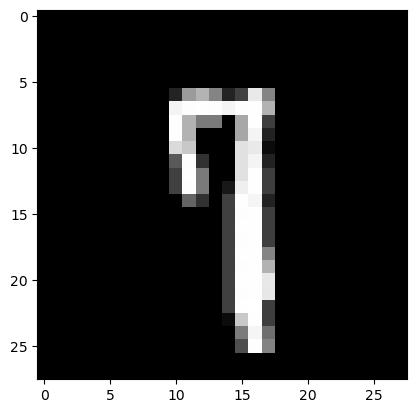

1522


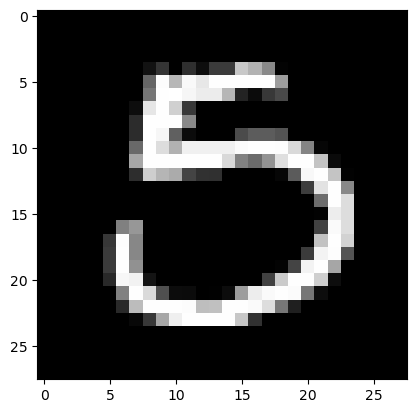

1525


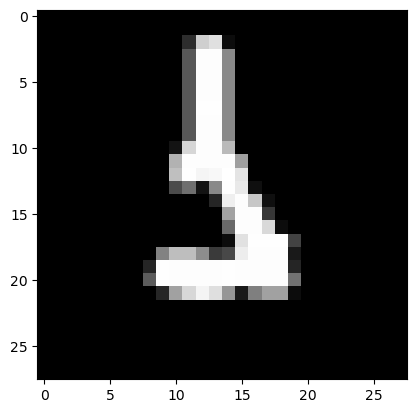

1527


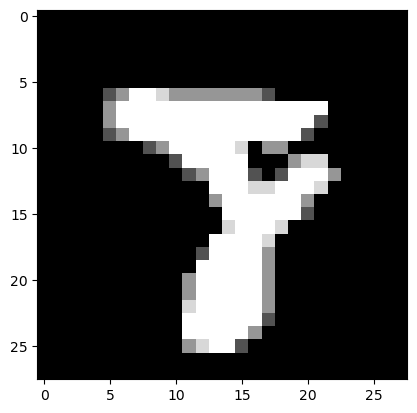

1530


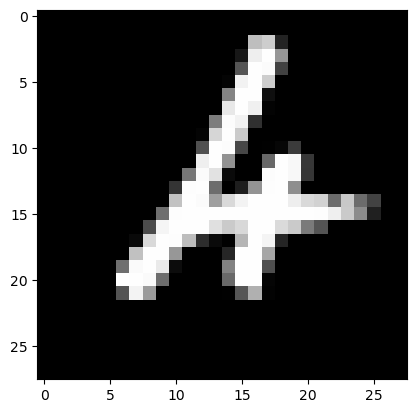

1549


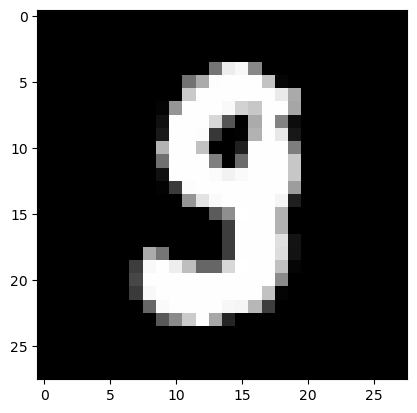

1553


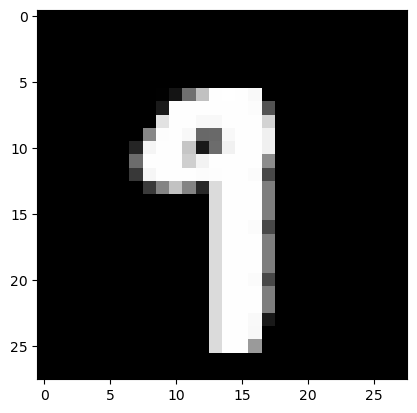

1554


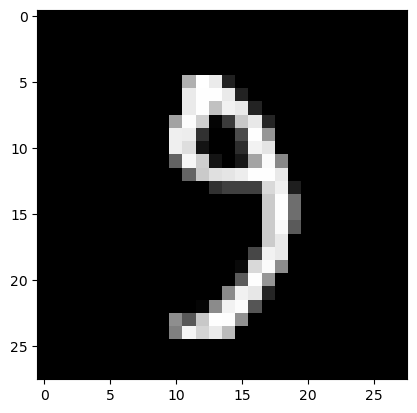

1559


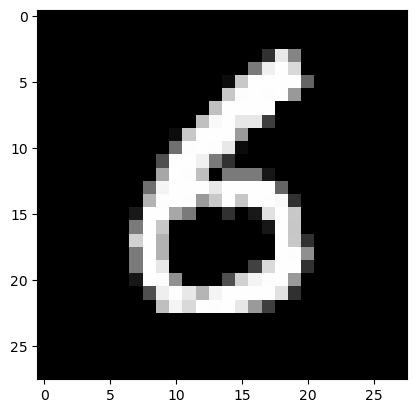

1587


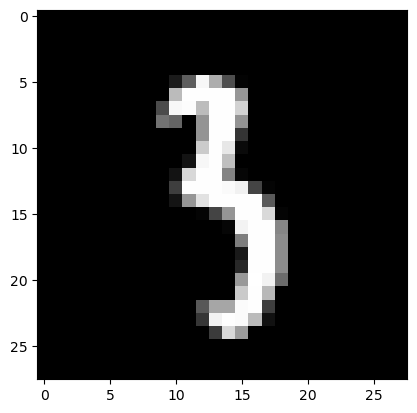

1607


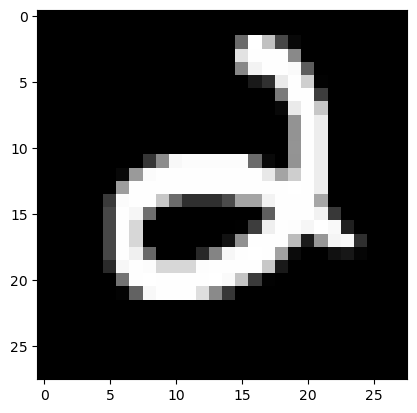

1609


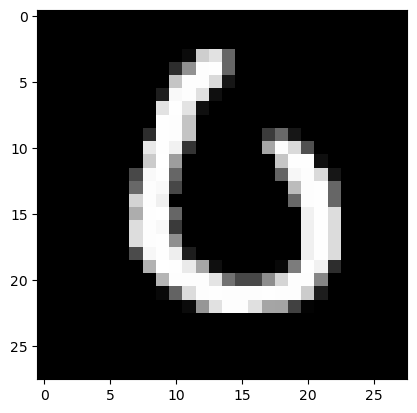

1621


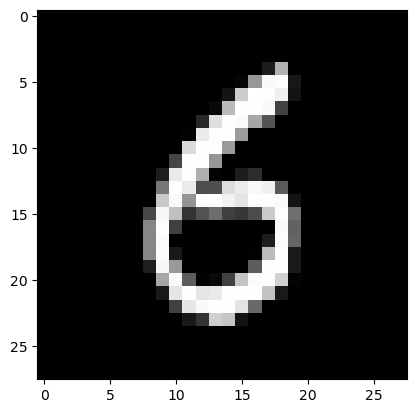

1626


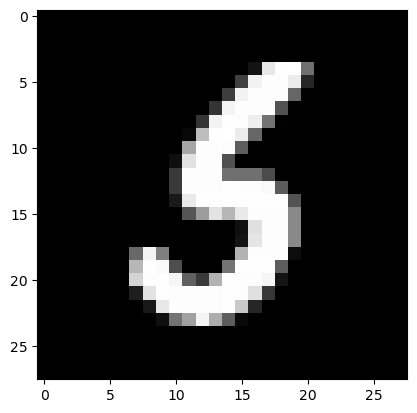

1637


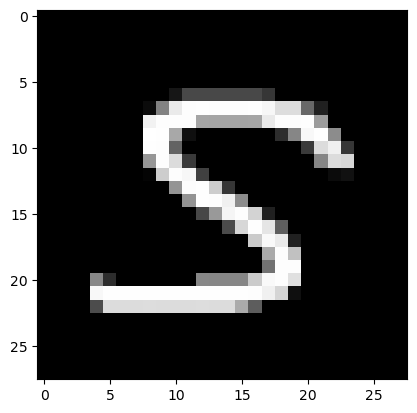

1670


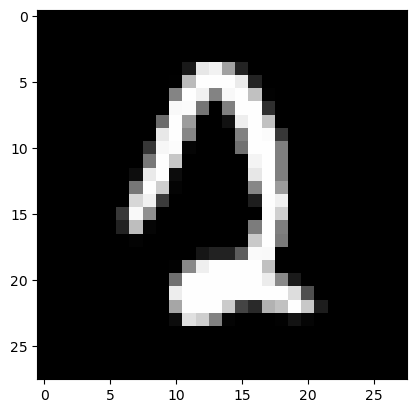

1678


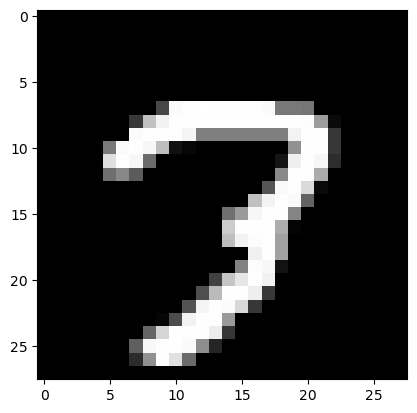

1681


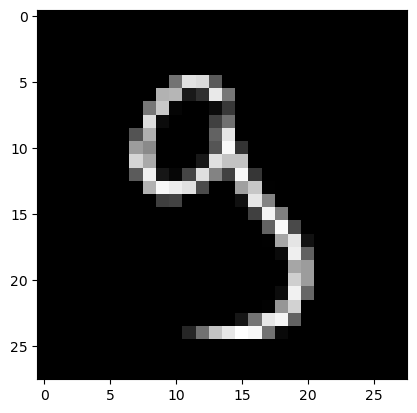

1709


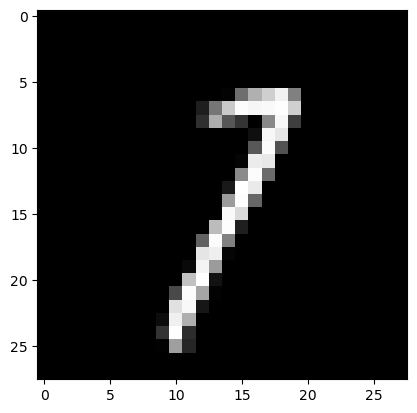

1716


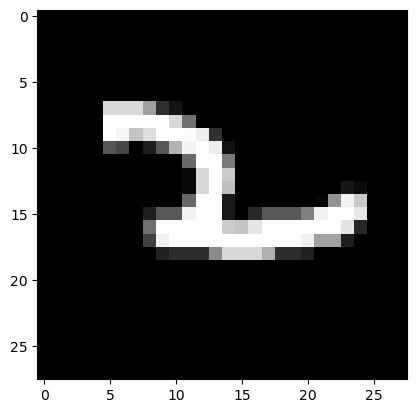

1722


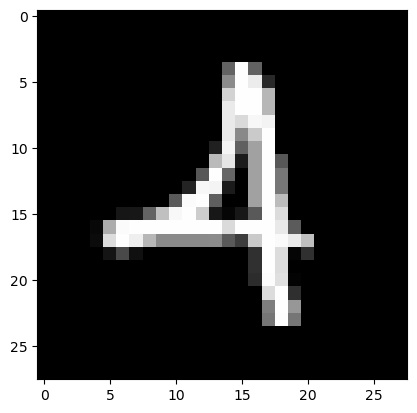

1751


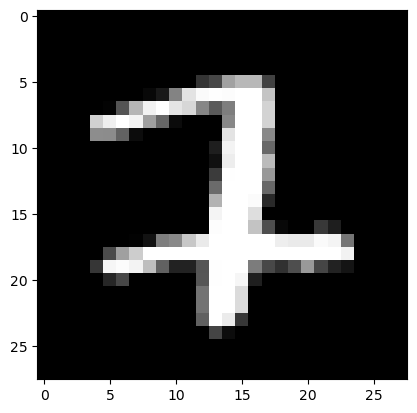

1754


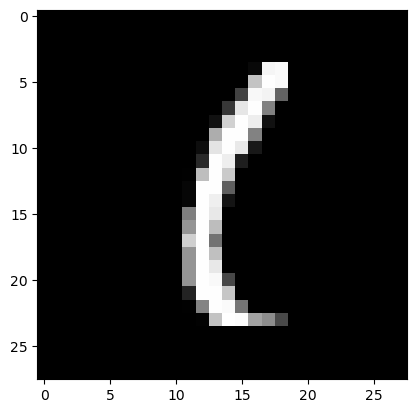

1773


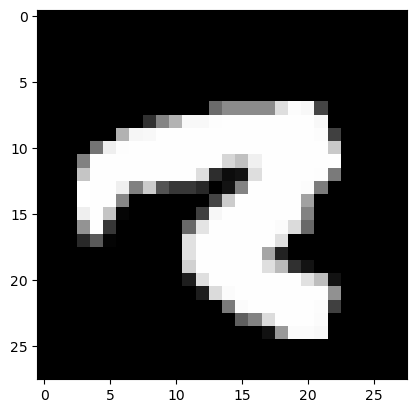

1790


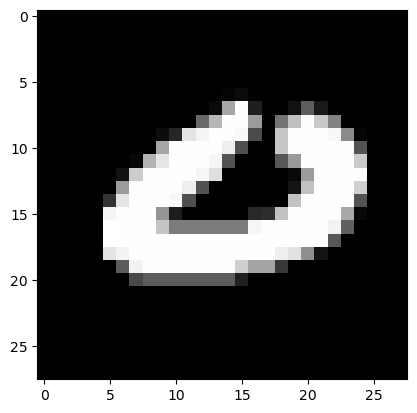

1808


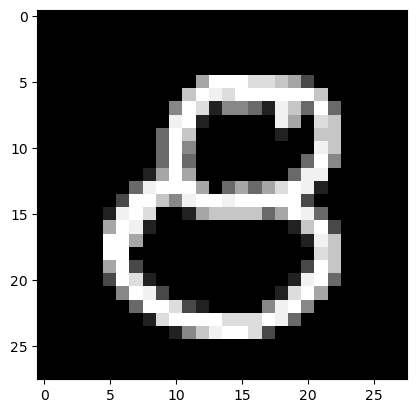

1813


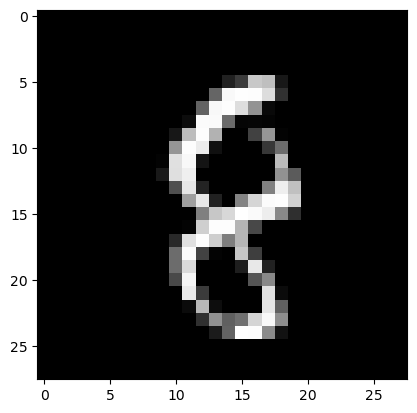

1823


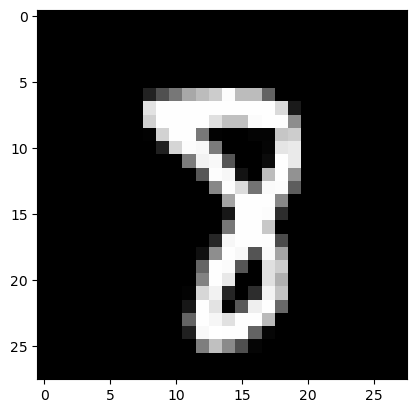

1850


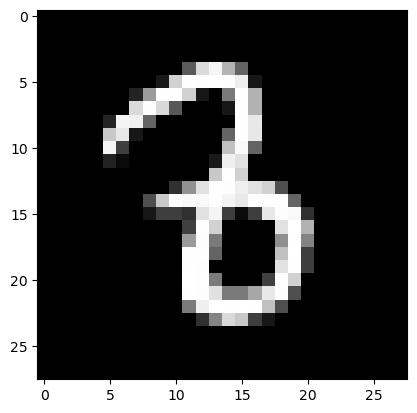

1878


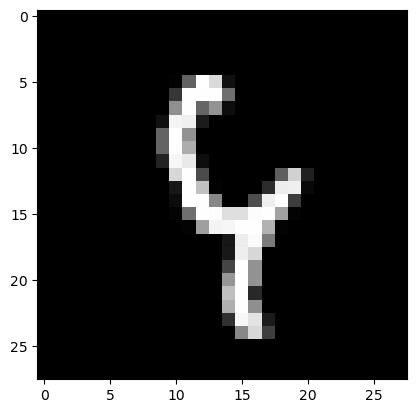

1901


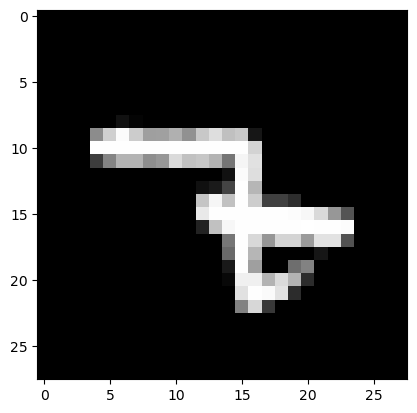

1903


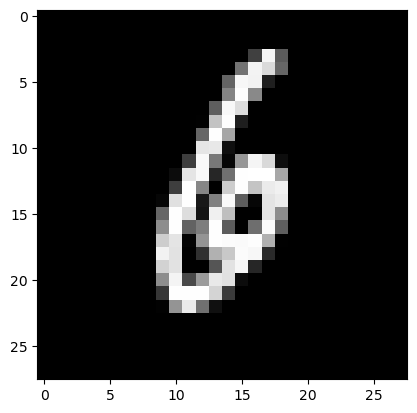

1908


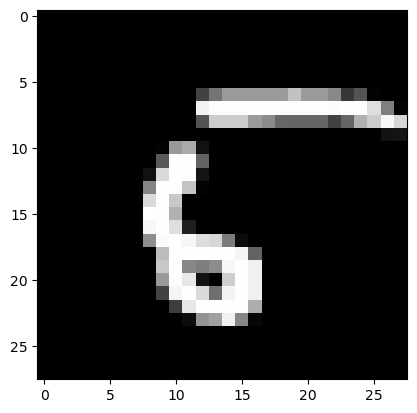

1911


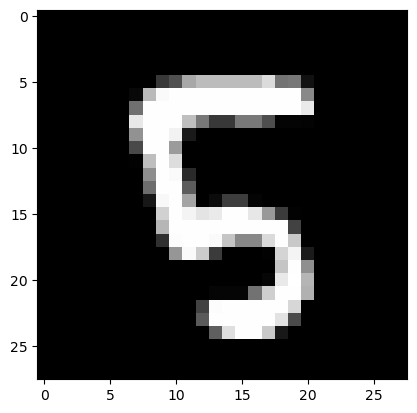

1917


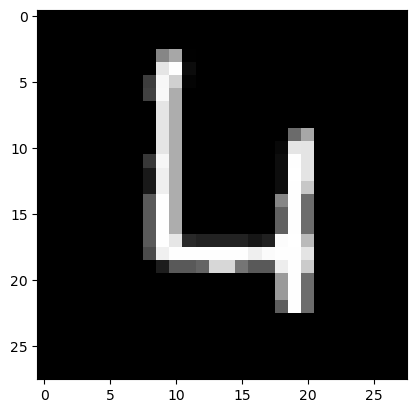

1938


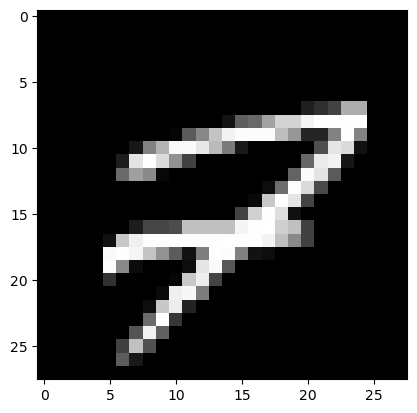

1941


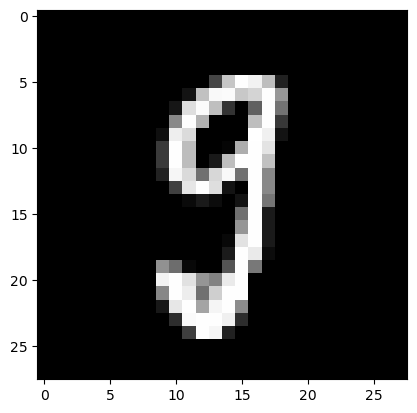

1952


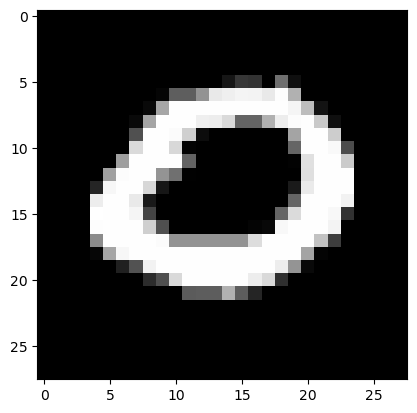

1987


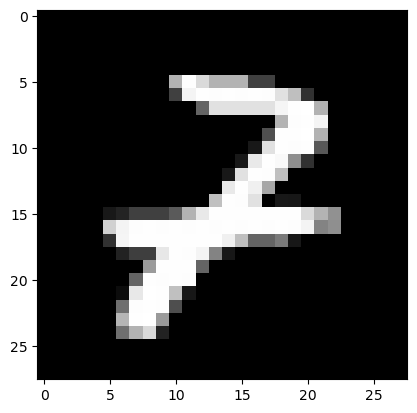

2016


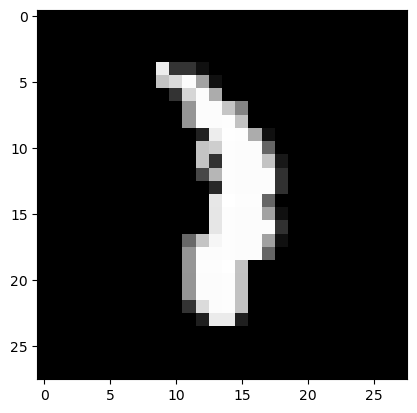

2018


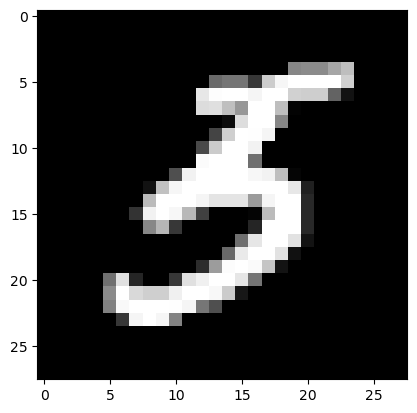

2035


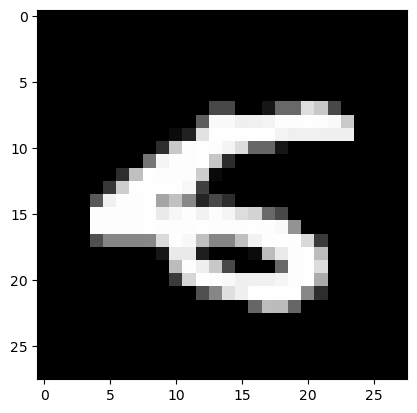

2040


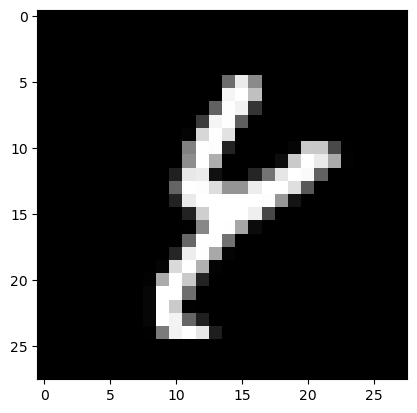

2043


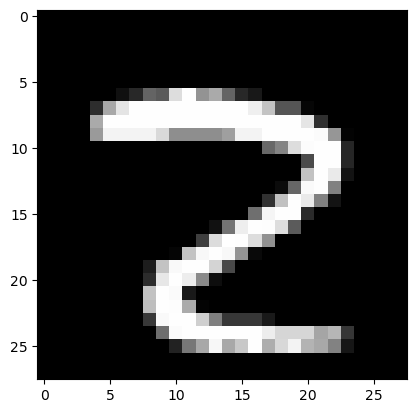

2044


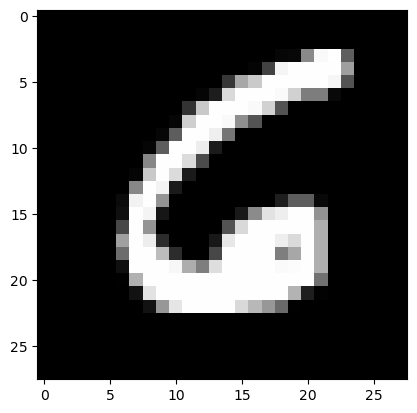

2047


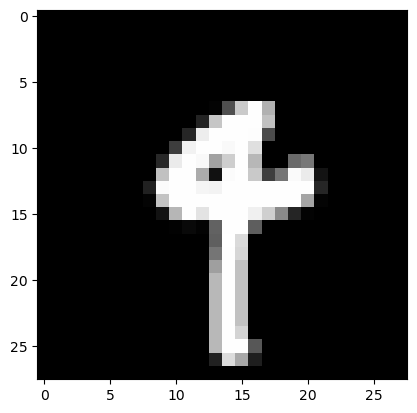

2053


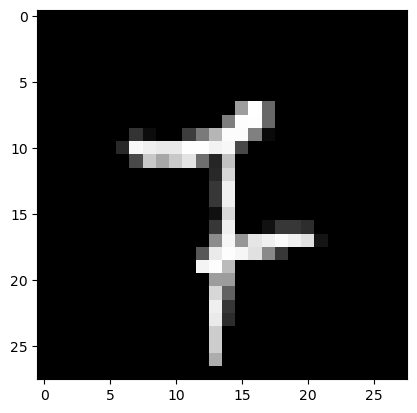

2063


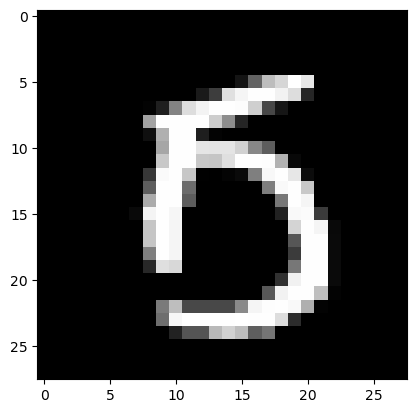

2073


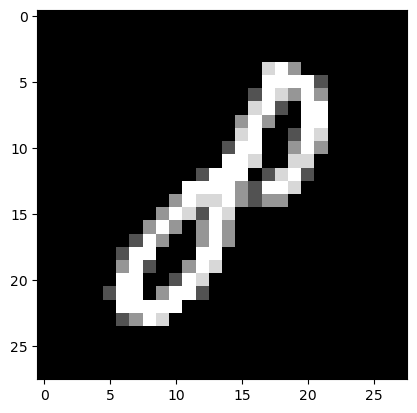

2093


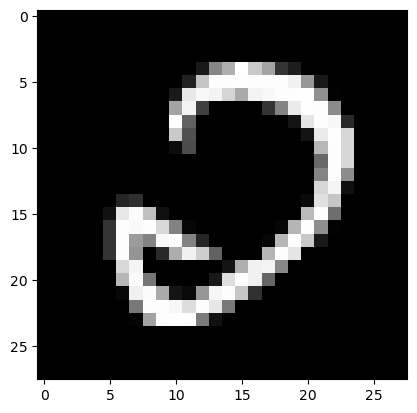

2098


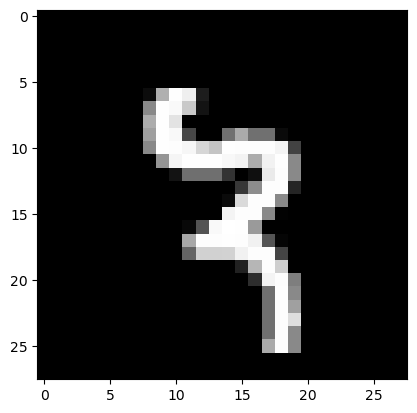

2109


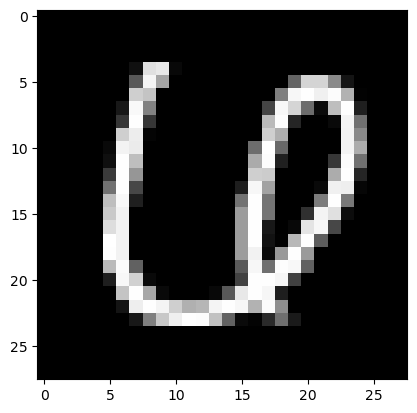

2118


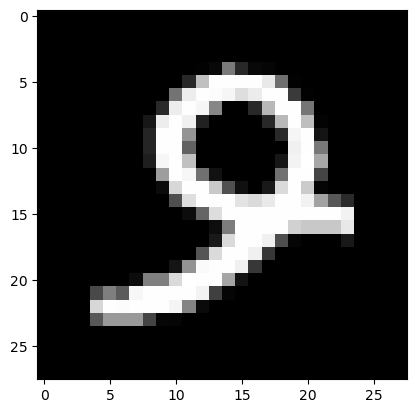

2129


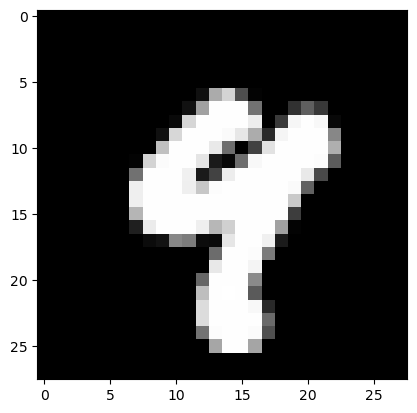

2130


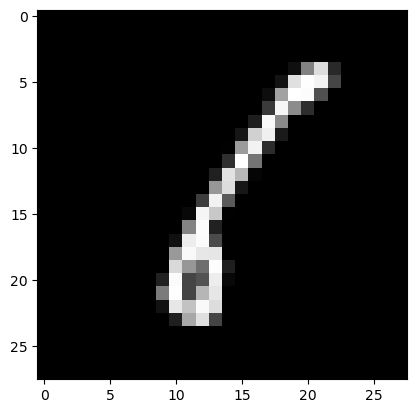

2135


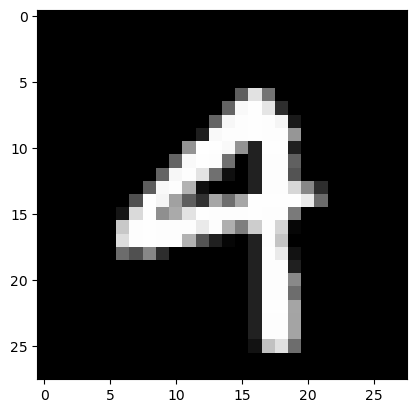

2148


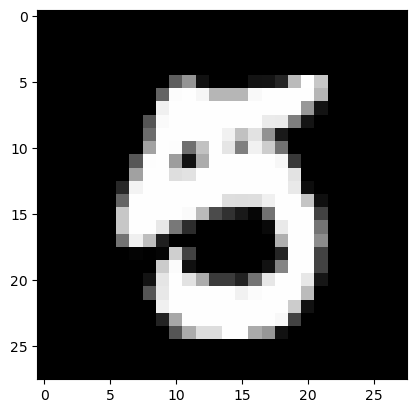

2162


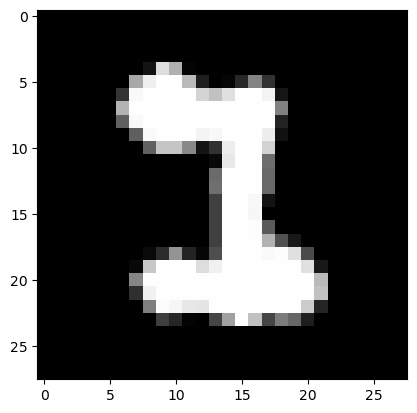

2182


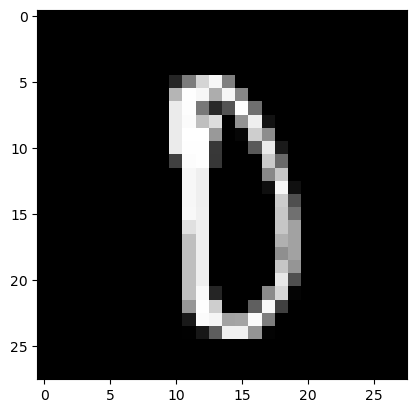

2185


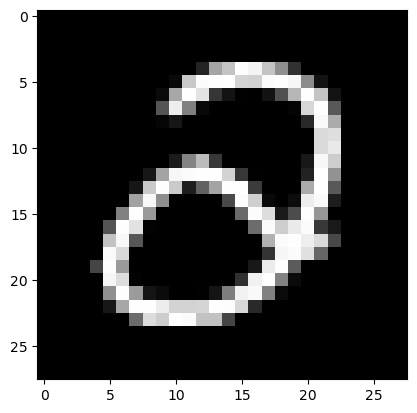

2186


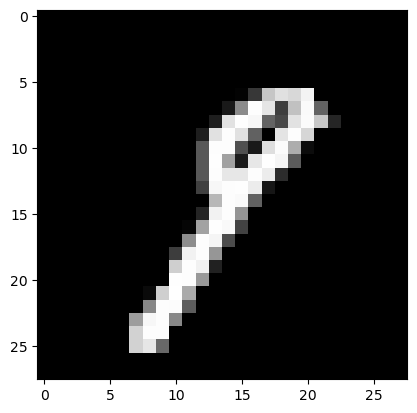

2189


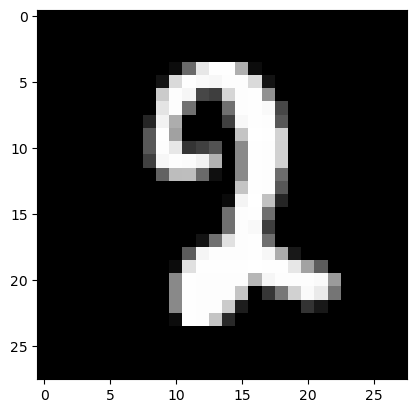

2198


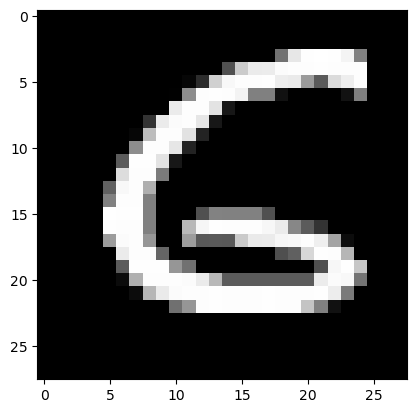

2215


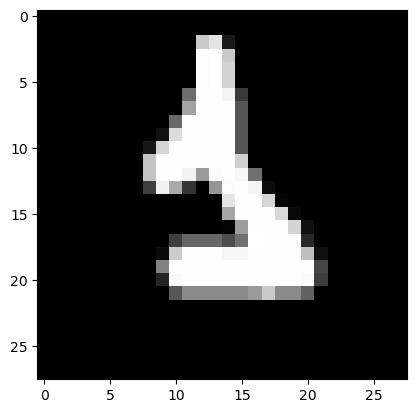

2266


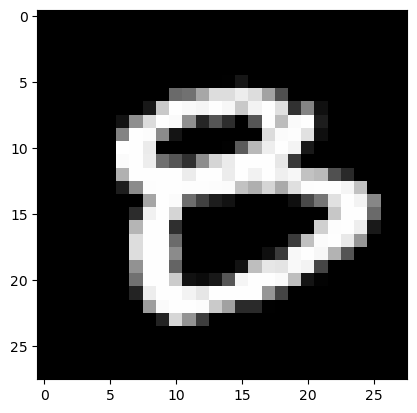

2272


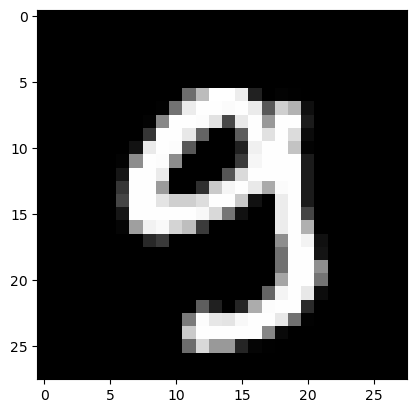

2292


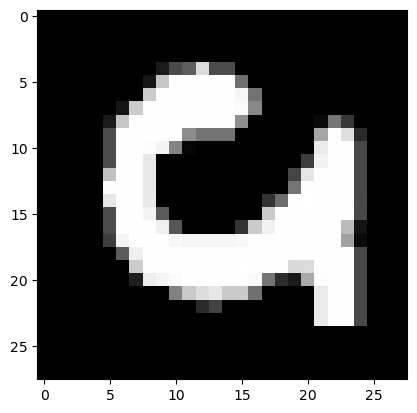

2293


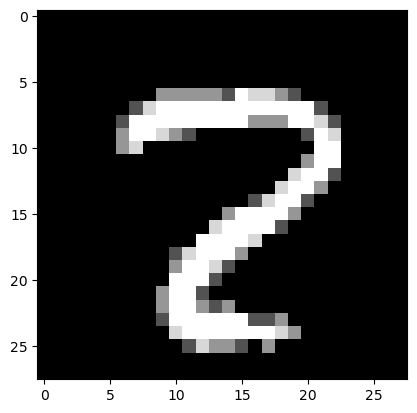

2299


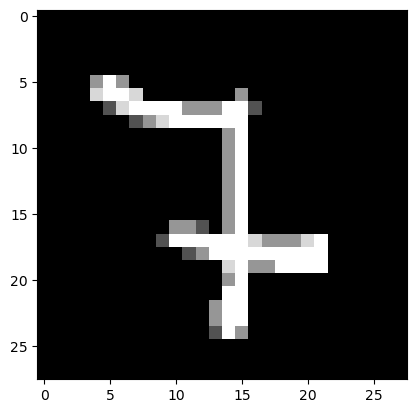

2325


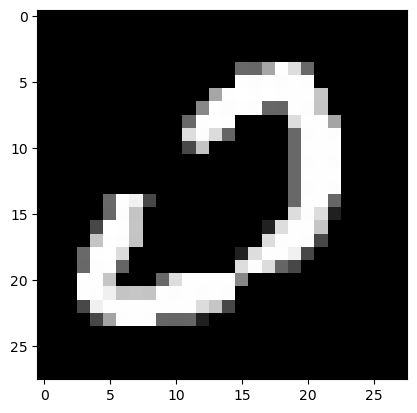

2329


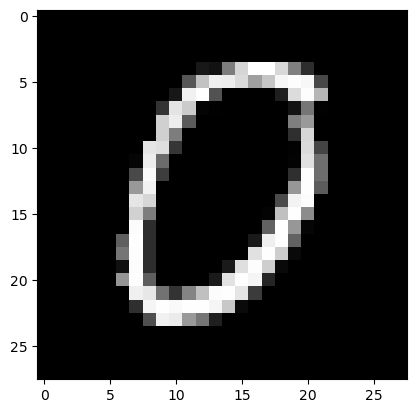

2333


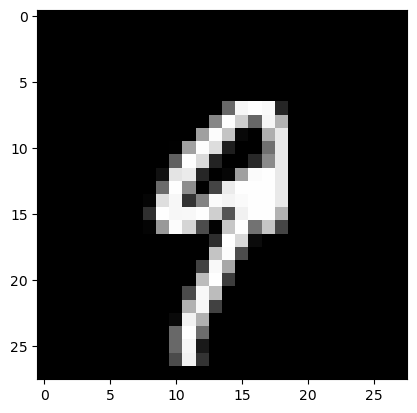

2361


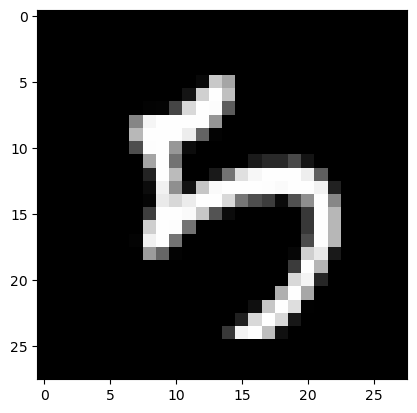

2369


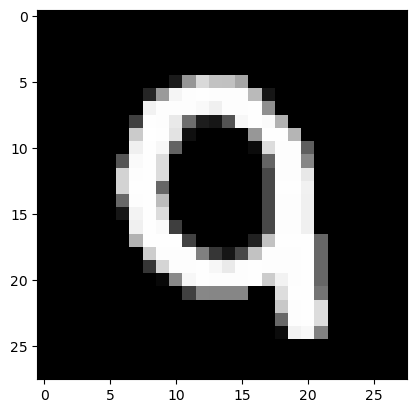

2380


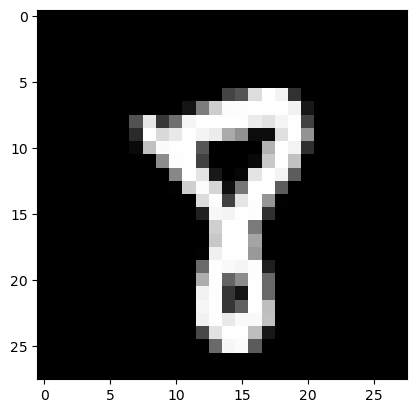

2381


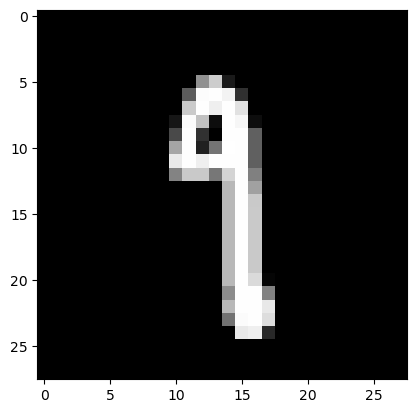

2387


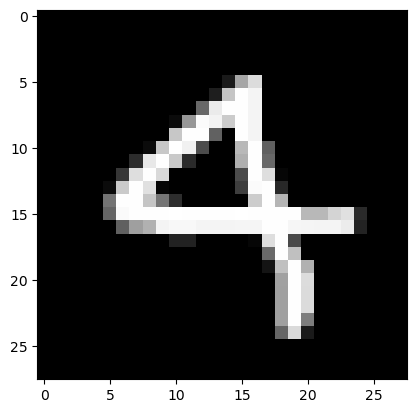

2394


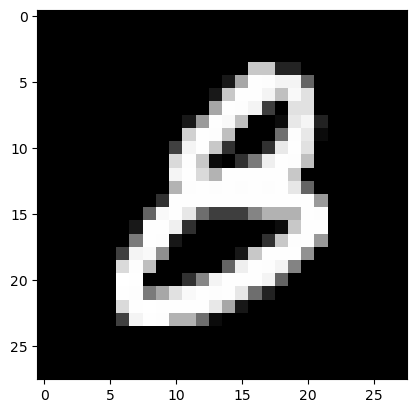

2395


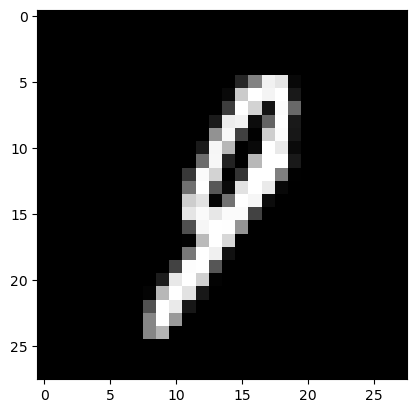

2406


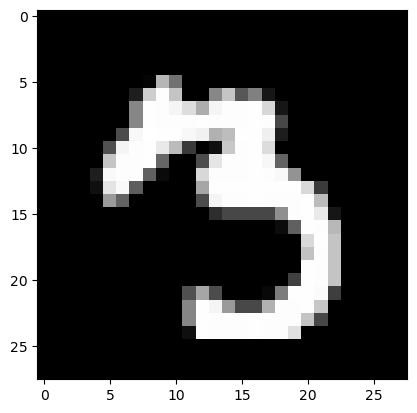

2408


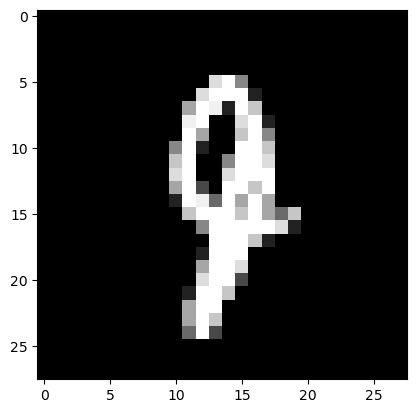

2414


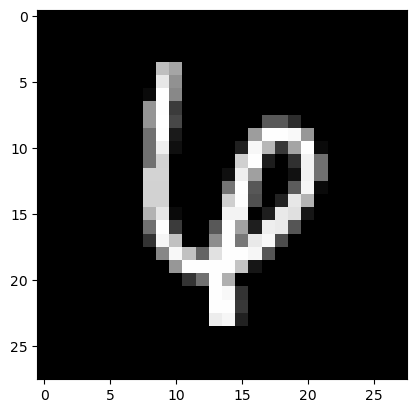

2422


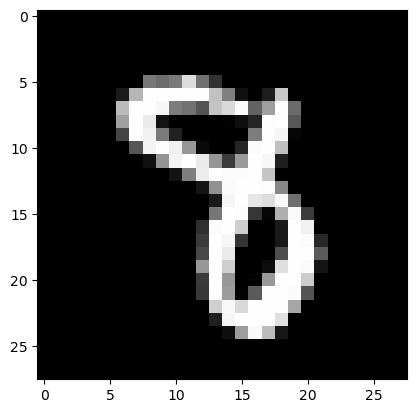

2425


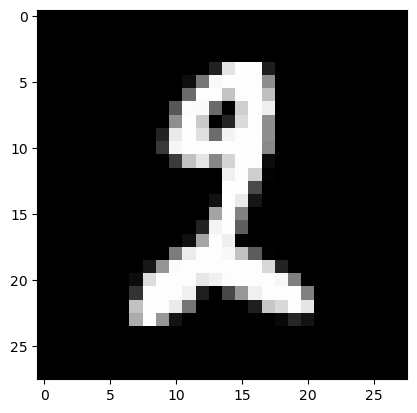

2433


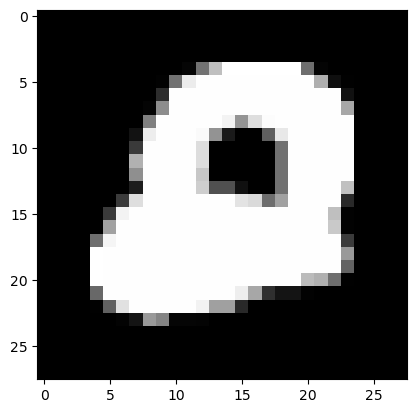

2462


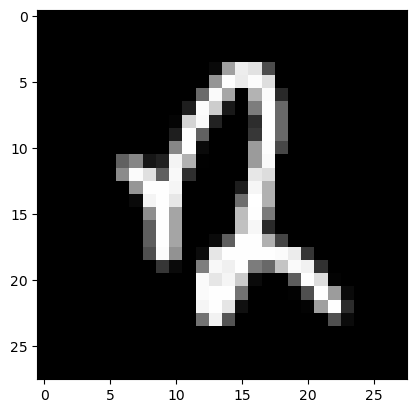

2488


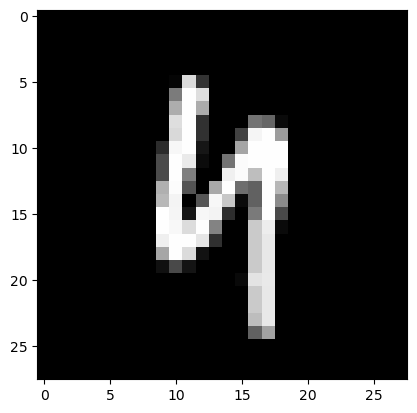

2514


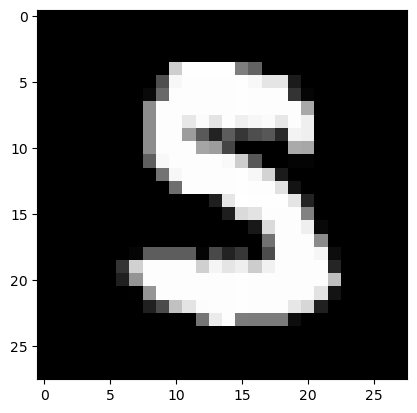

2526


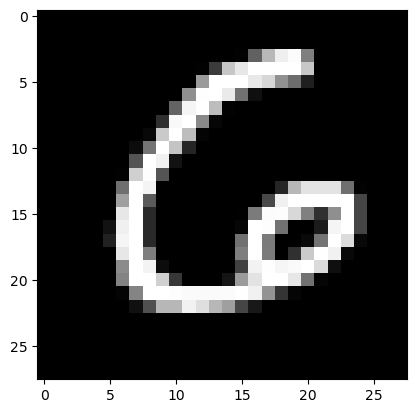

2542


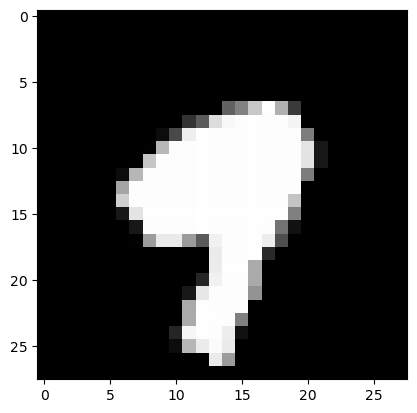

2548


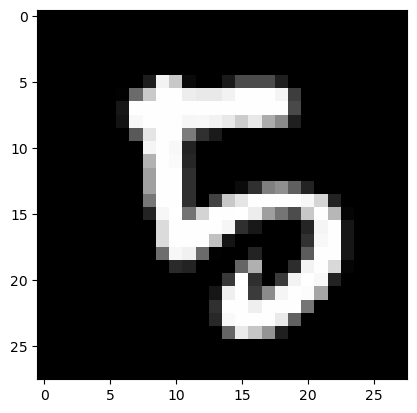

2556


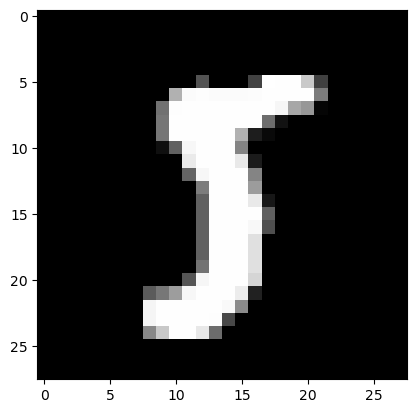

2573


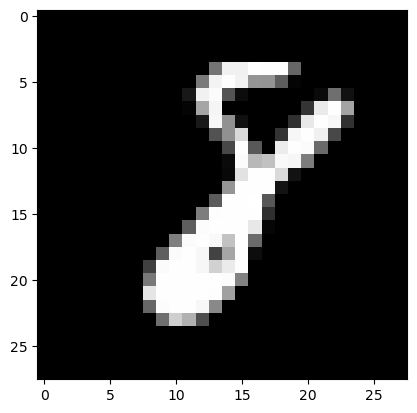

2598


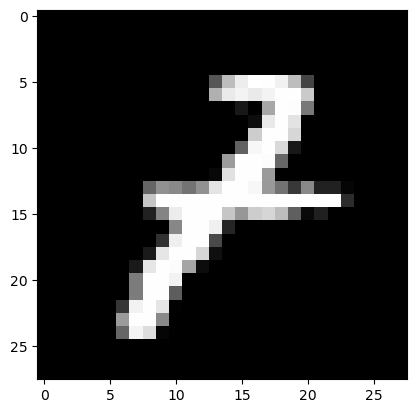

2607


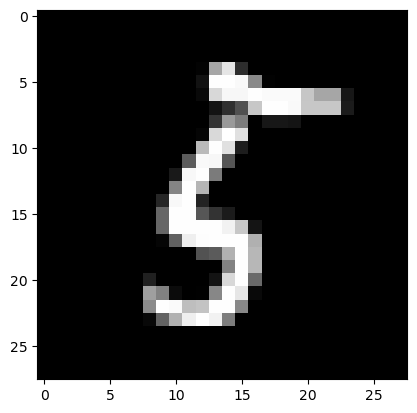

2611


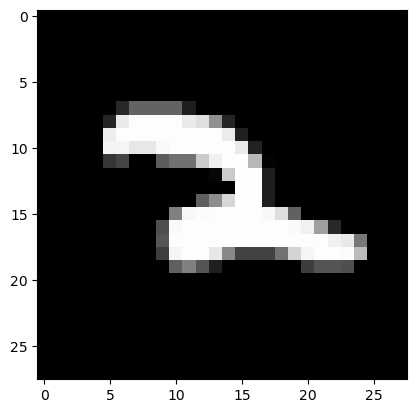

2635


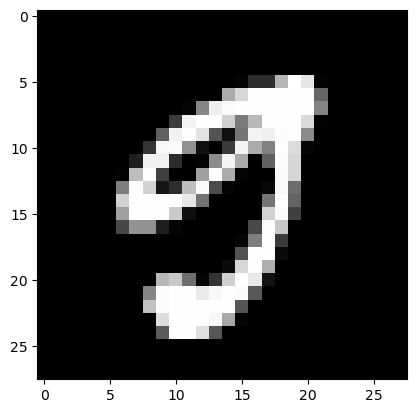

2648


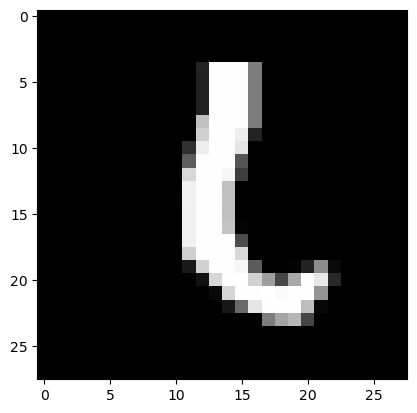

2654


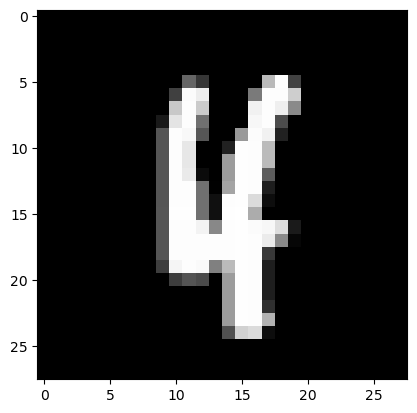

2658


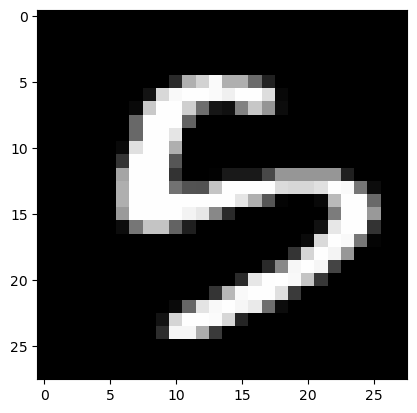

2668


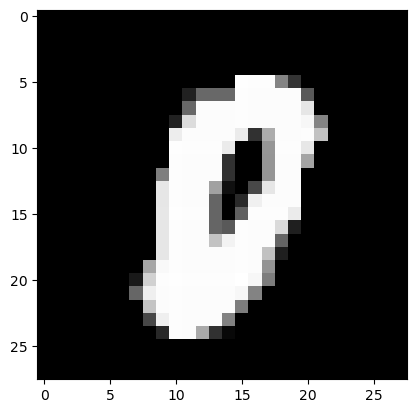

2713


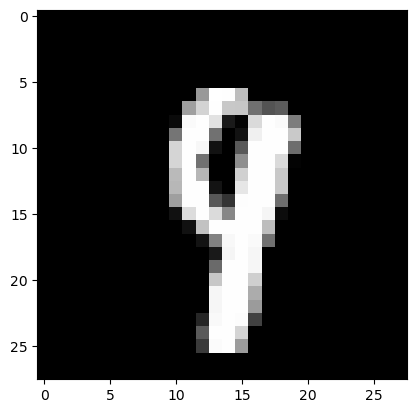

2720


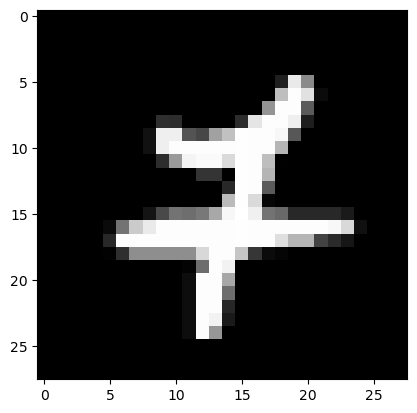

2730


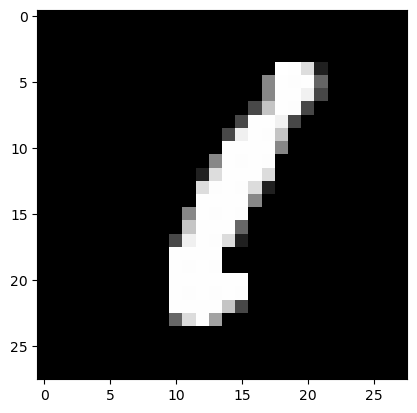

2734


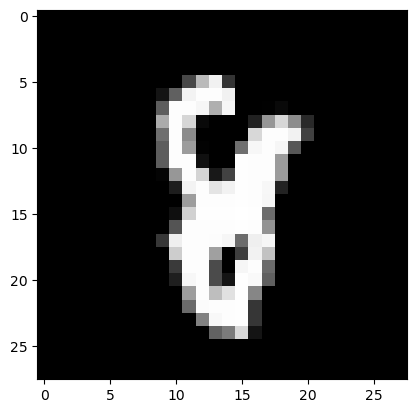

2739


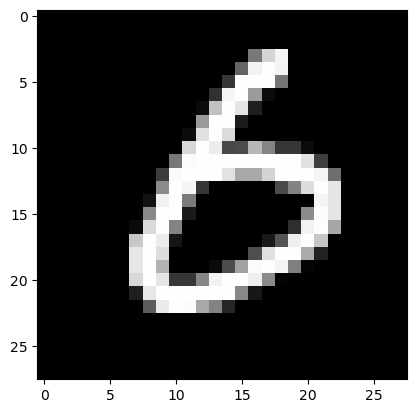

2751


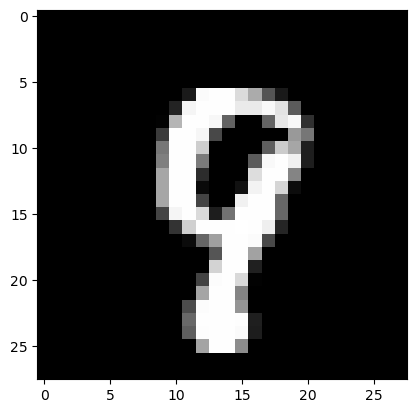

2769


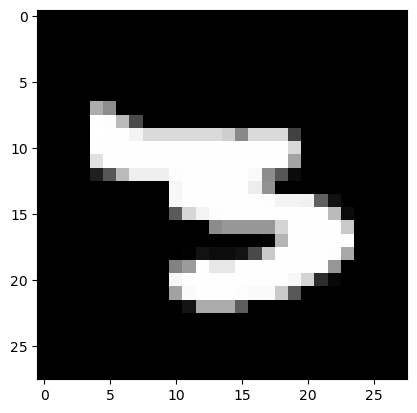

2770


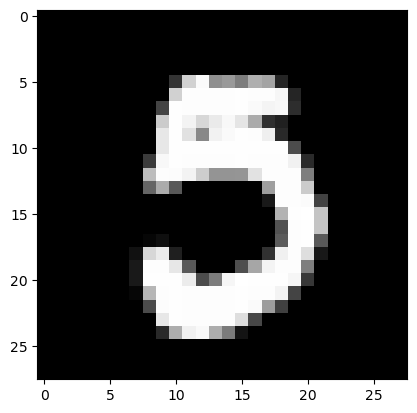

2810


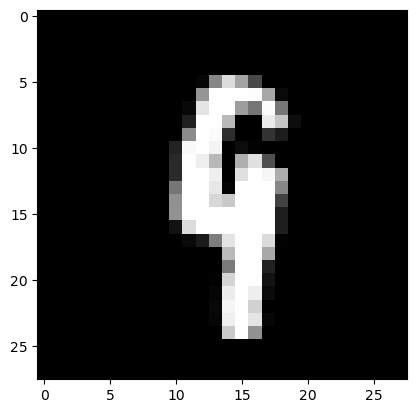

2863


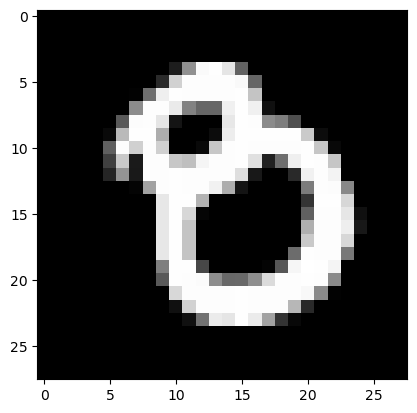

2896


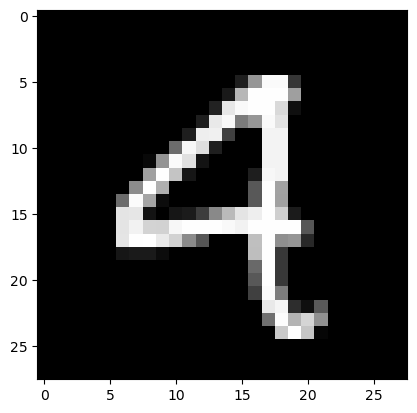

2907


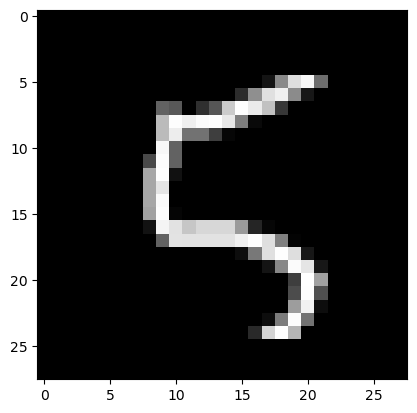

2919


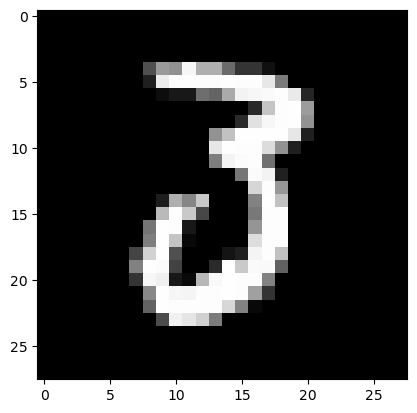

2921


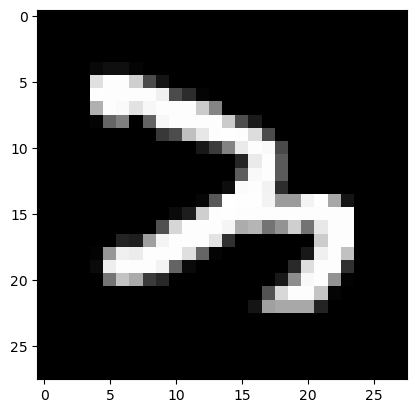

2927


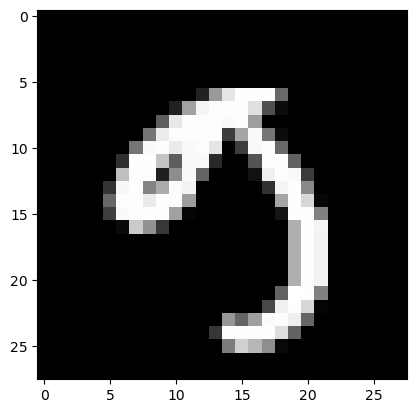

2939


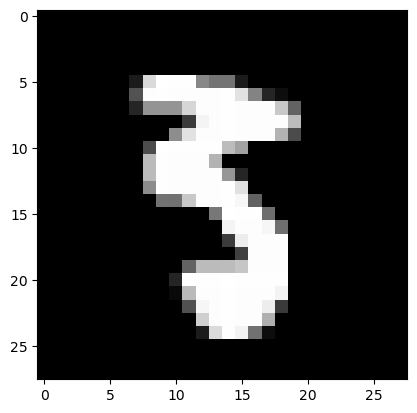

2953


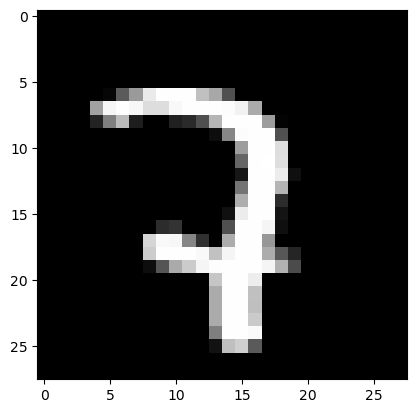

2961


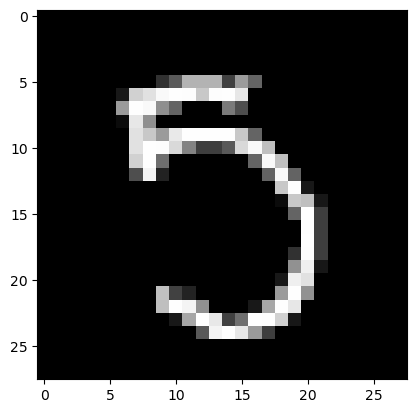

2970


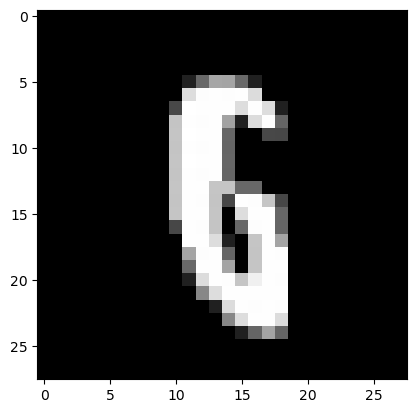

2995


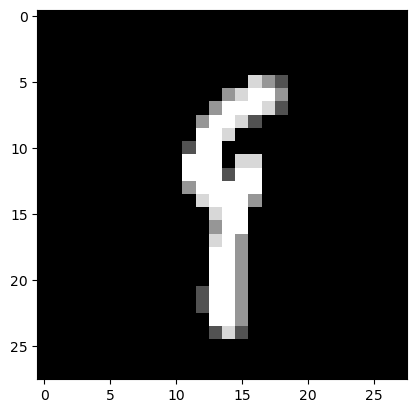

3005


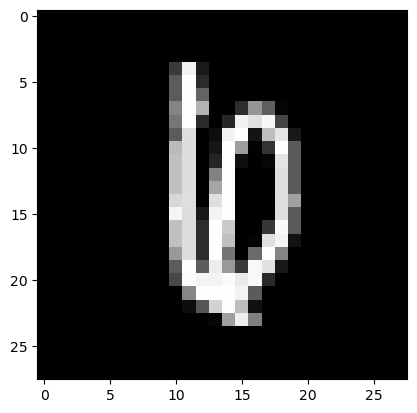

3030


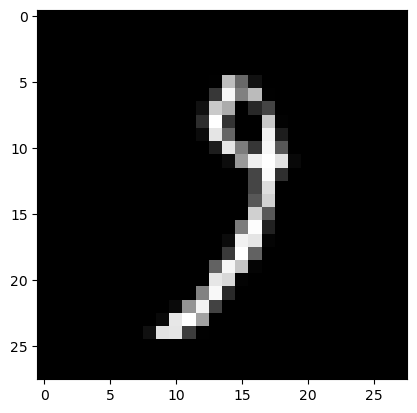

3060


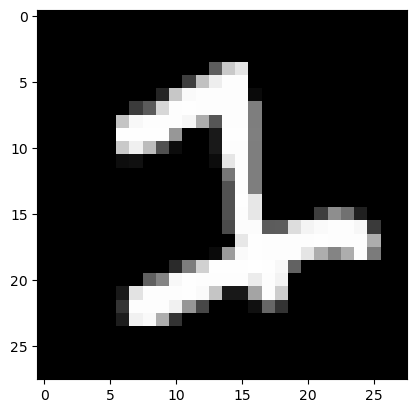

3073


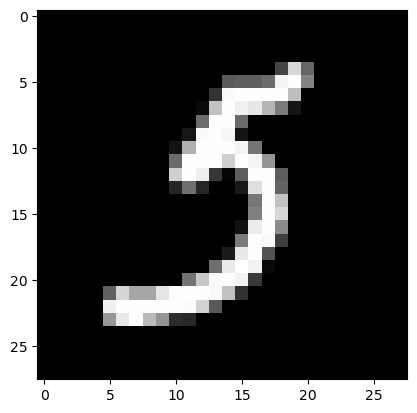

3102


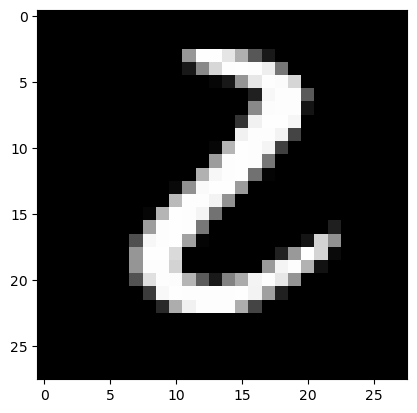

3106


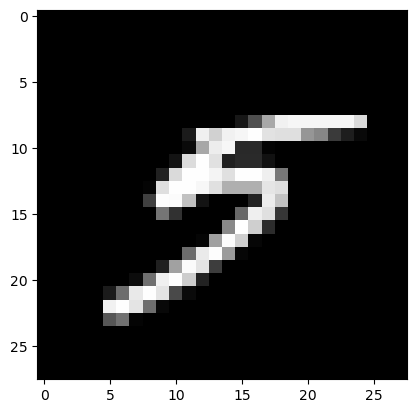

3115


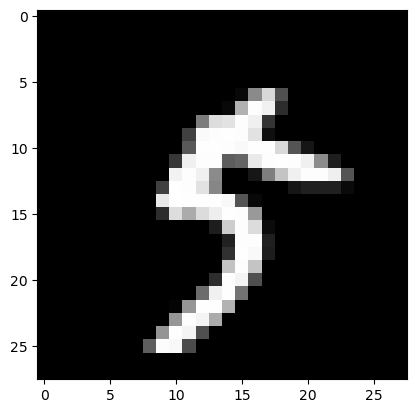

3117


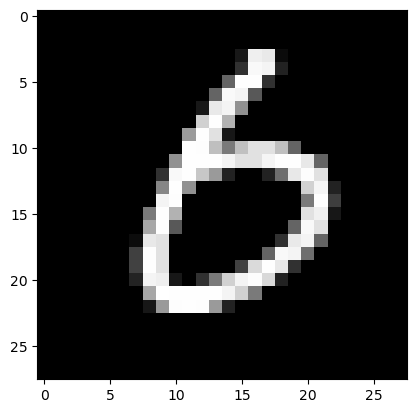

3130


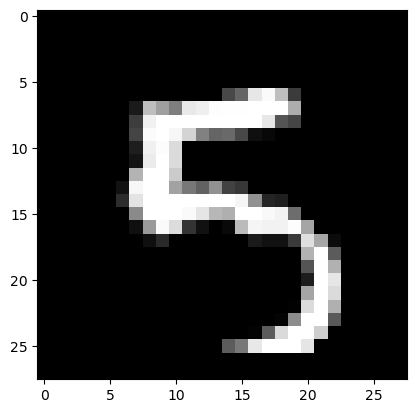

3145


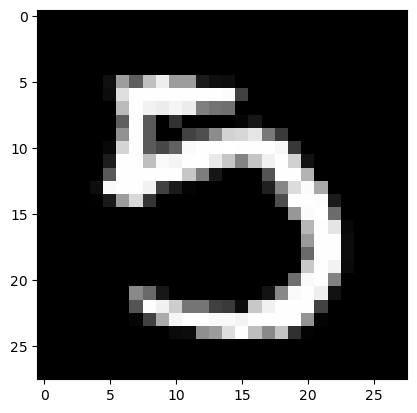

3157


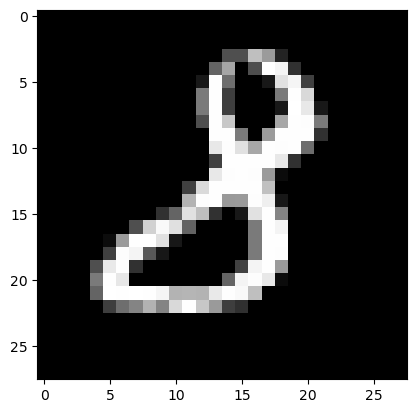

3206


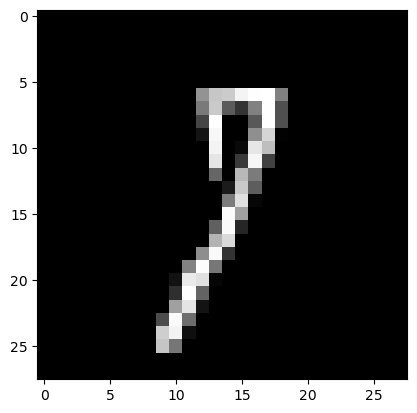

3225


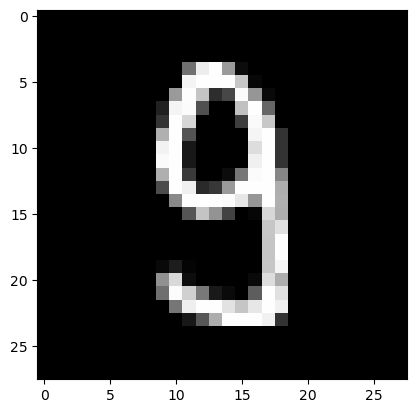

3240


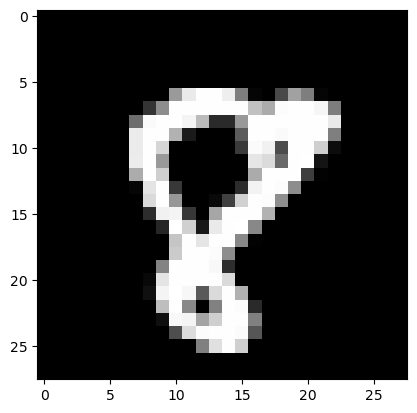

3284


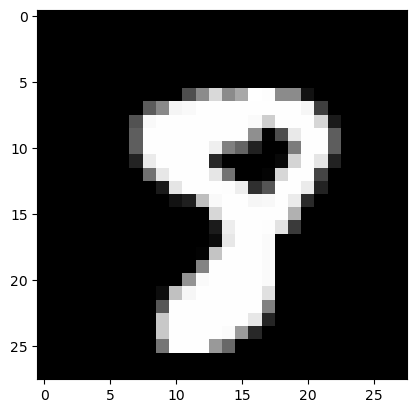

3289


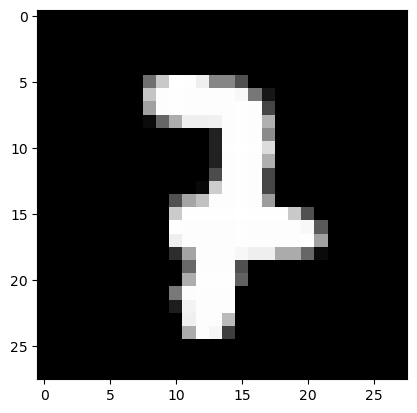

3329


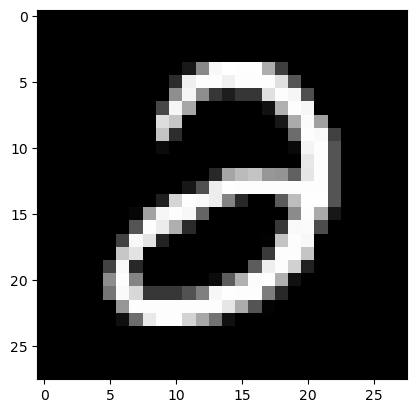

3330


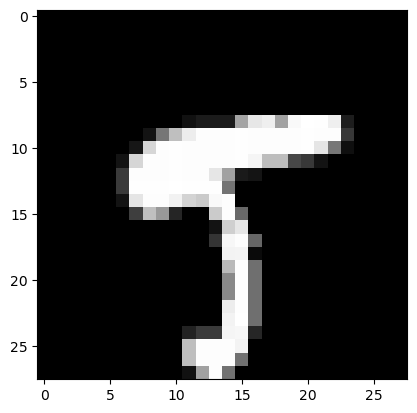

3336


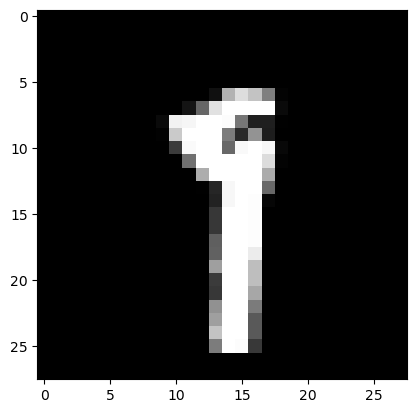

3369


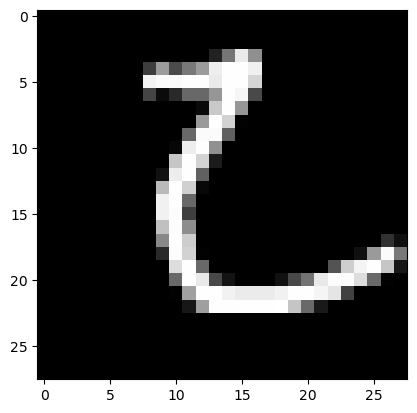

3384


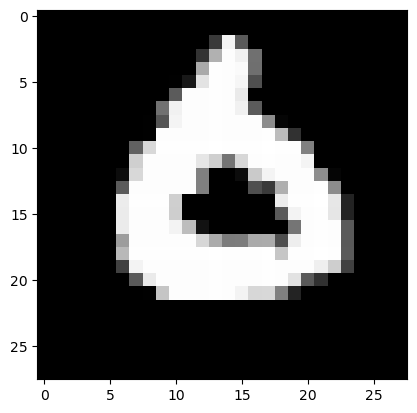

3422


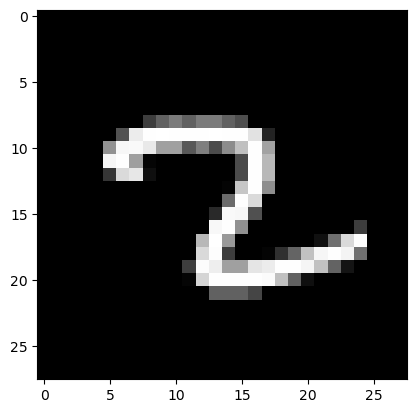

3436


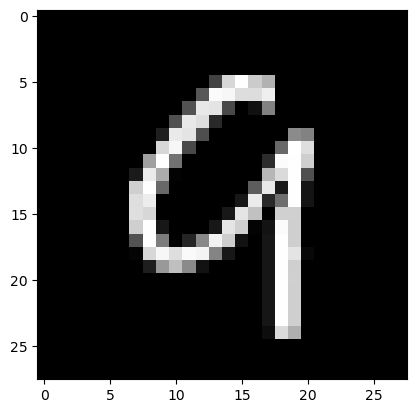

3460


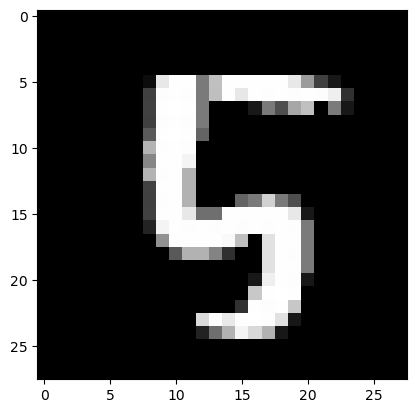

3468


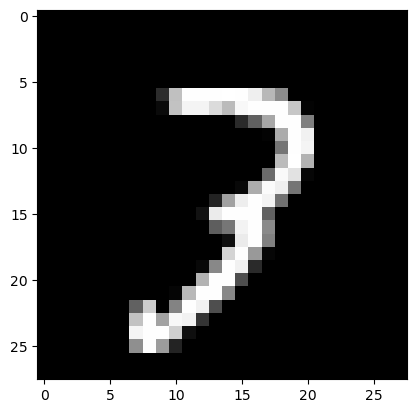

3475


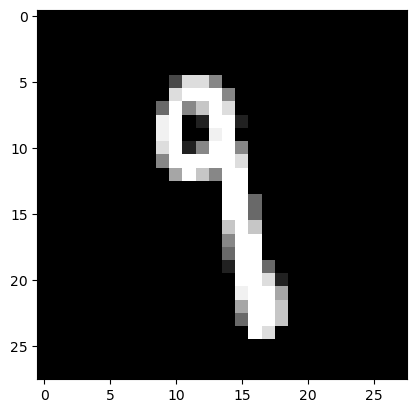

3503


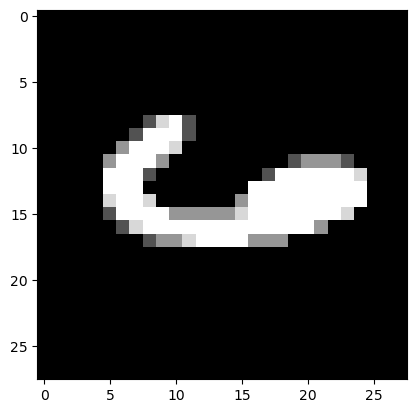

3520


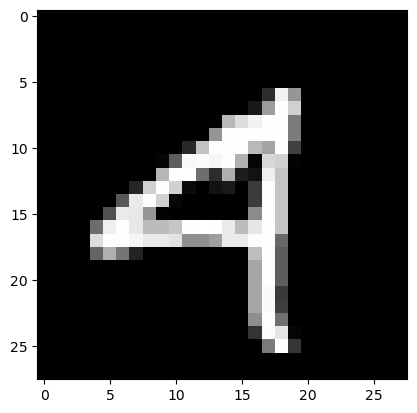

3533


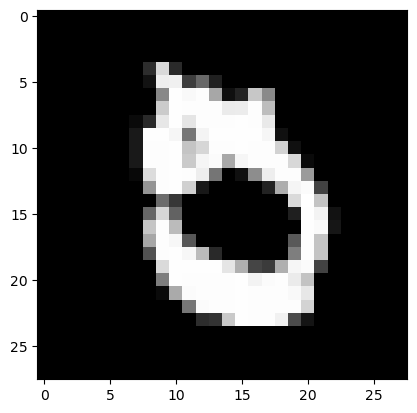

3558


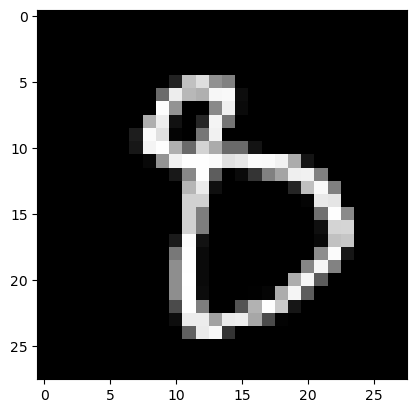

3559


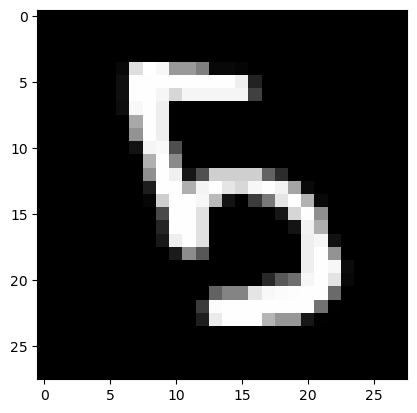

3565


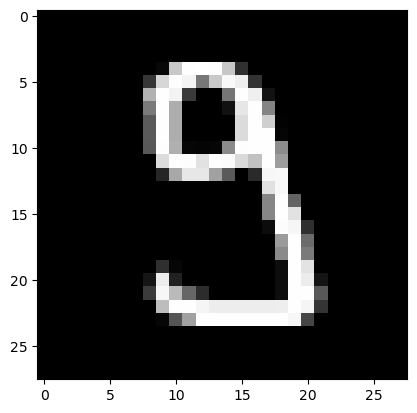

3597


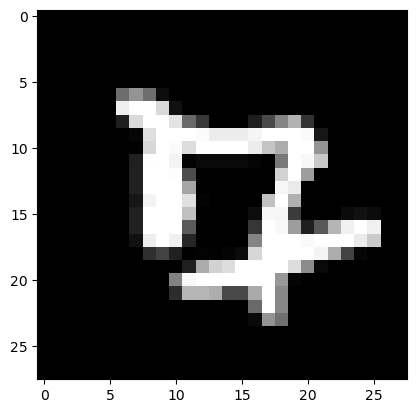

3604


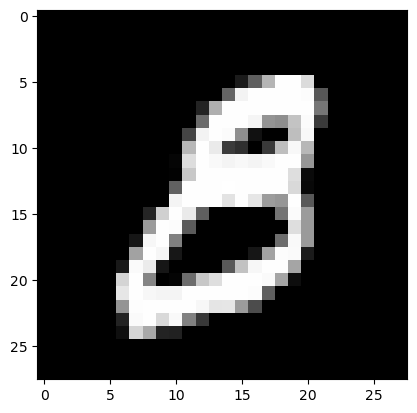

3629


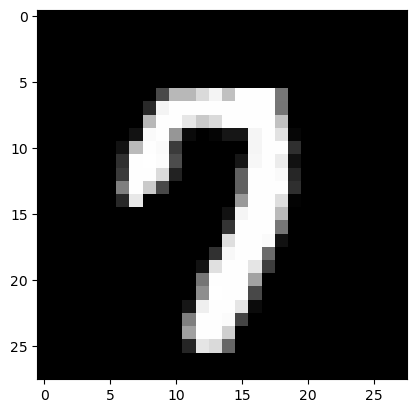

3667


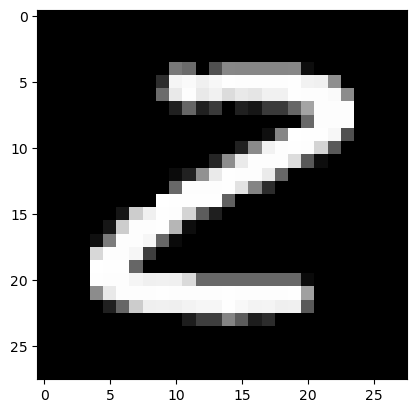

3681


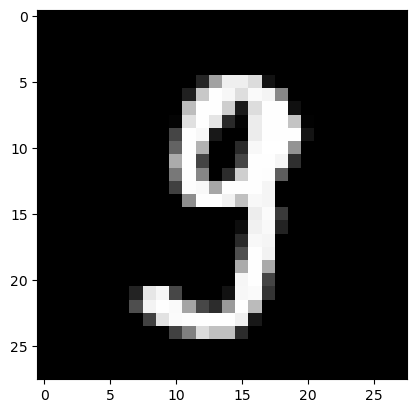

3716


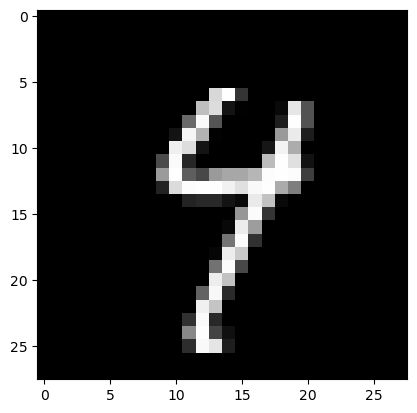

3718


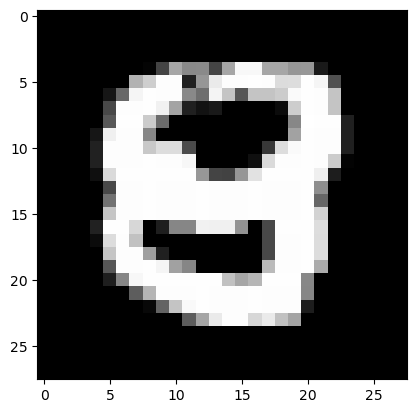

3727


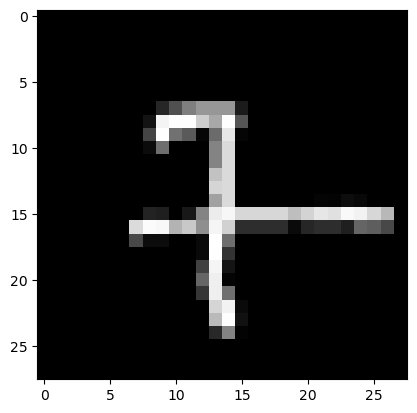

3751


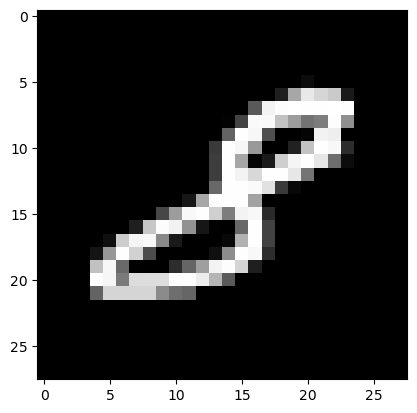

3757


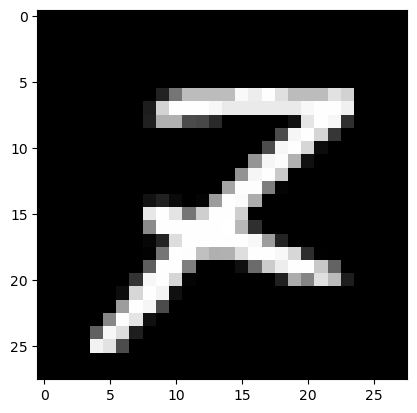

3767


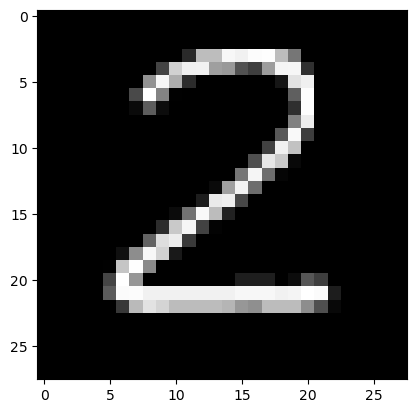

3773


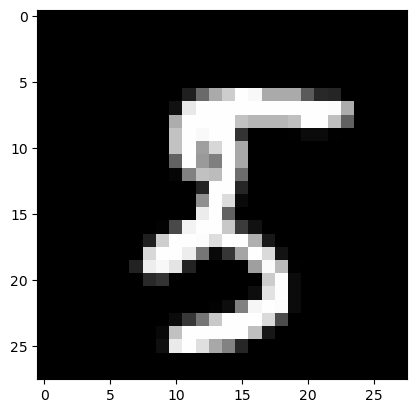

3776


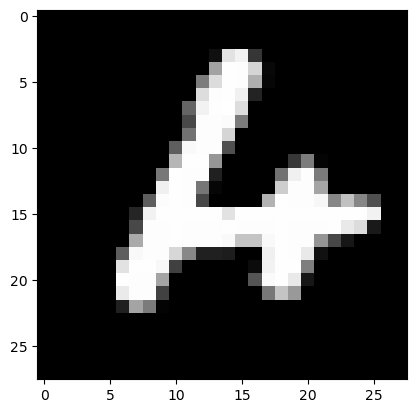

3780


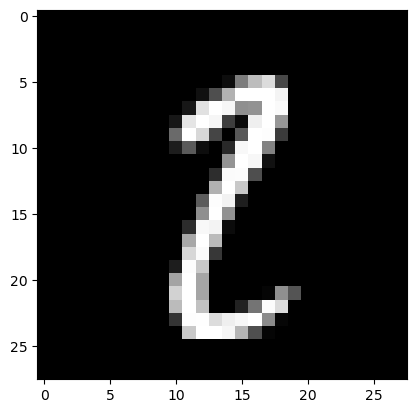

3796


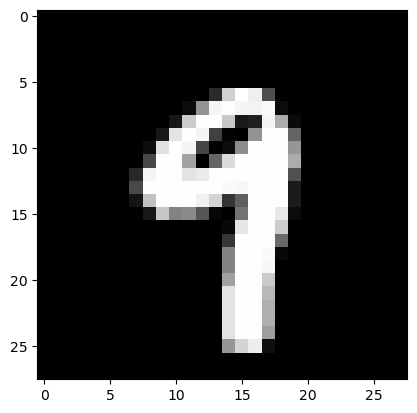

3798


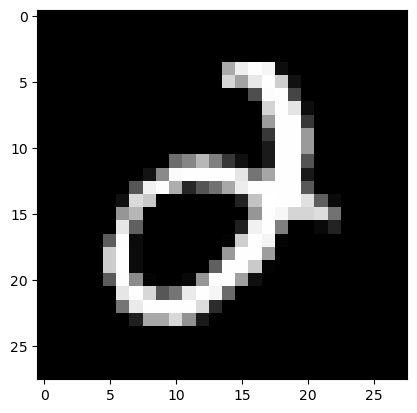

3811


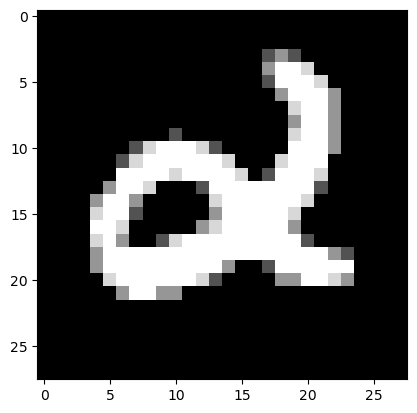

3817


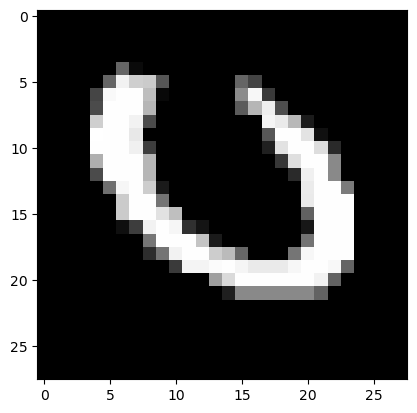

3818


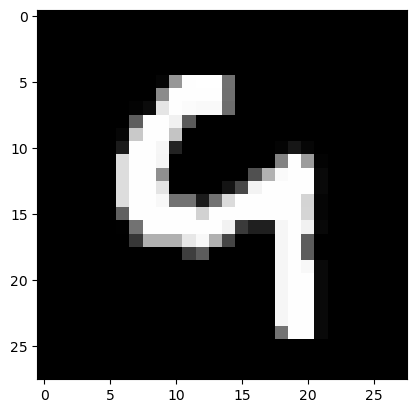

3821


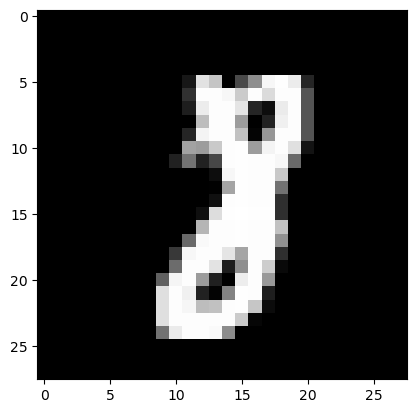

3833


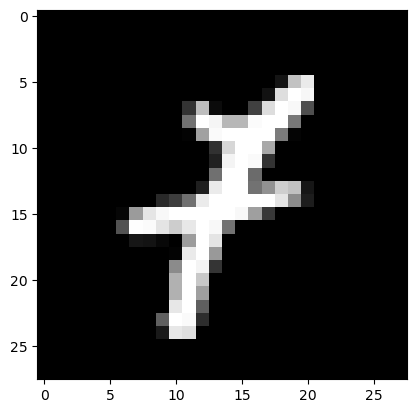

3838


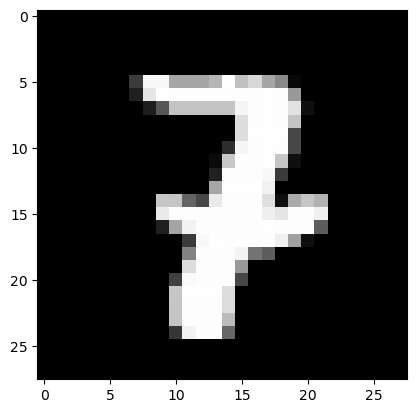

3848


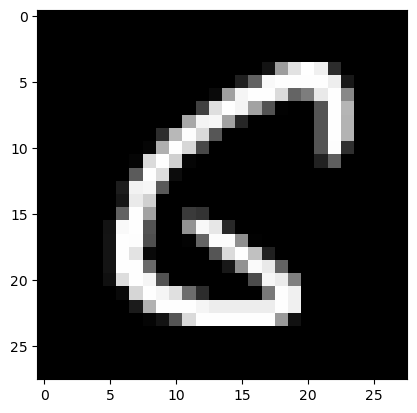

3853


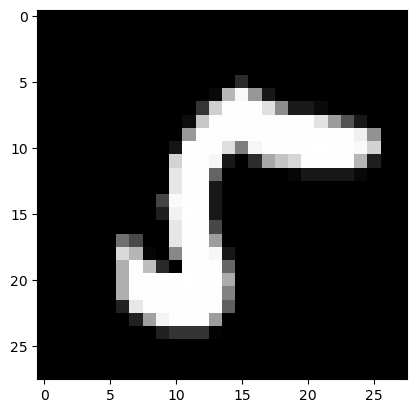

3855


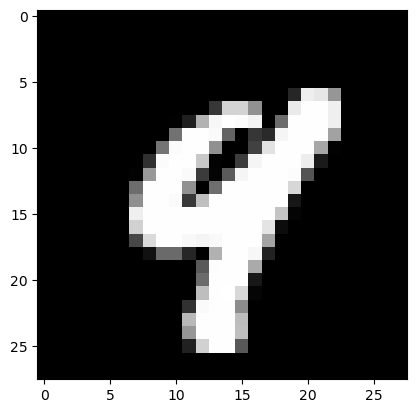

3869


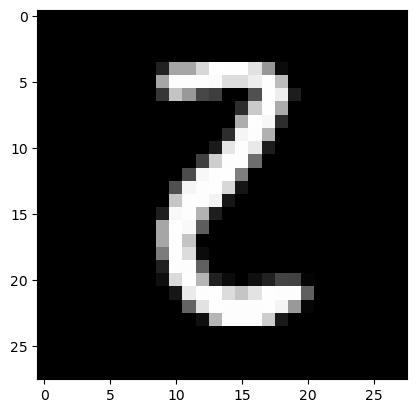

3876


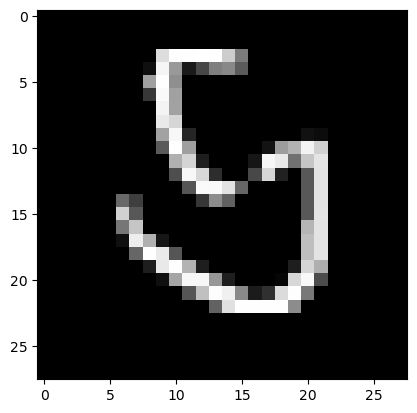

3893


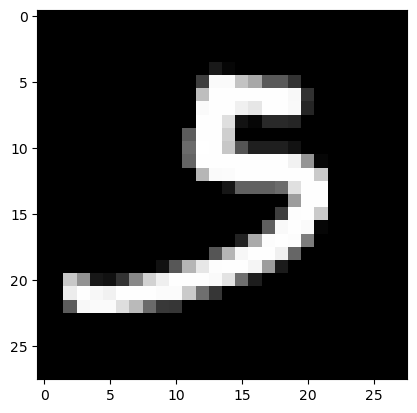

3902


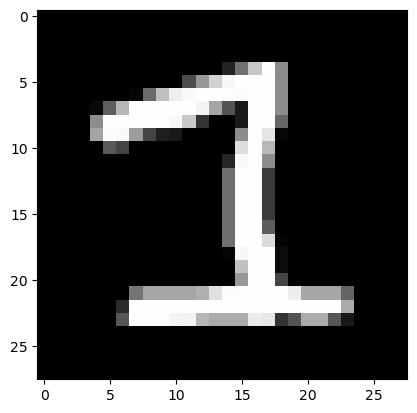

3906


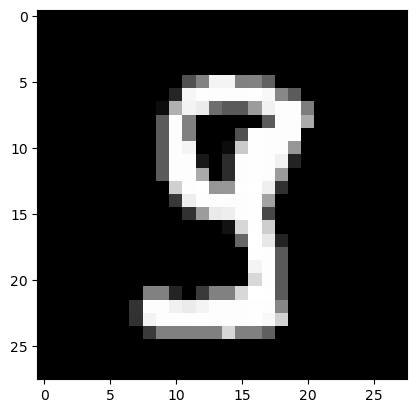

3926


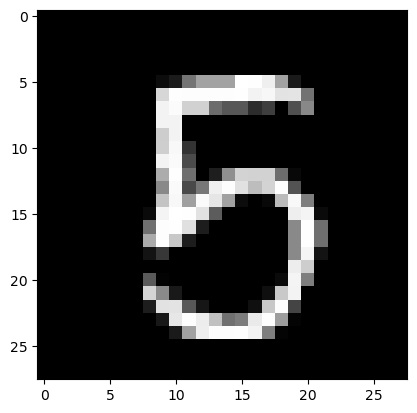

3929


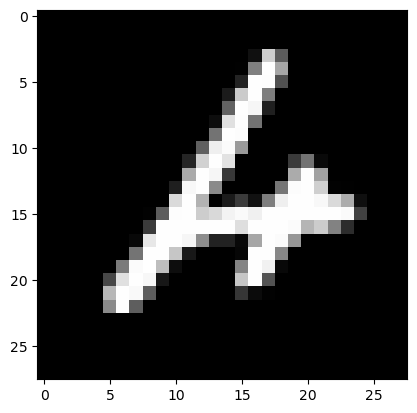

3941


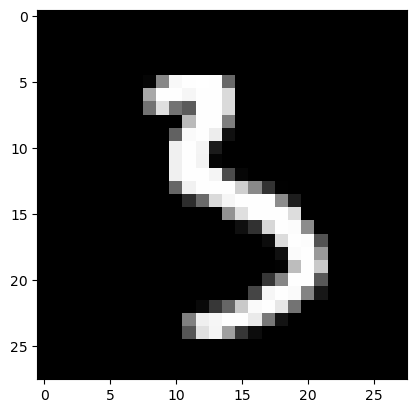

3943


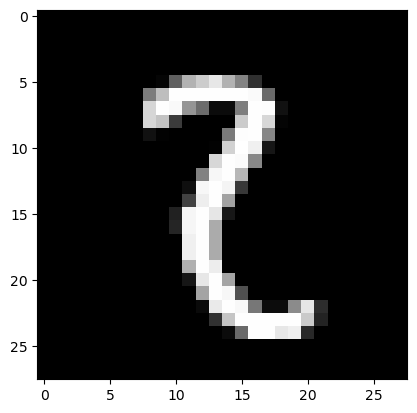

3946


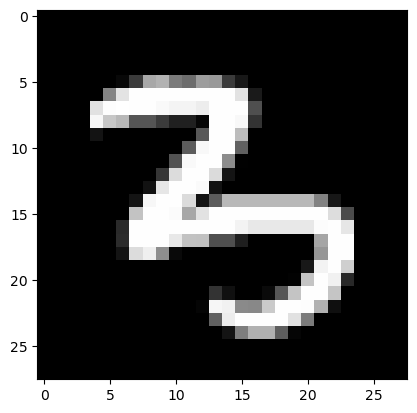

3962


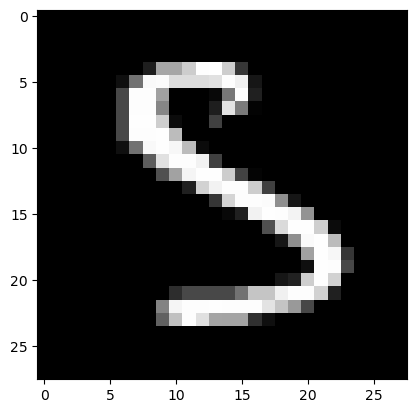

3968


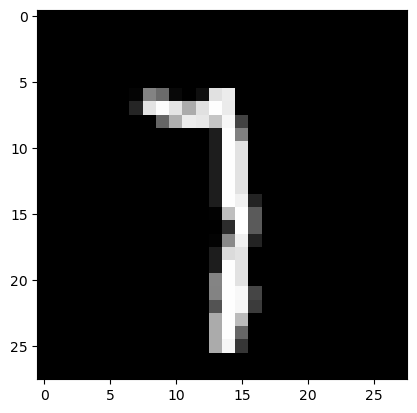

3976


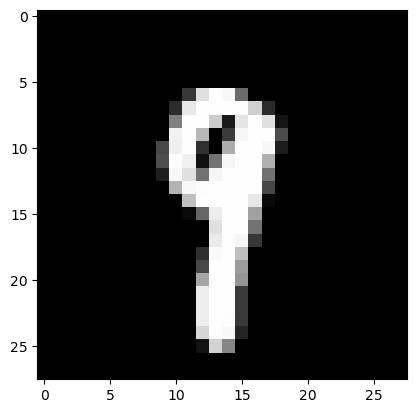

3984


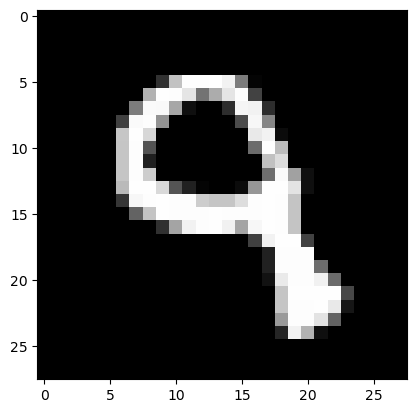

4000


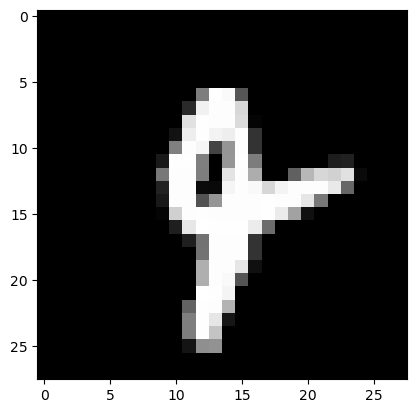

4017


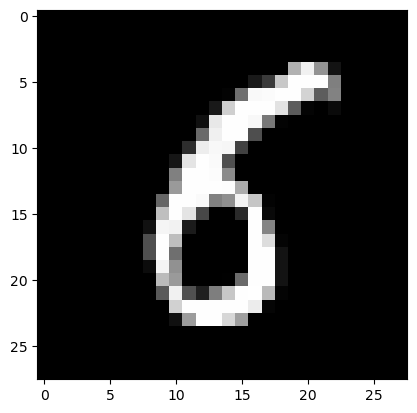

4063


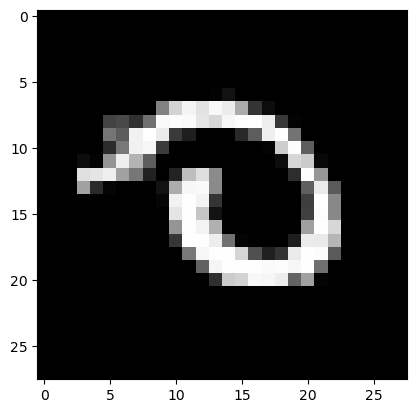

4065


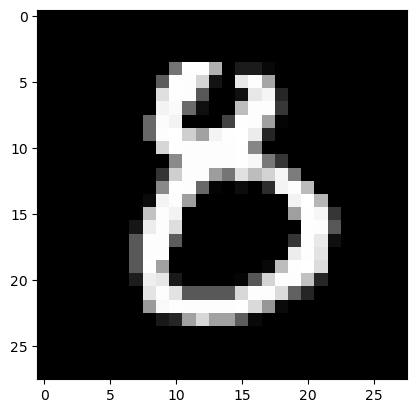

4075


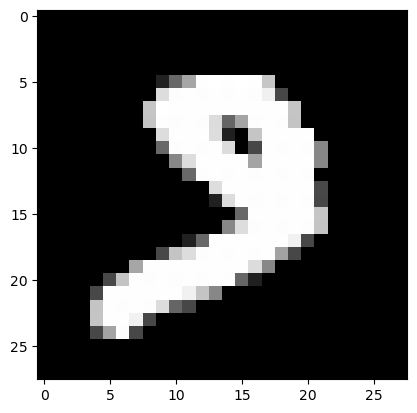

4078


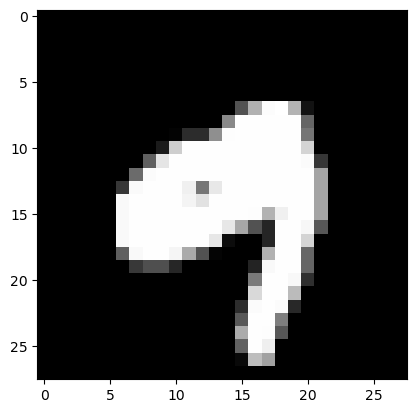

4093


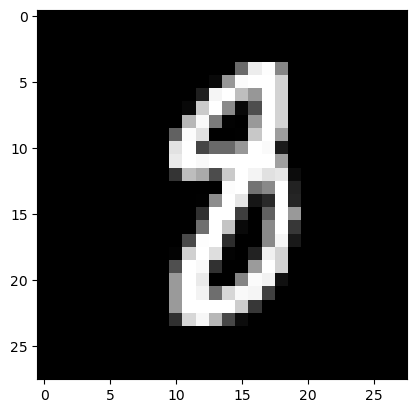

4126


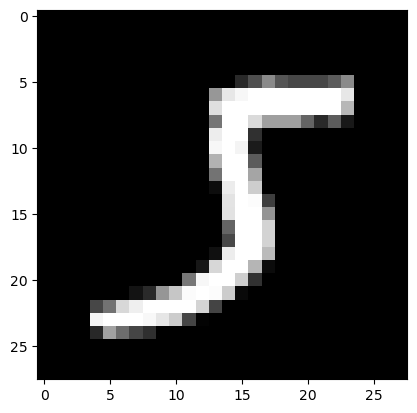

4131


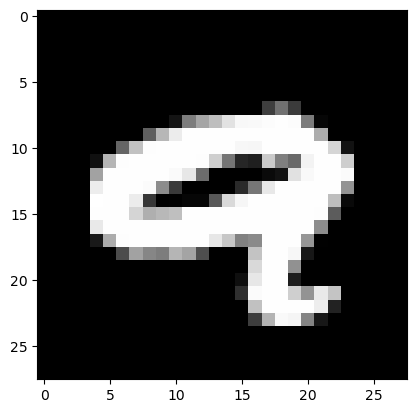

4154


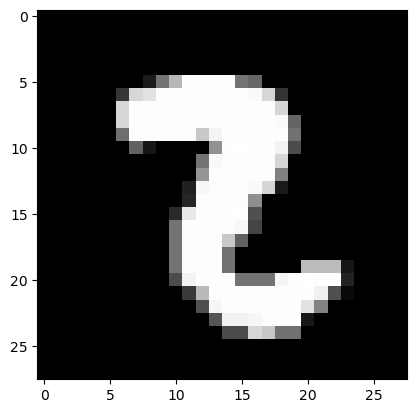

4156


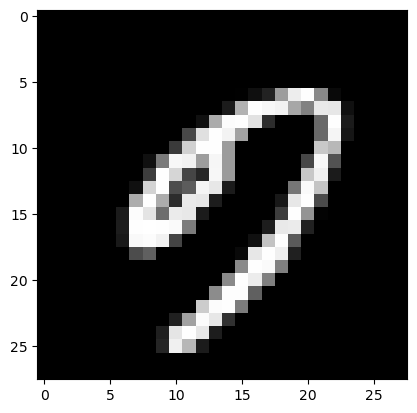

4163


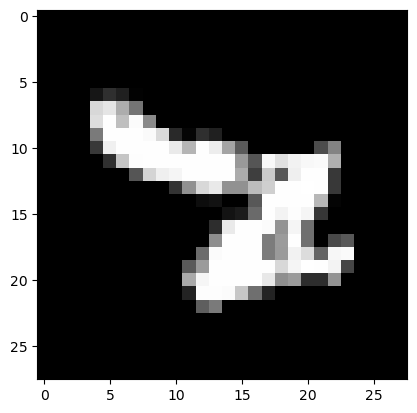

4176


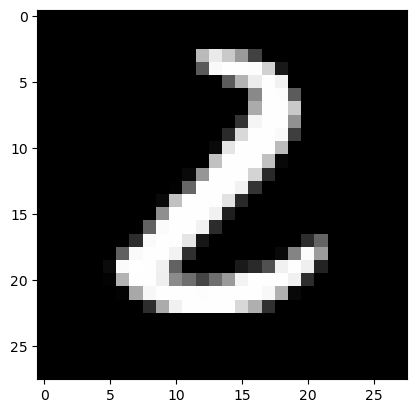

4180


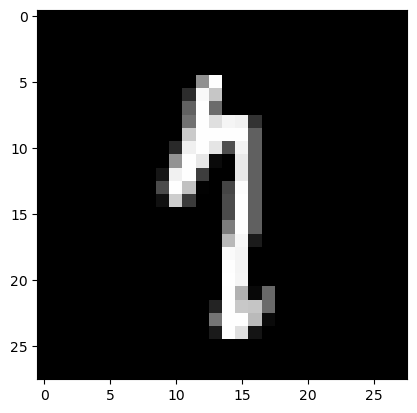

4201


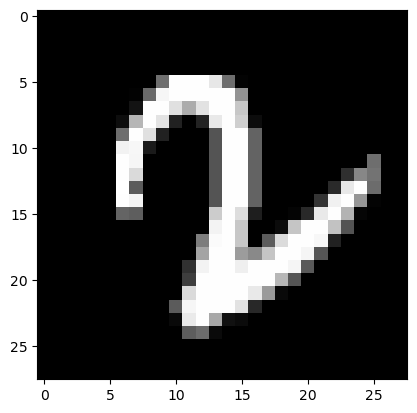

4205


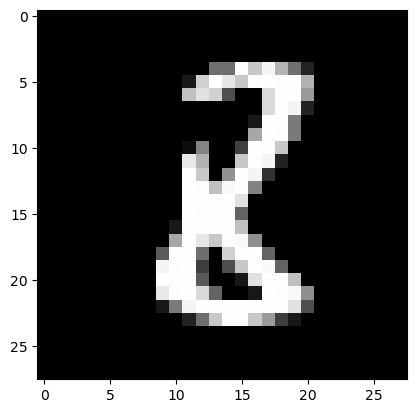

4207


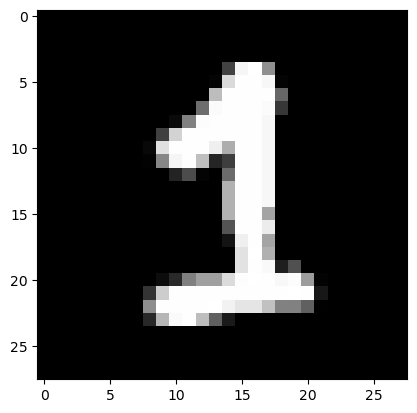

4212


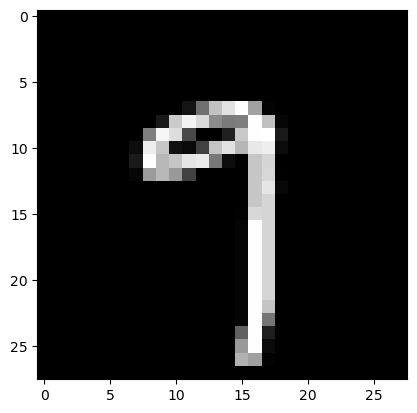

4224


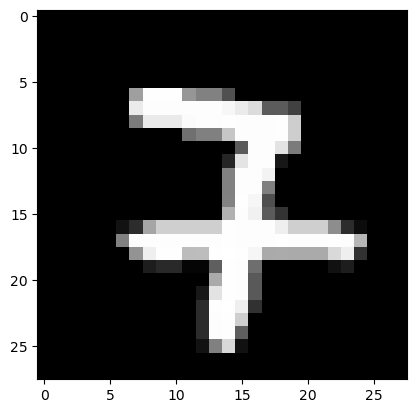

4228


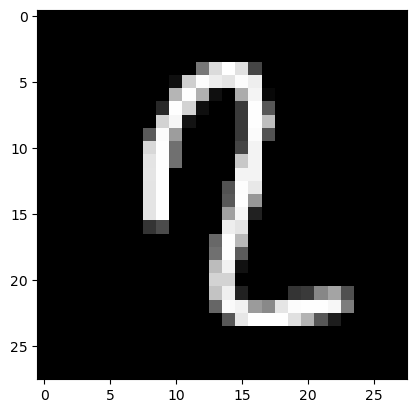

4248


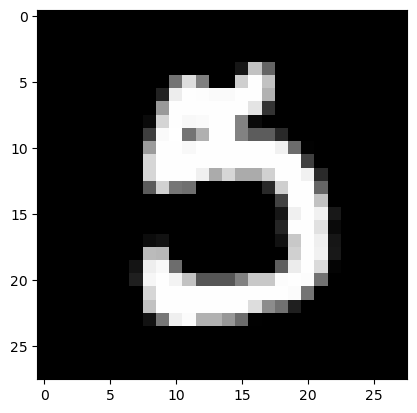

4255


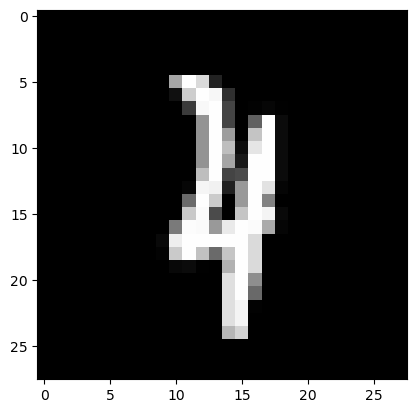

4265


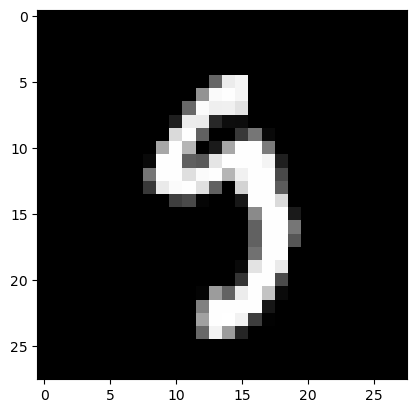

4284


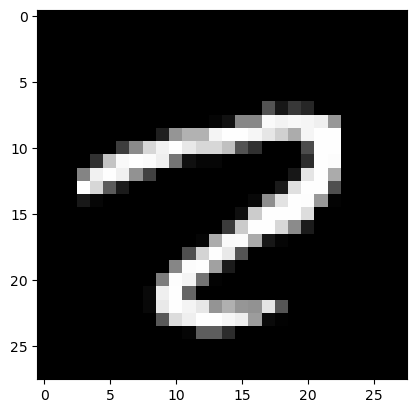

4289


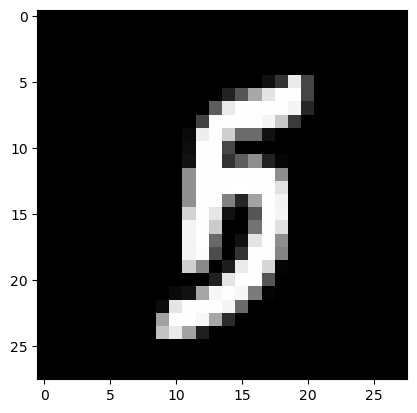

4300


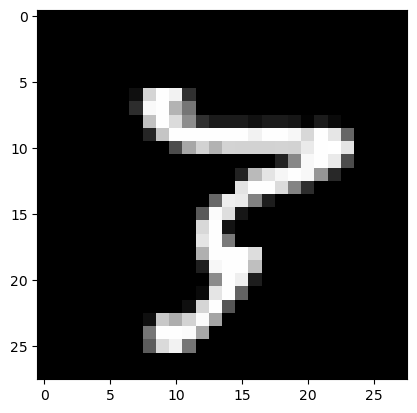

4306


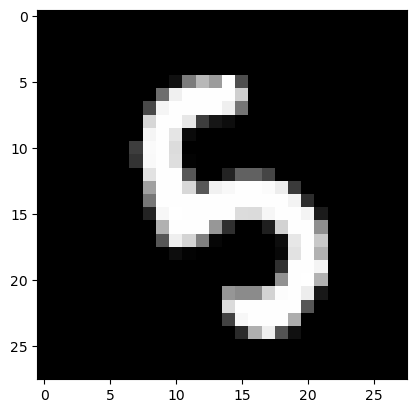

4315


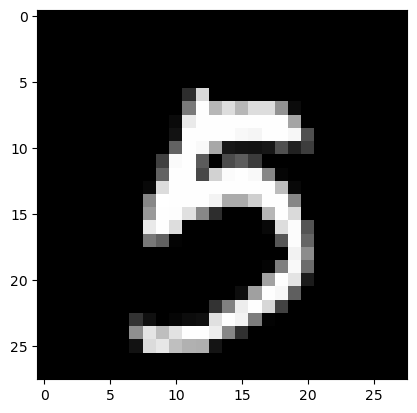

4355


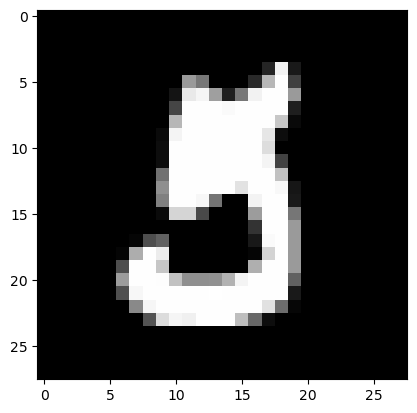

4360


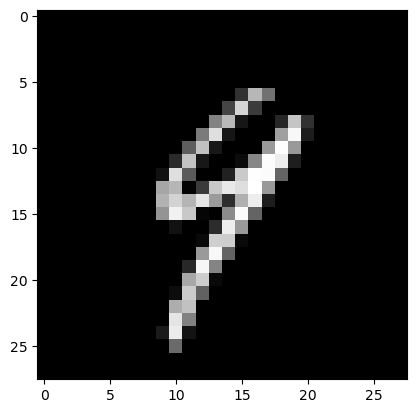

4369


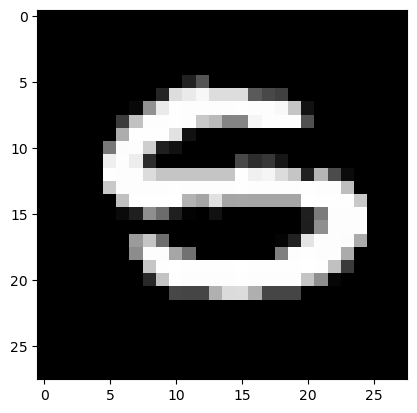

4374


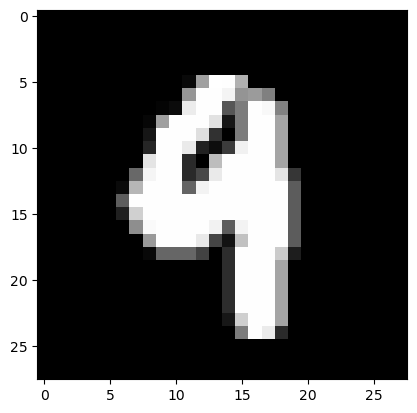

4425


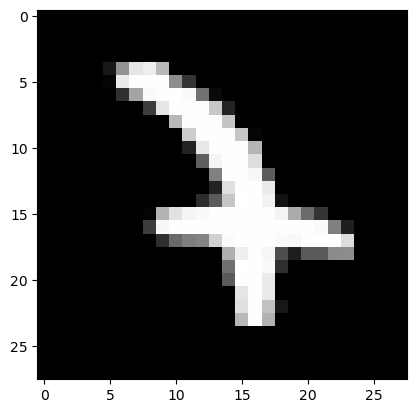

4433


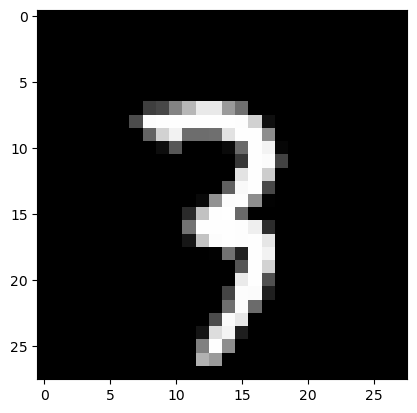

4435


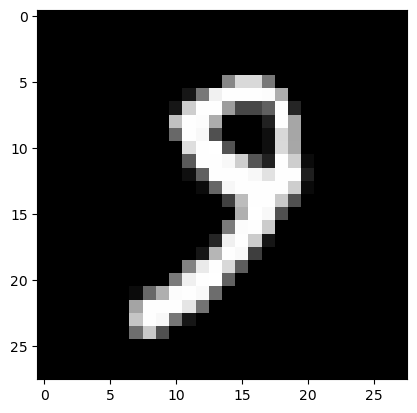

4454


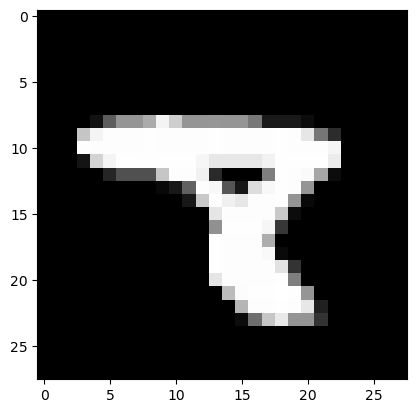

4497


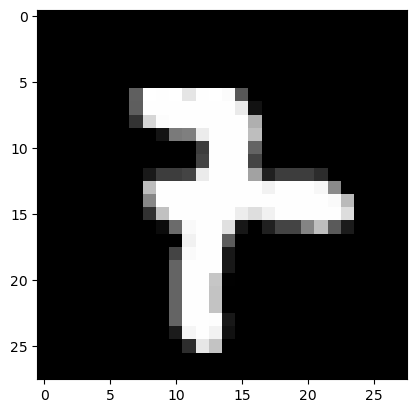

4498


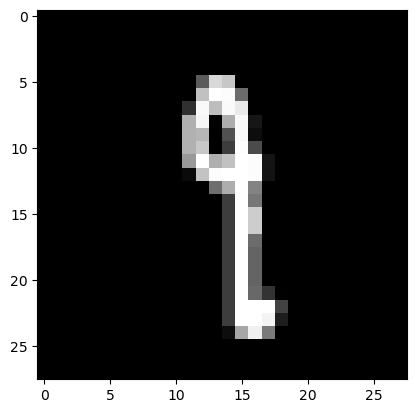

4500


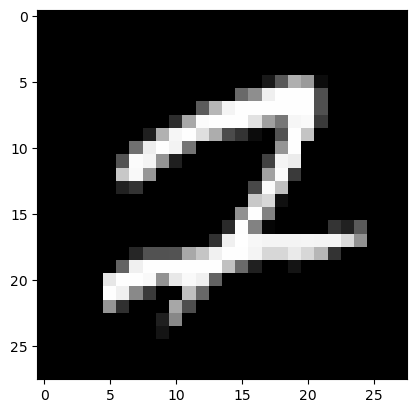

4504


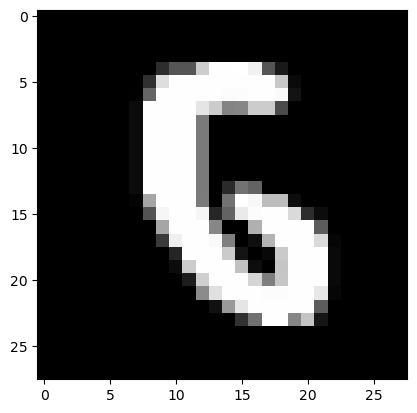

4536


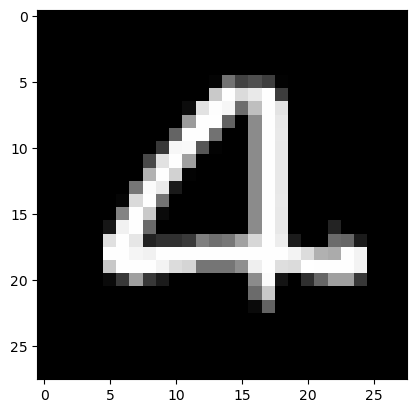

4575


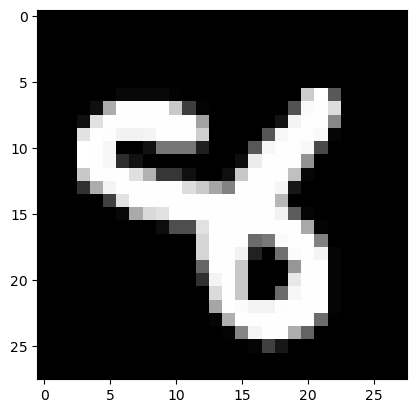

4601


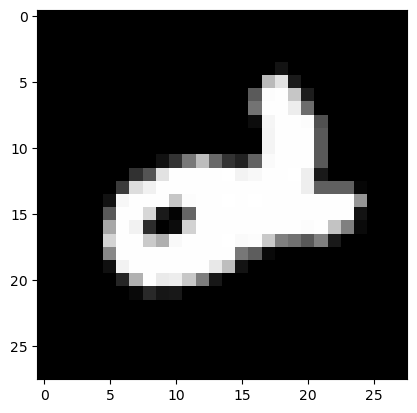

4615


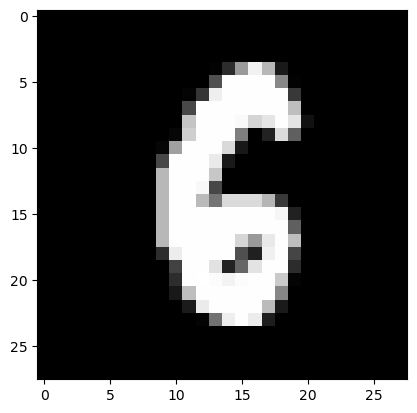

4619


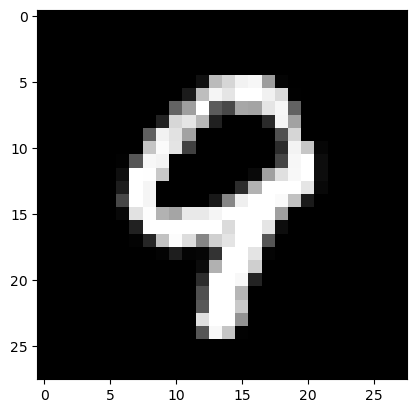

4673


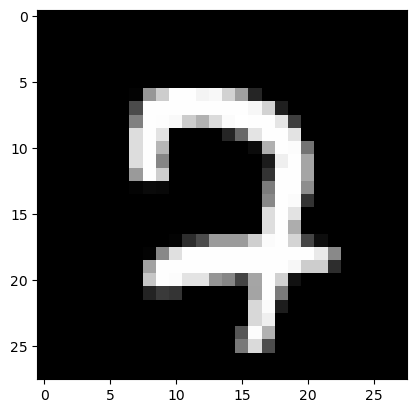

4690


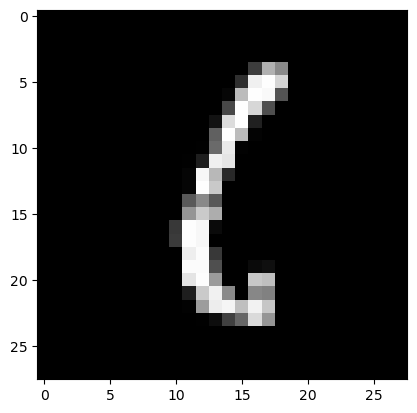

4699


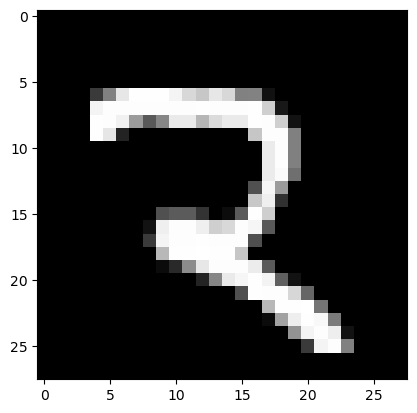

4723


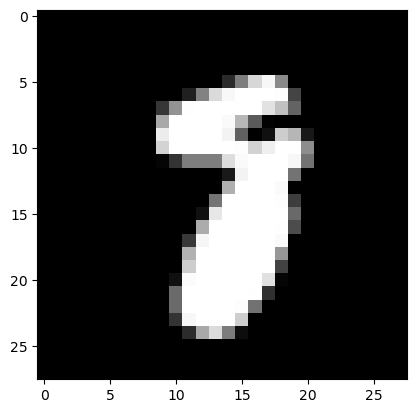

4731


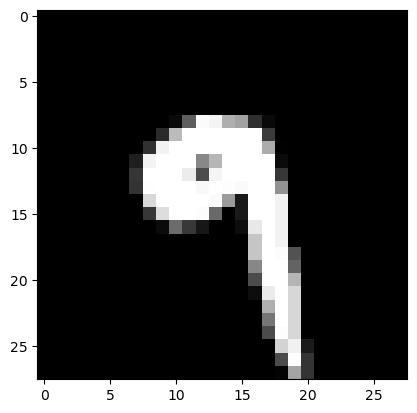

4735


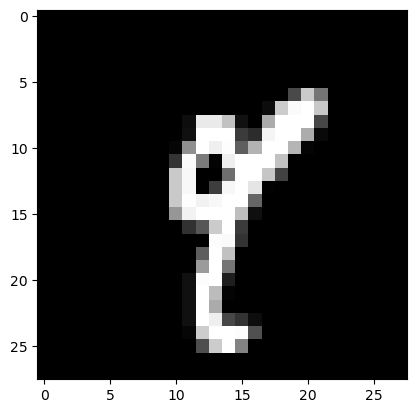

4761


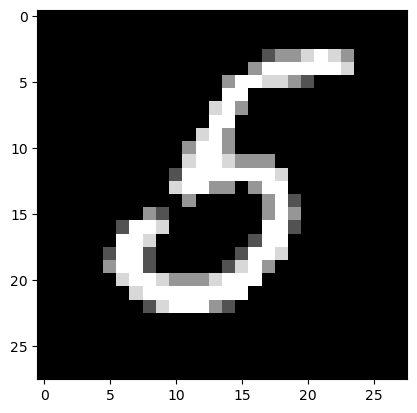

4763


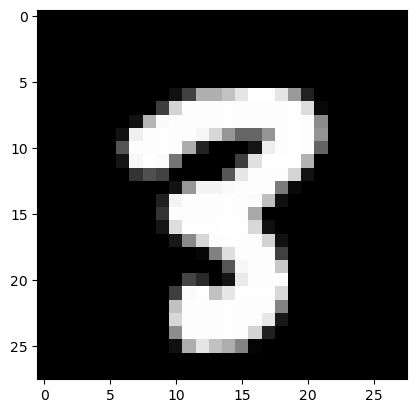

4785


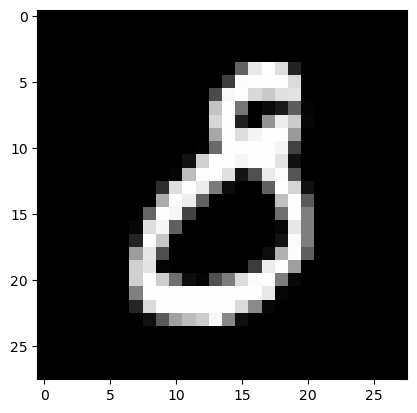

4807


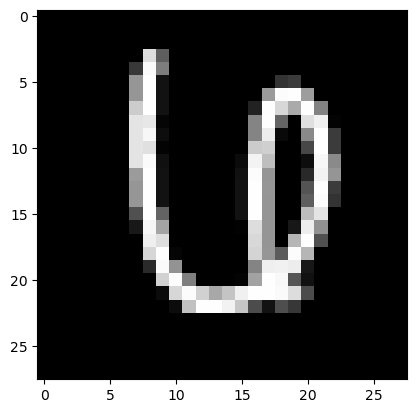

4814


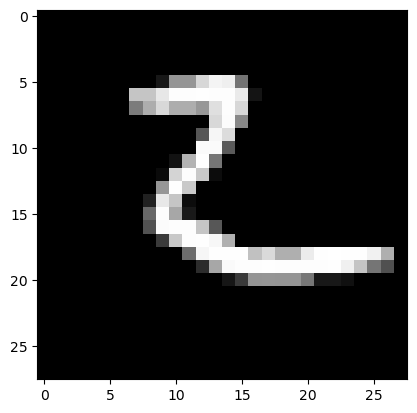

4816


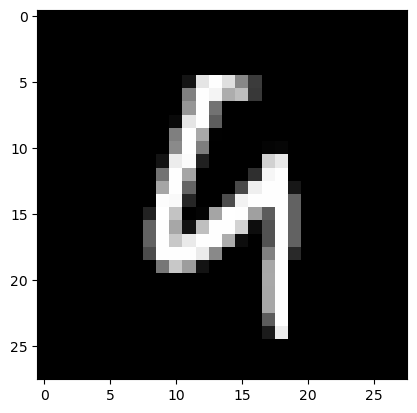

4823


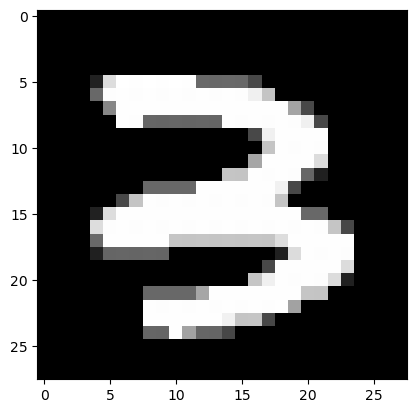

4833


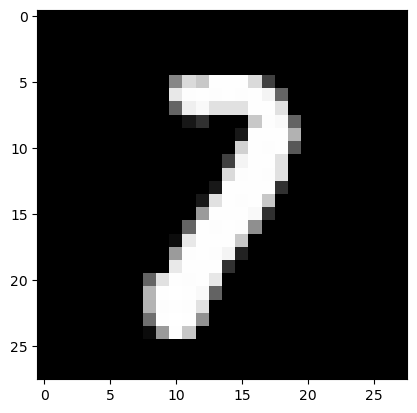

4837


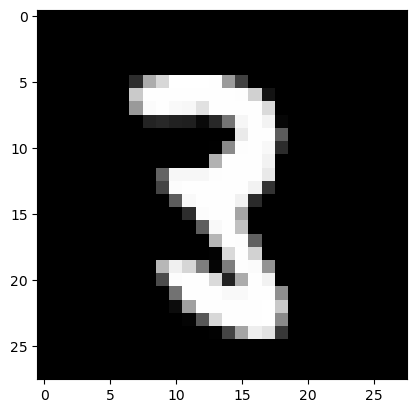

4841


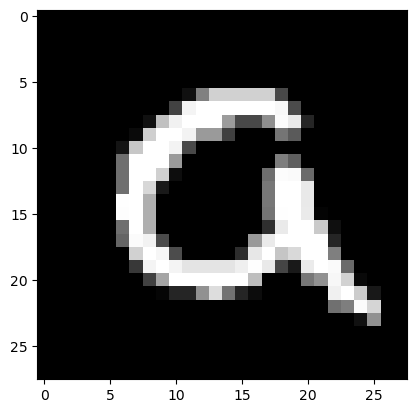

4874


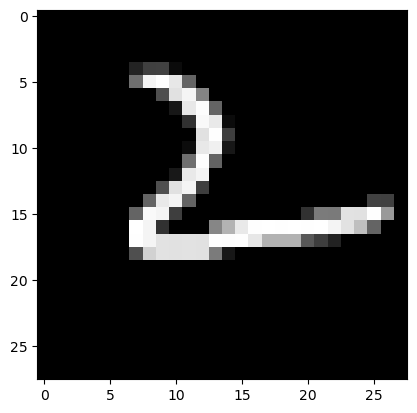

4876


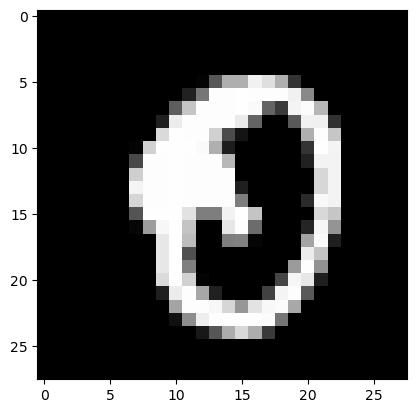

4880


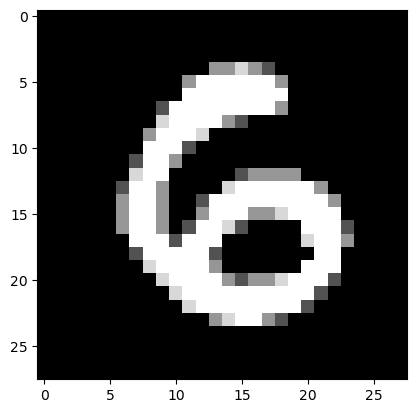

4882


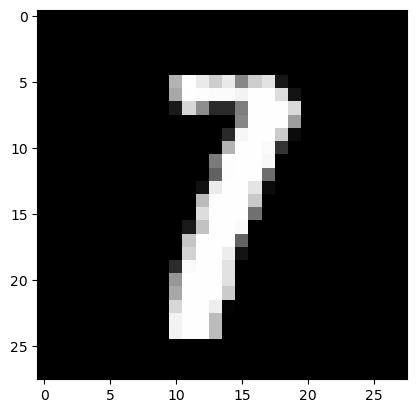

4886


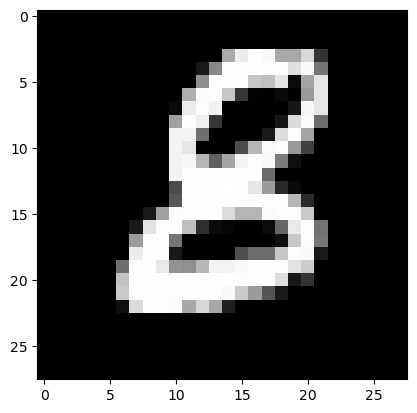

4890


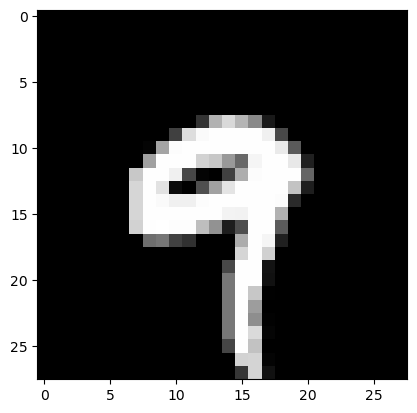

4910


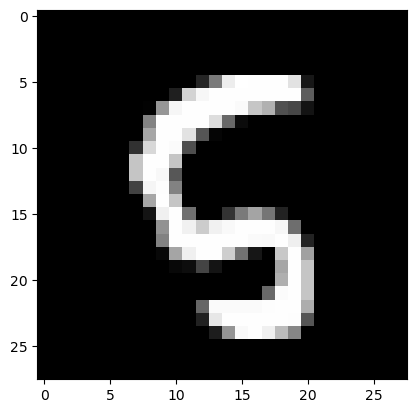

4915


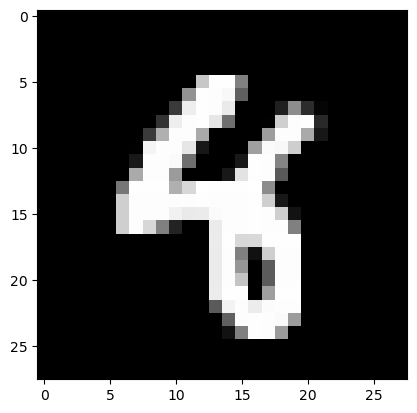

4956


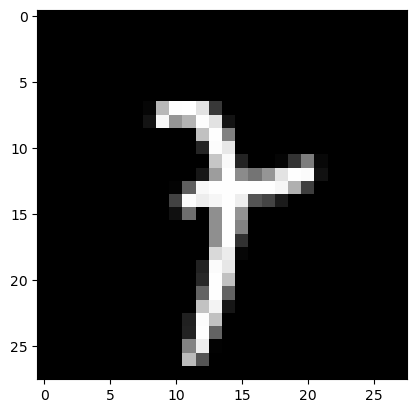

4966


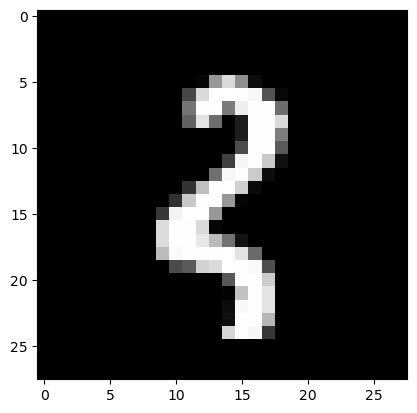

4990


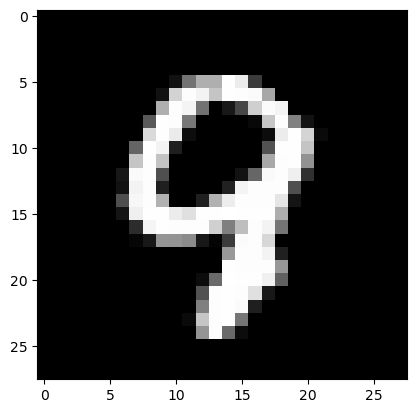

5015


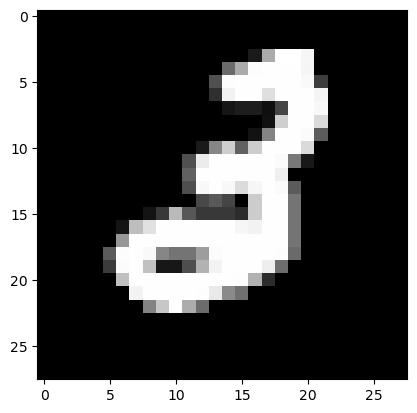

5067


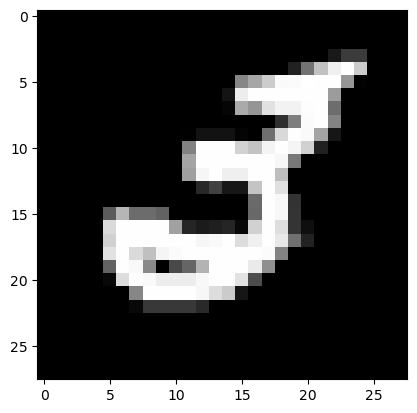

5140


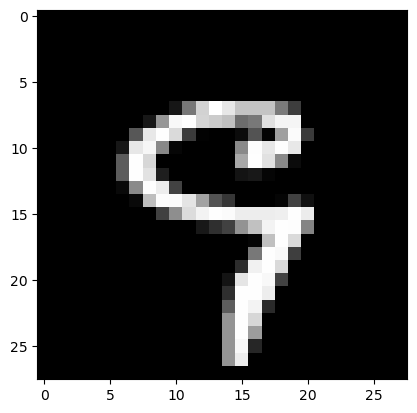

5210


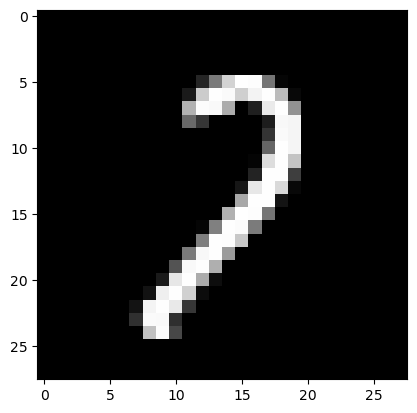

5246


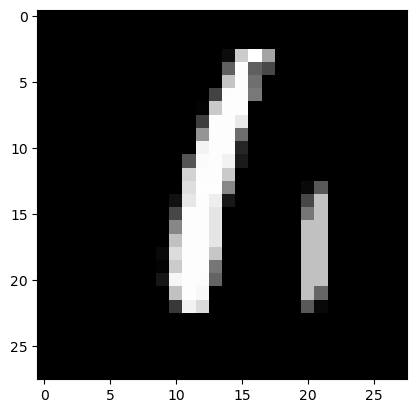

5331


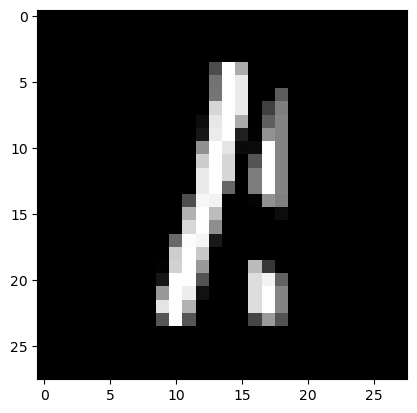

5457


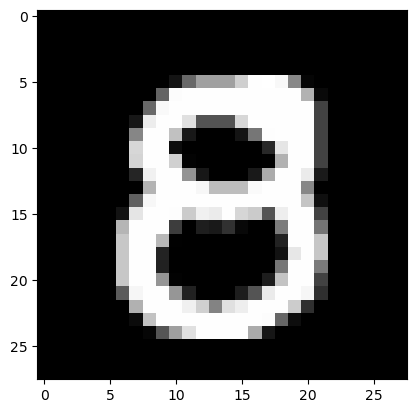

5569


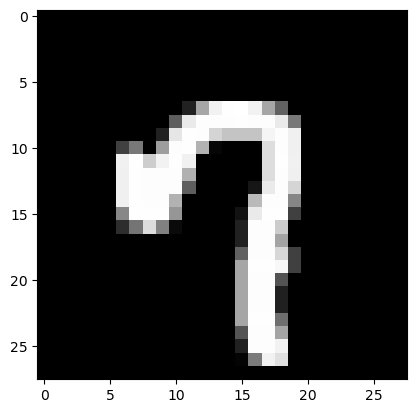

5620


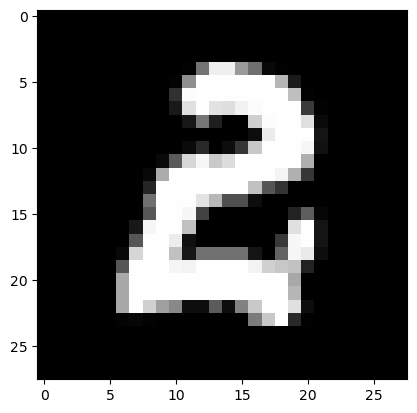

5634


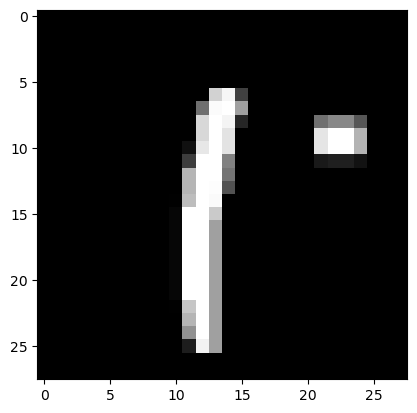

5642


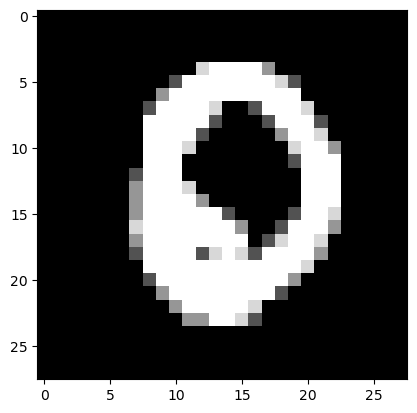

5653


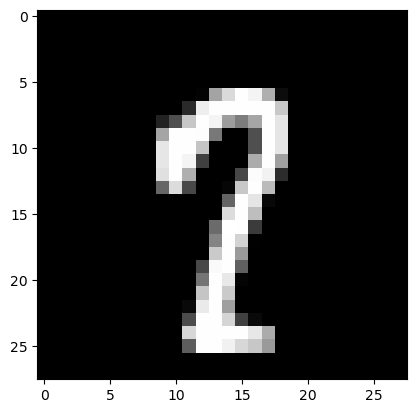

5654


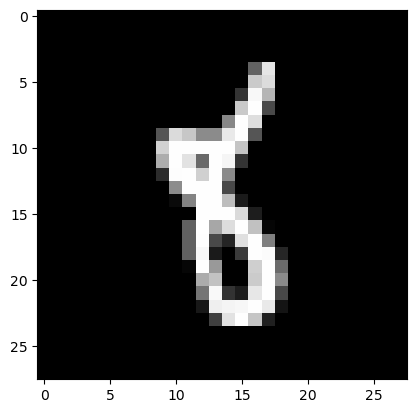

5678


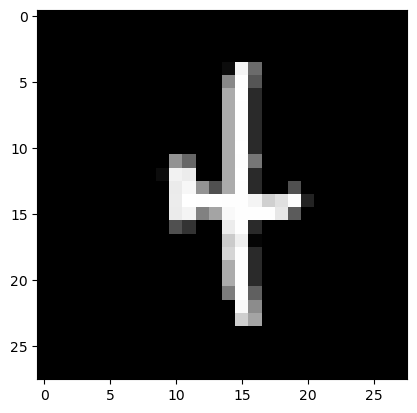

5720


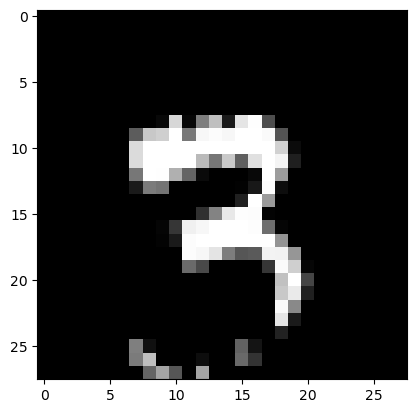

5734


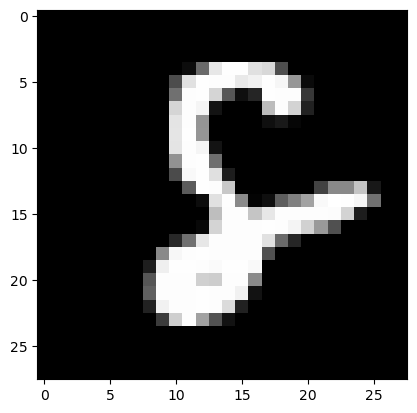

5749


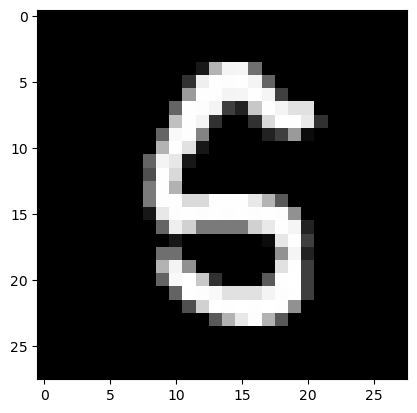

5769


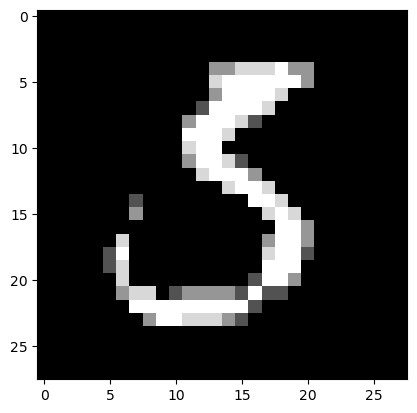

5821


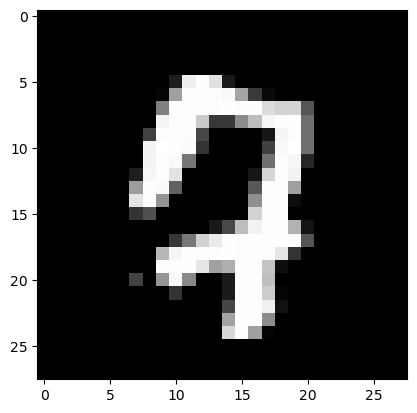

5835


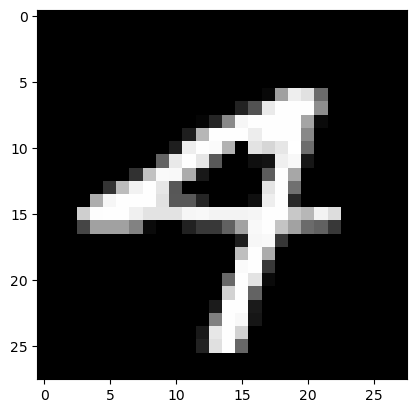

5842


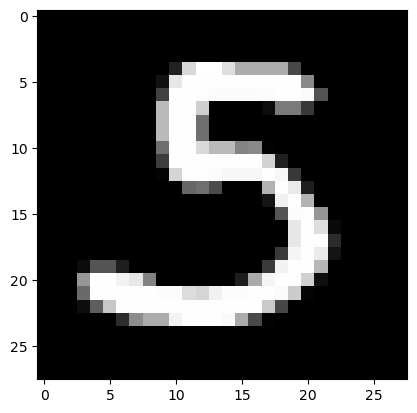

5862


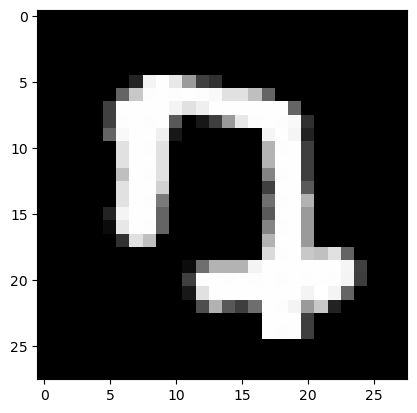

5887


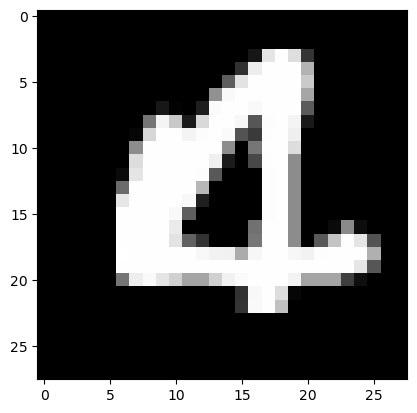

5888


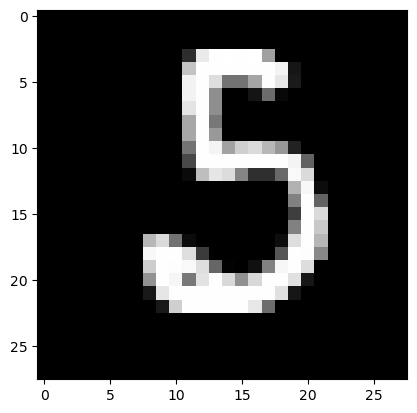

5891


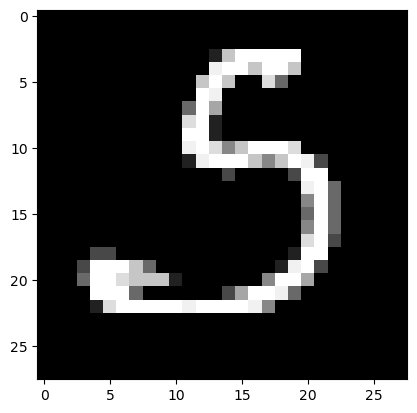

5913


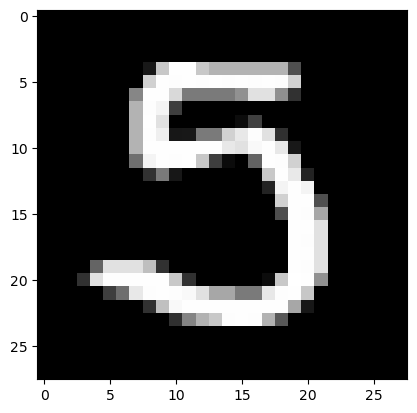

5922


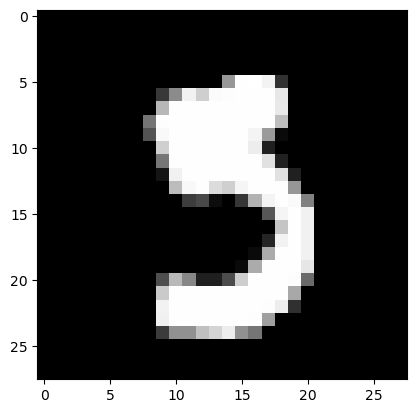

5937


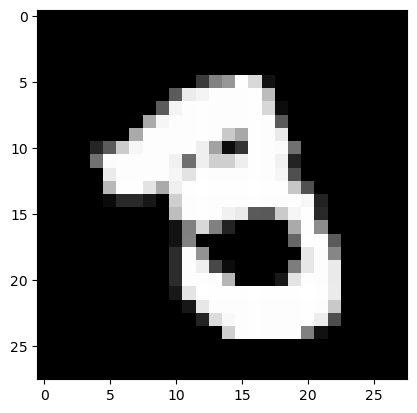

5955


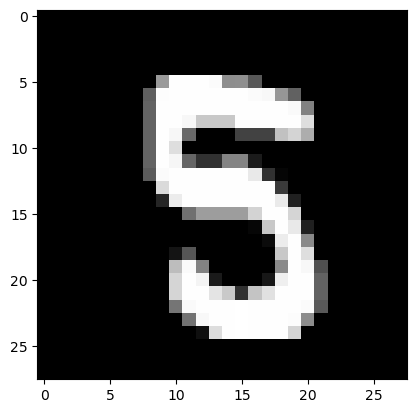

5957


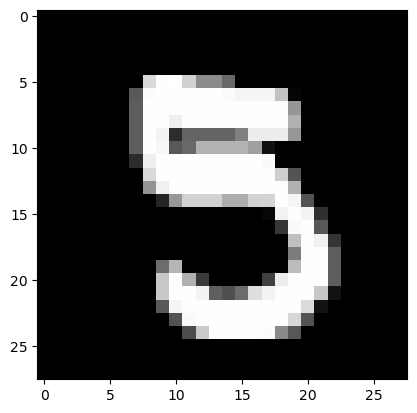

5972


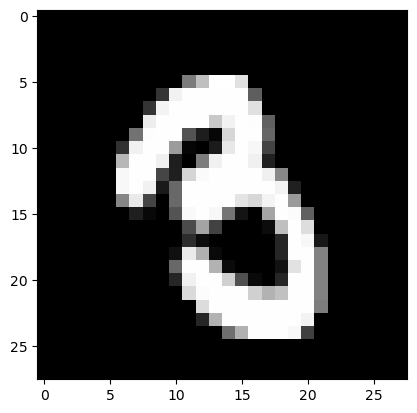

5973


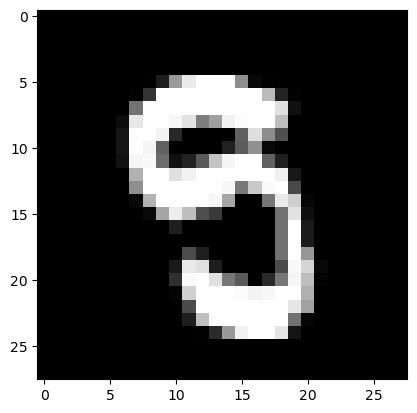

5997


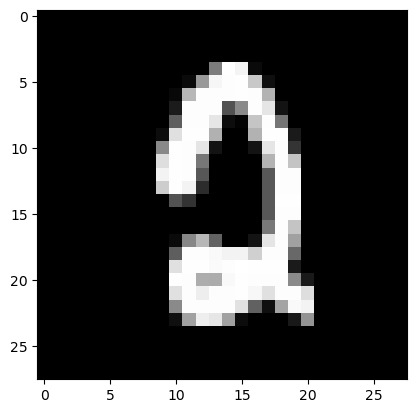

6035


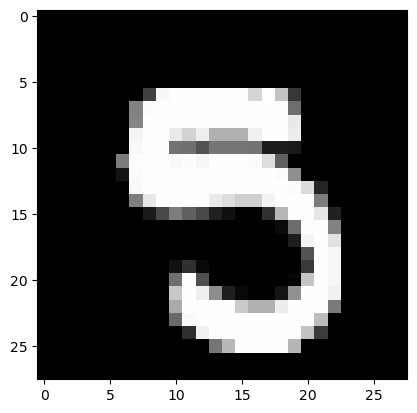

6053


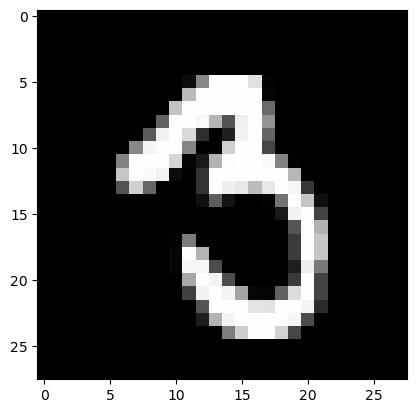

6059


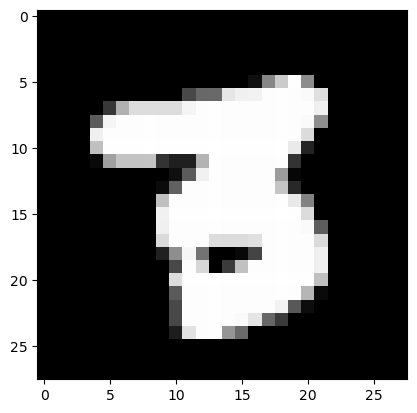

6065


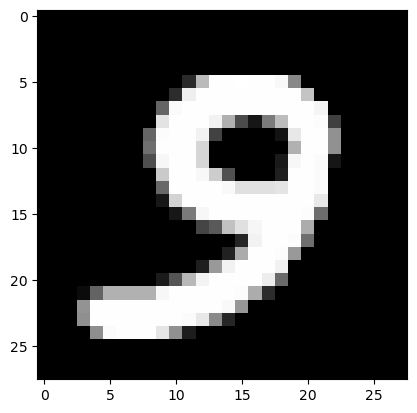

6071


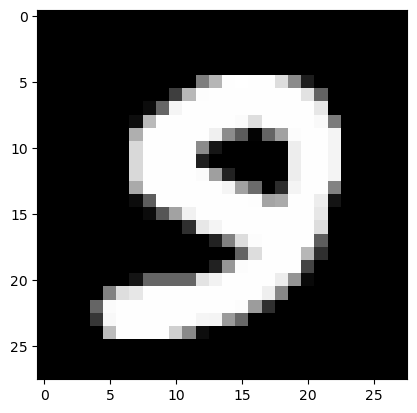

6081


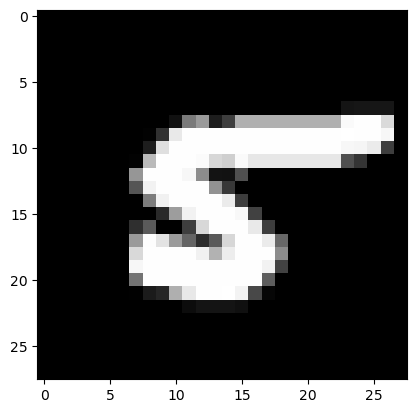

6087


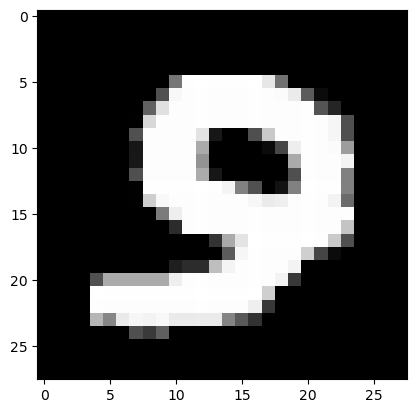

6091


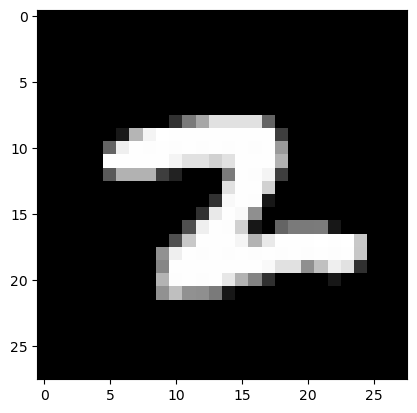

6109


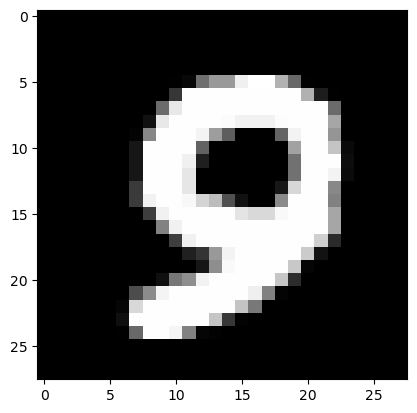

6157


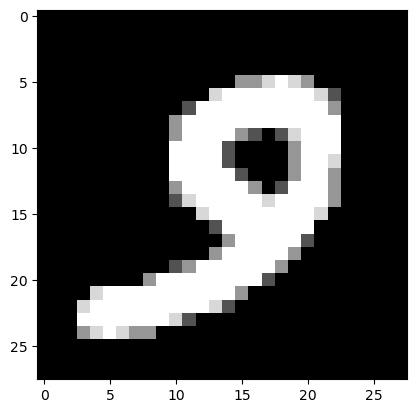

6166


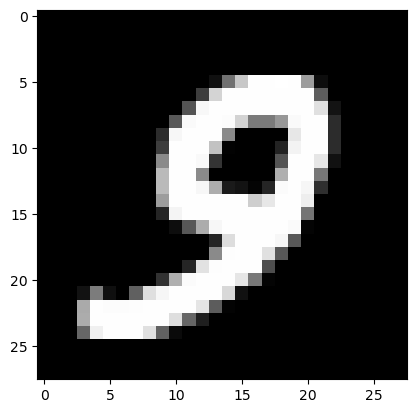

6168


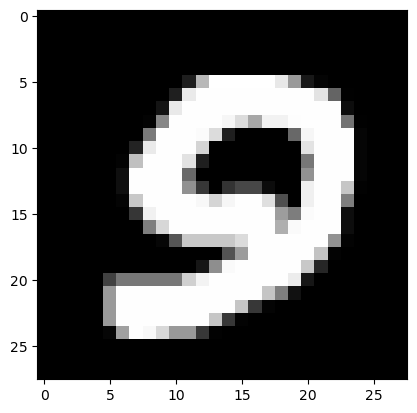

6172


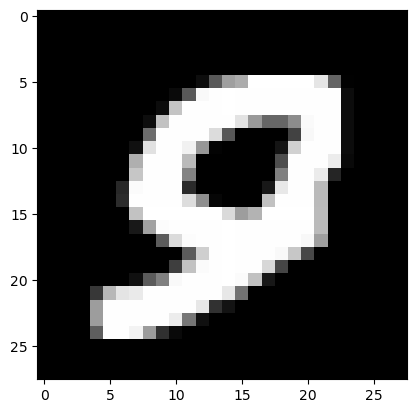

6173


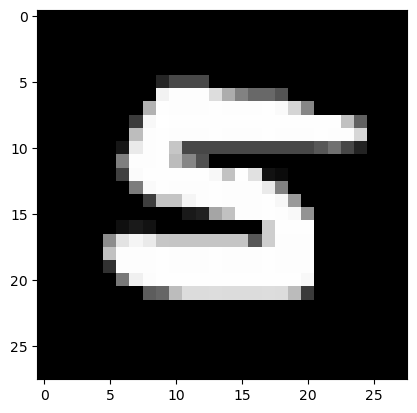

6390


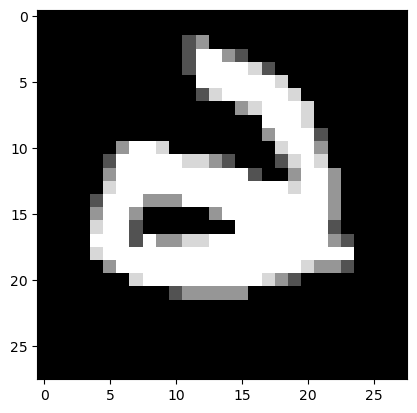

6391


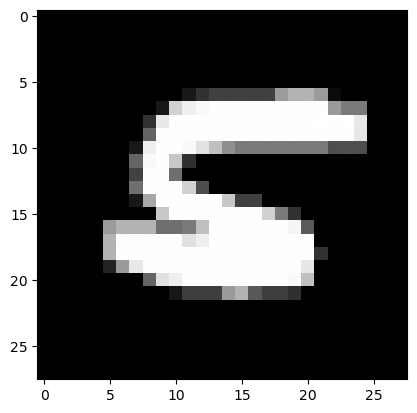

6392


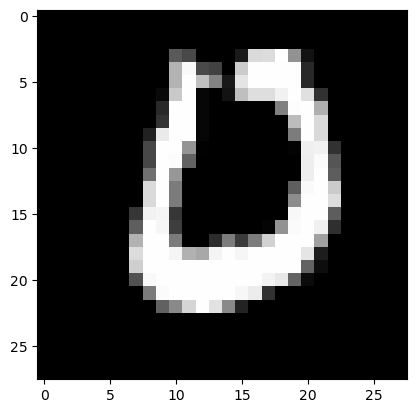

6426


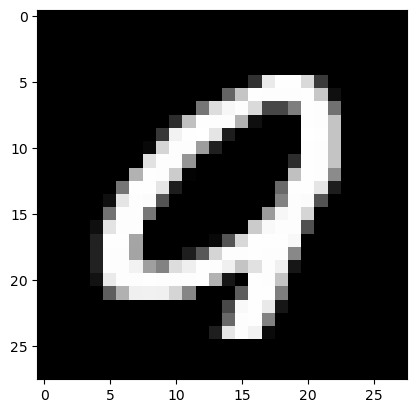

6505


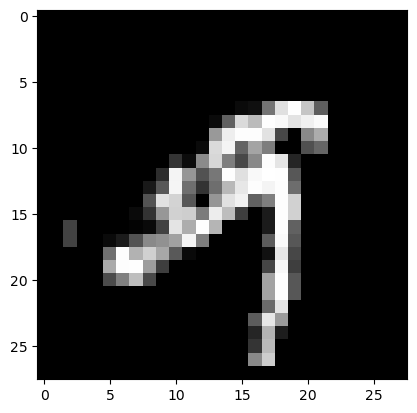

6560


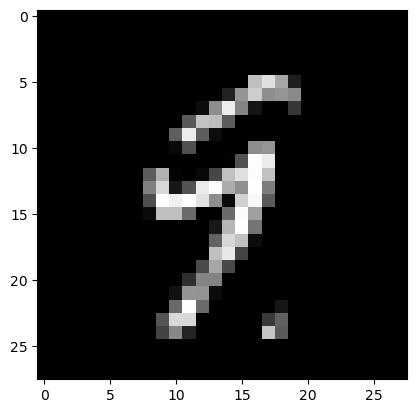

6568


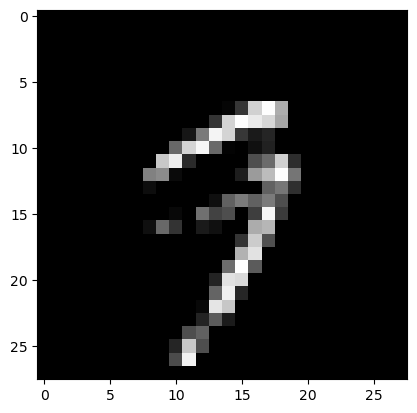

6571


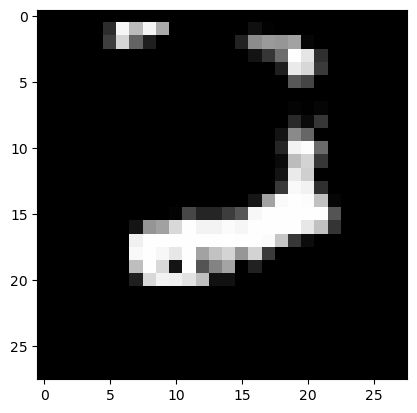

6574


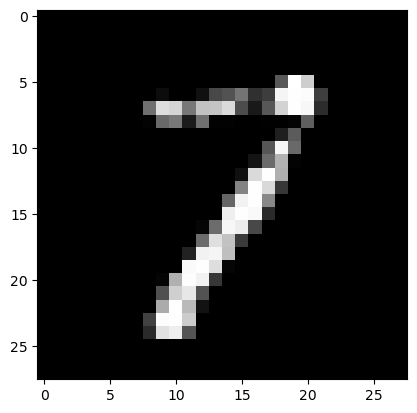

6577


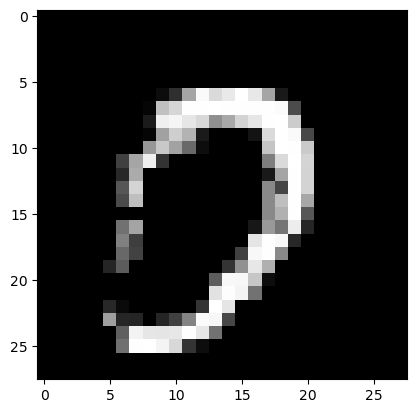

6597


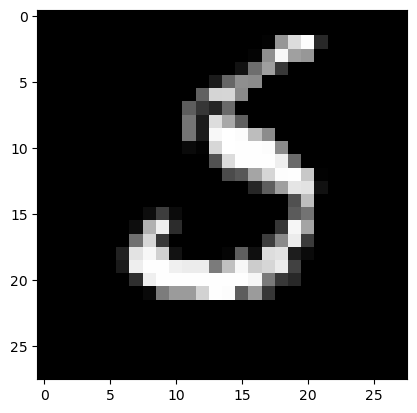

6598


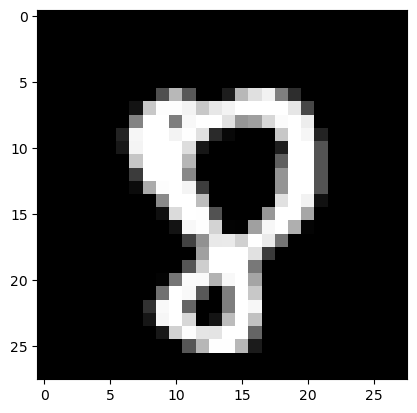

6603


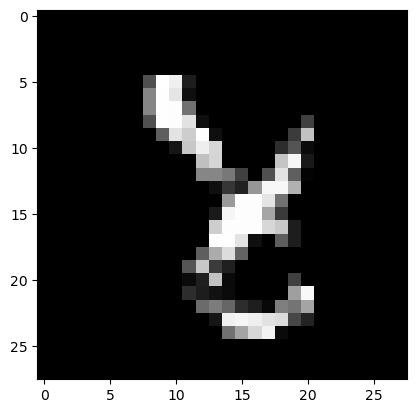

6625


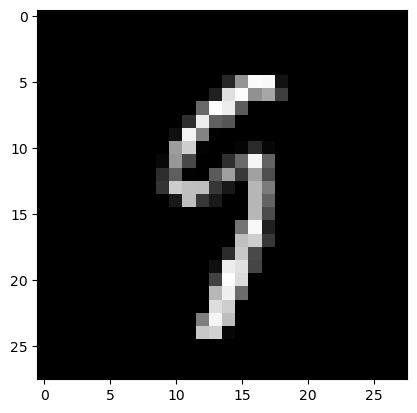

6632


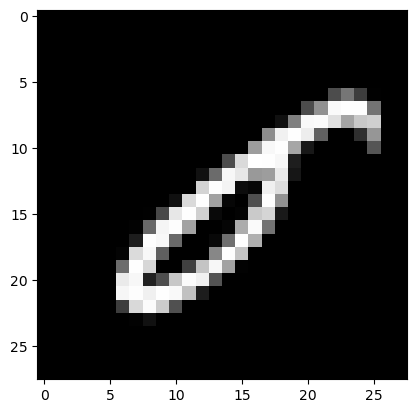

6651


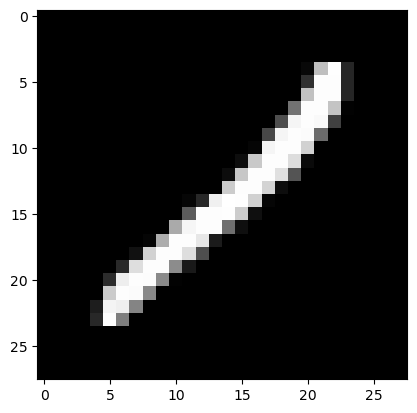

6694


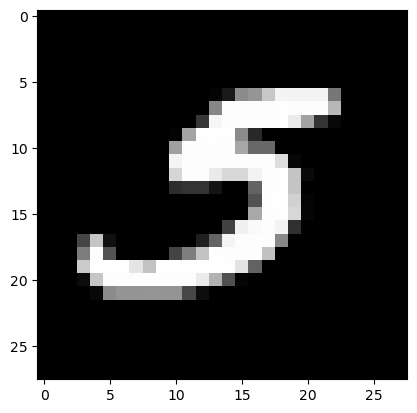

6706


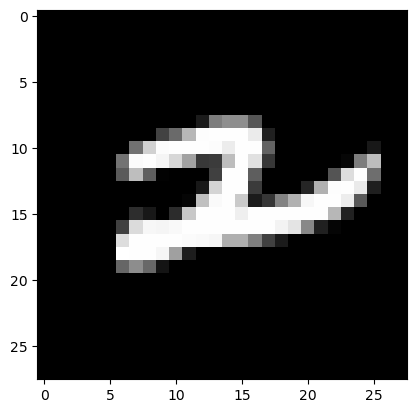

6721


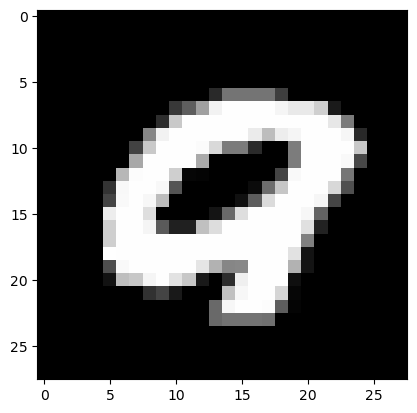

6740


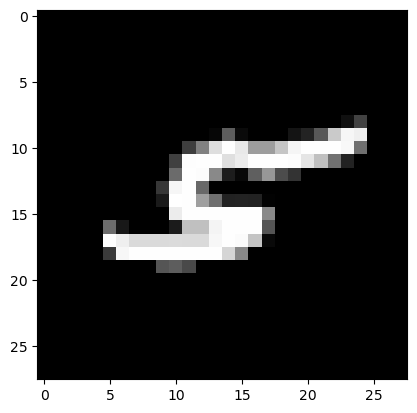

6746


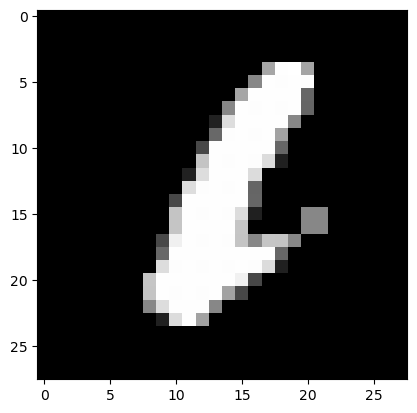

6783


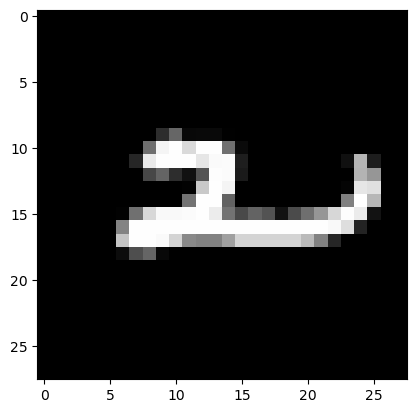

6785


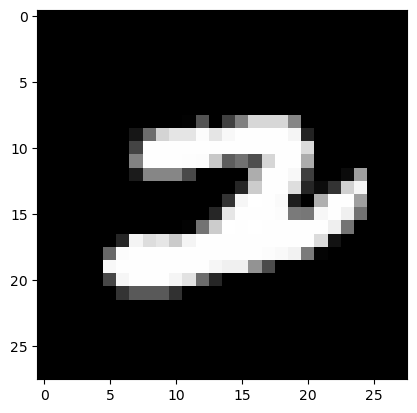

6796


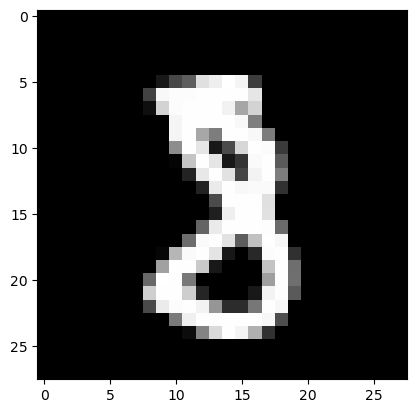

6806


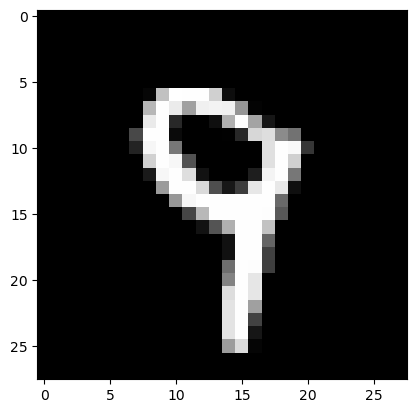

6817


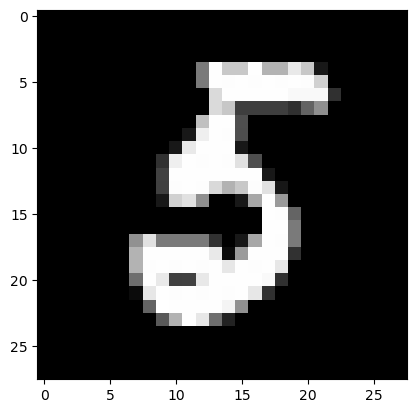

6981


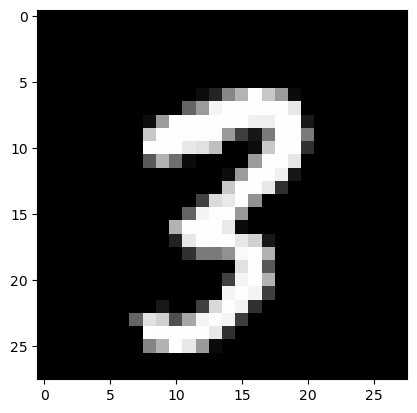

7130


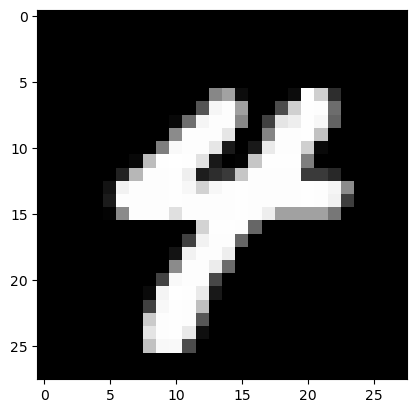

7153


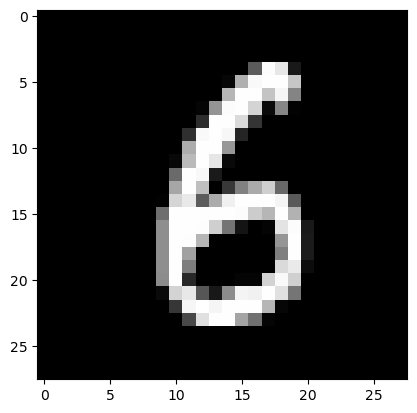

7210


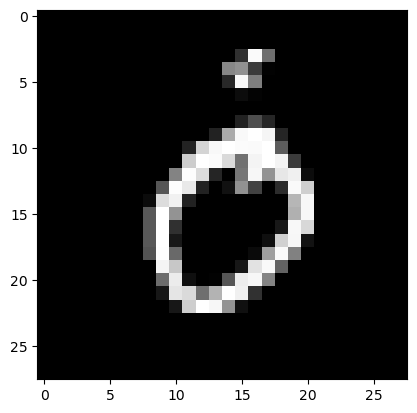

7216


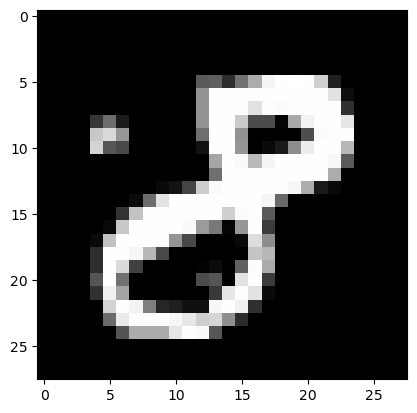

7265


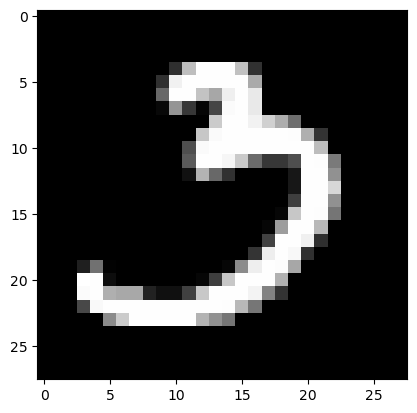

7401


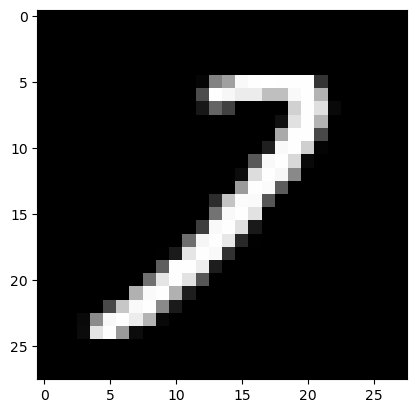

7432


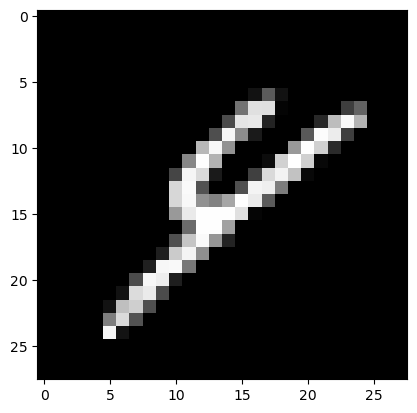

7434


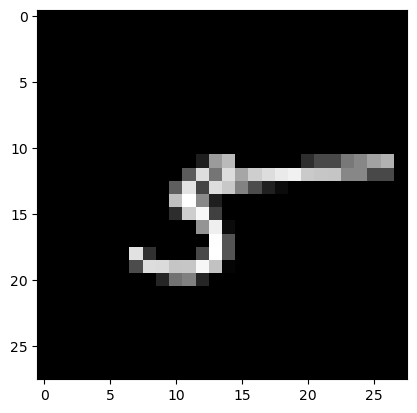

7451


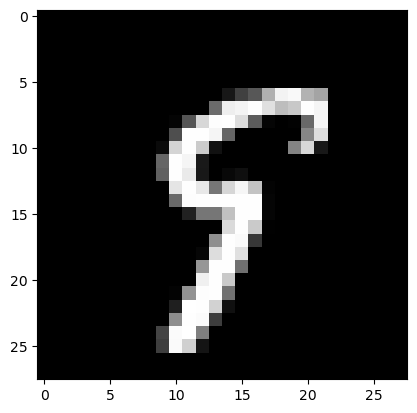

7459


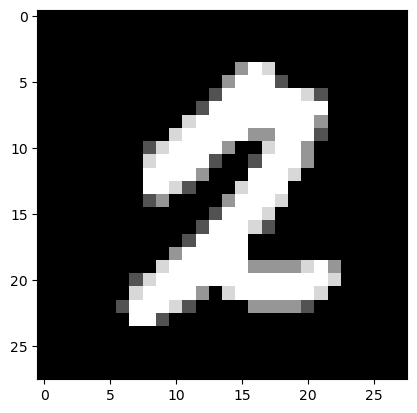

7539


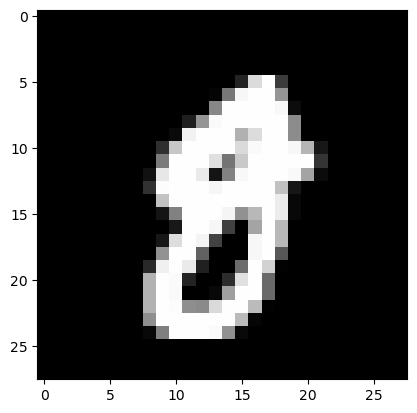

7552


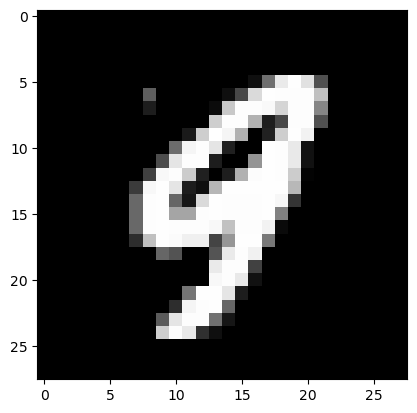

7579


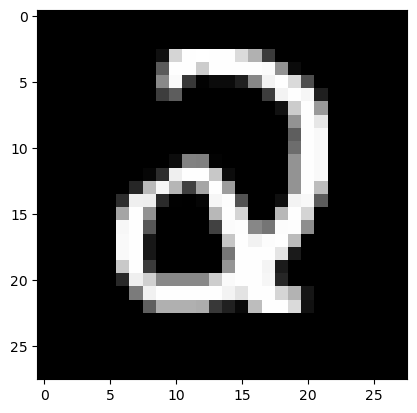

7724


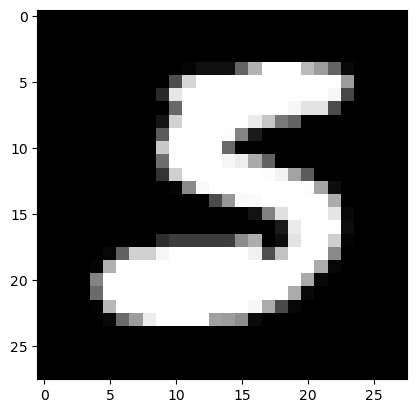

7777


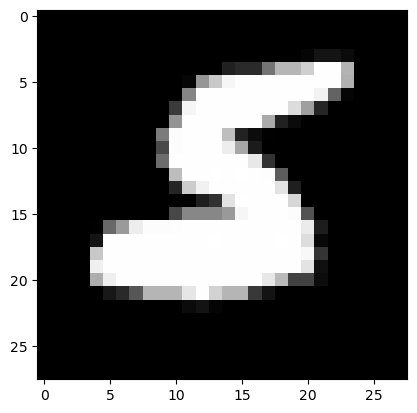

7797


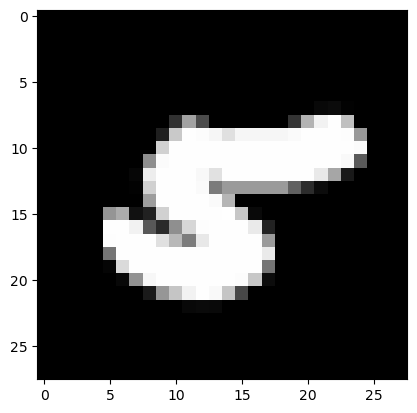

7842


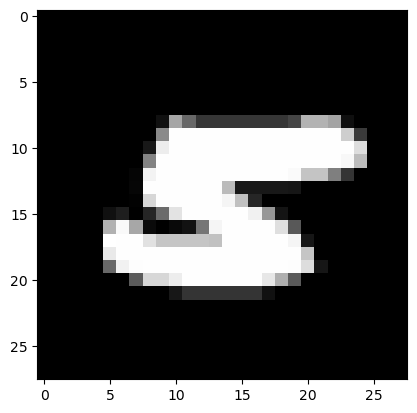

7850


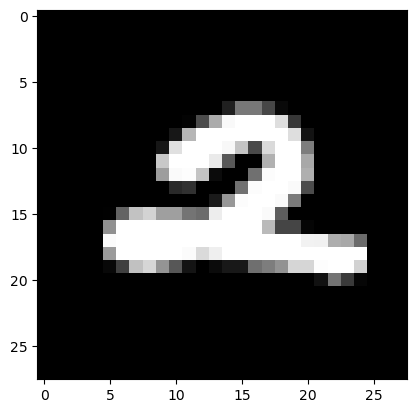

7876


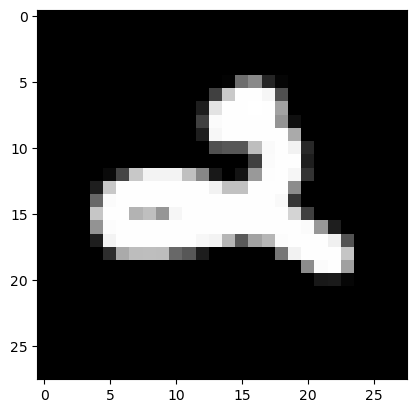

7886


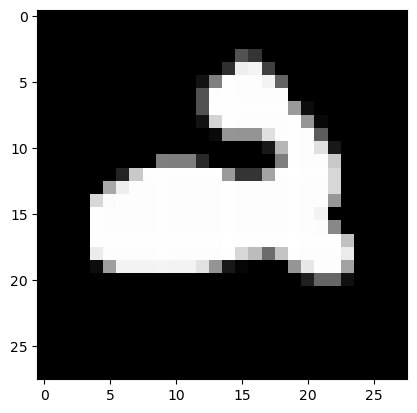

7917


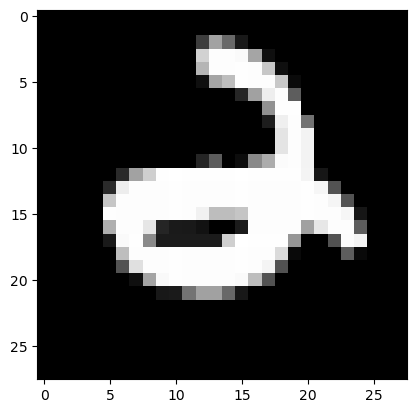

7945


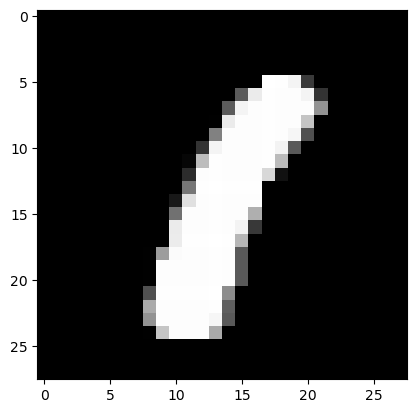

7990


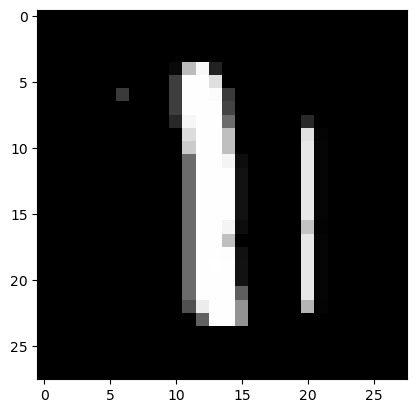

8020


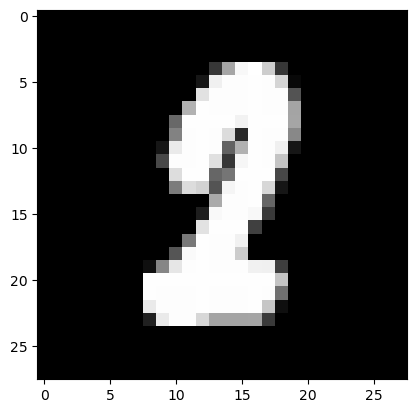

8094


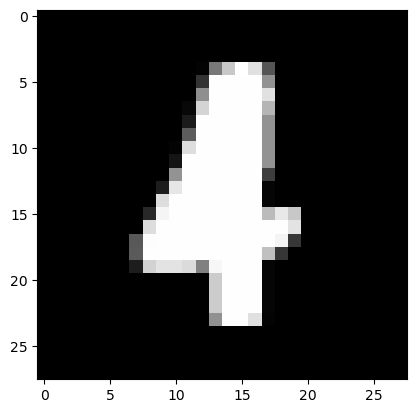

8095


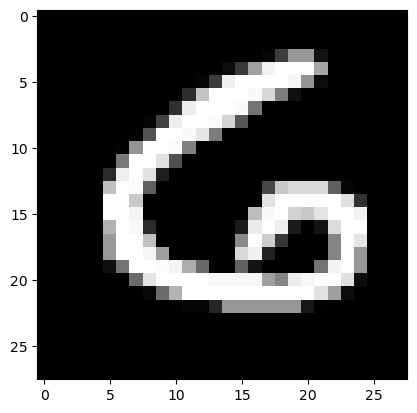

8196


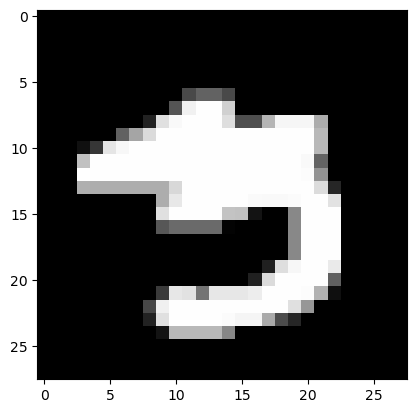

8246


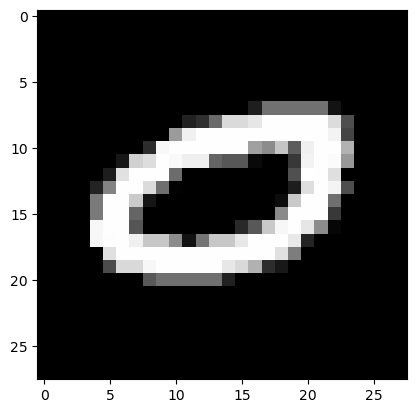

8273


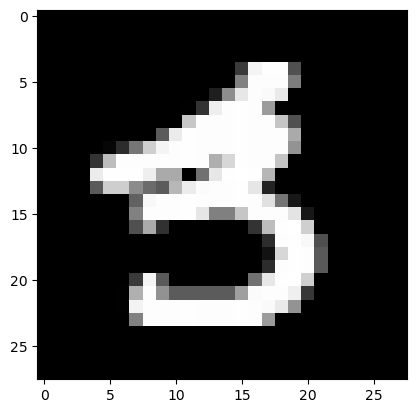

8277


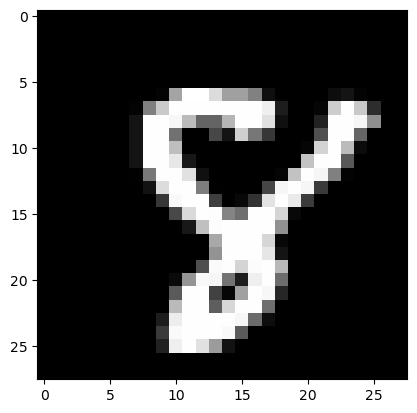

8294


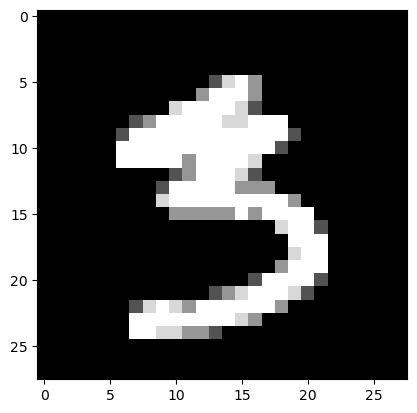

8308


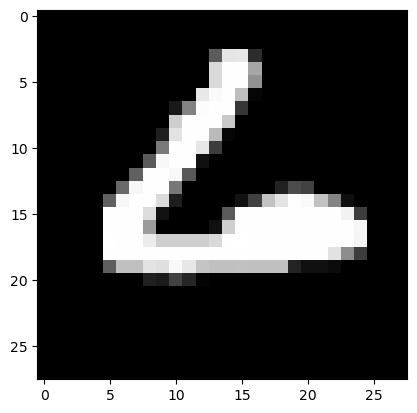

8311


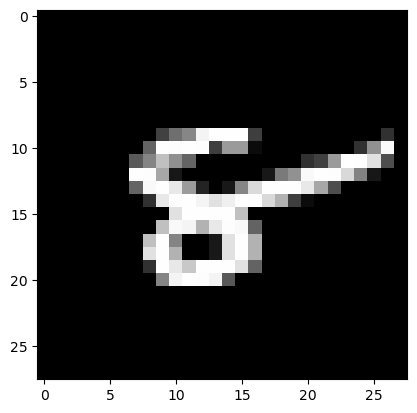

8339


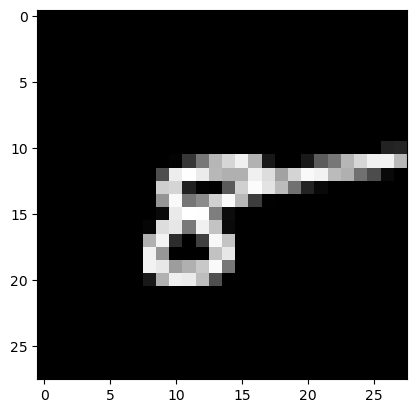

8408


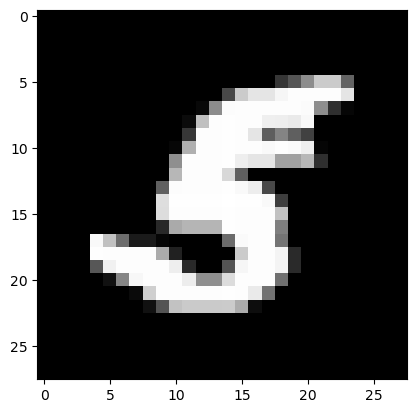

8453


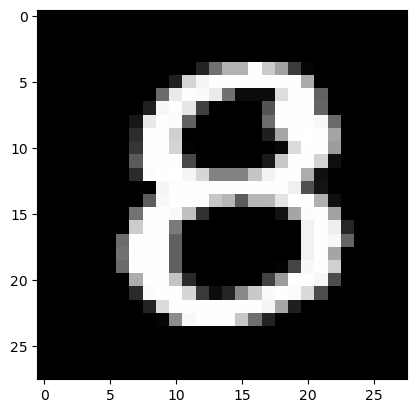

8456


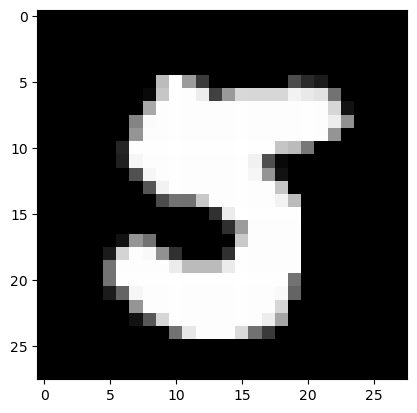

8502


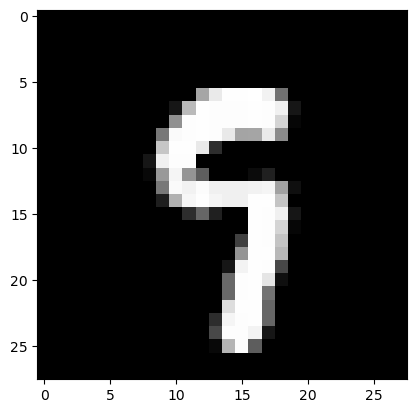

8504


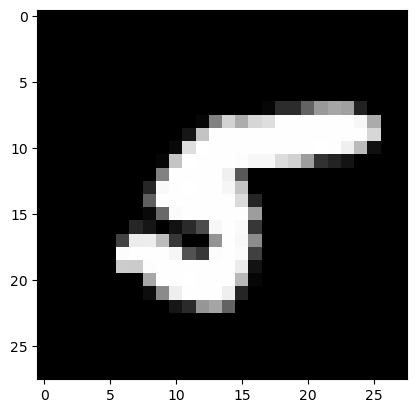

8507


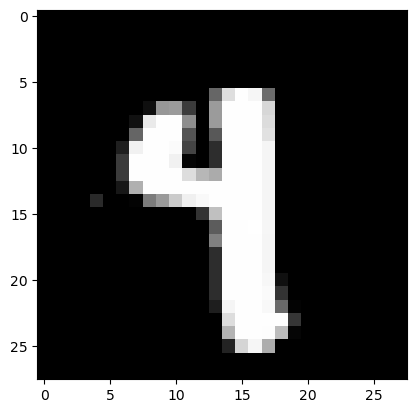

8520


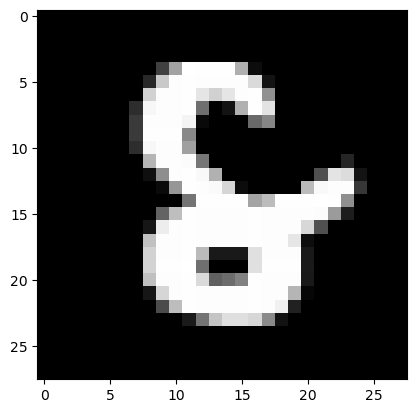

8522


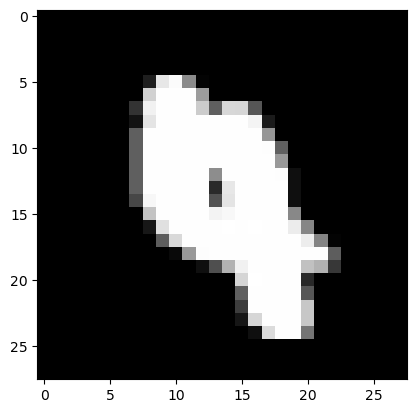

8527


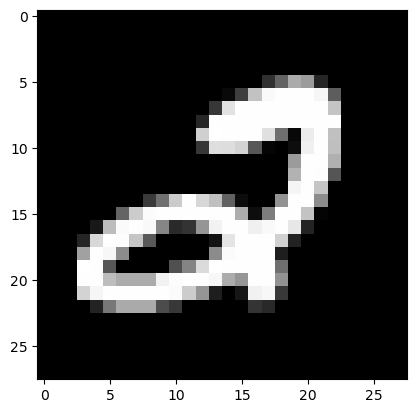

8889


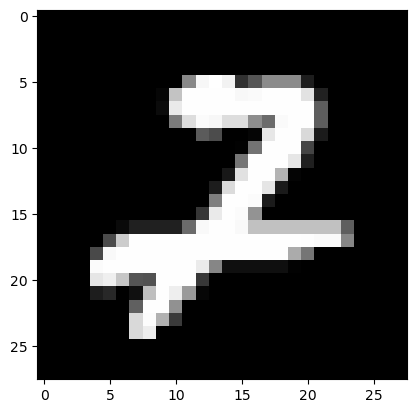

9009


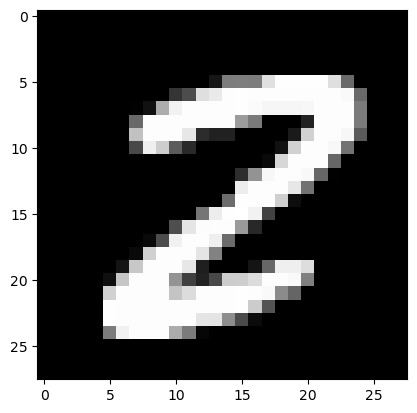

9010


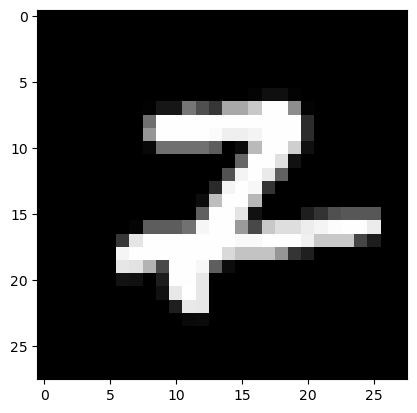

9015


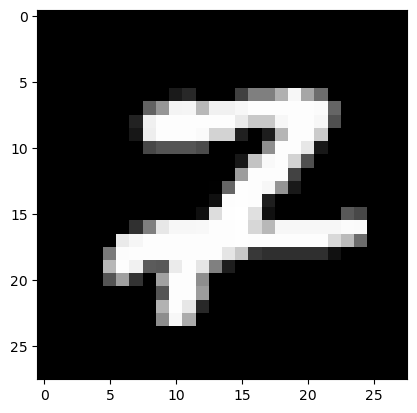

9019


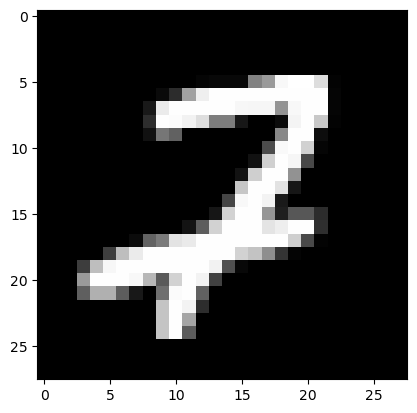

9024


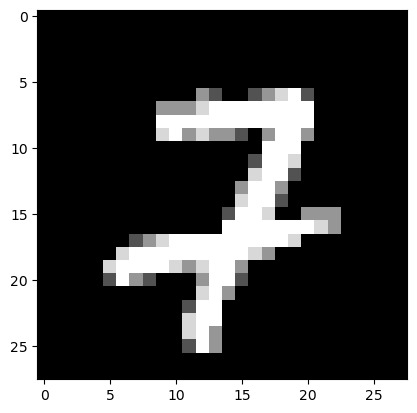

9031


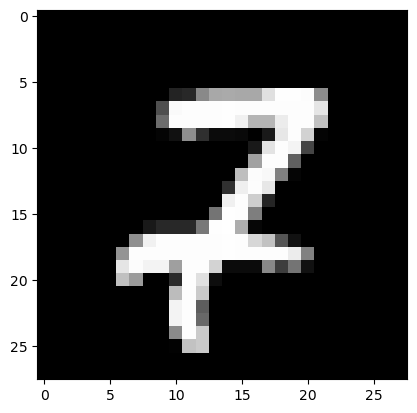

9036


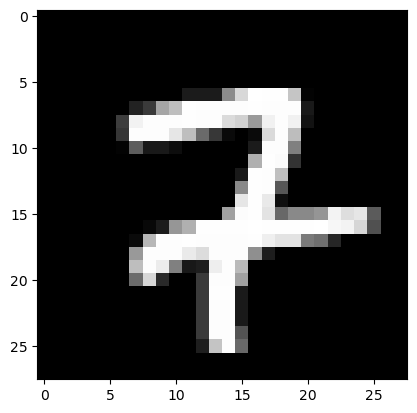

9044


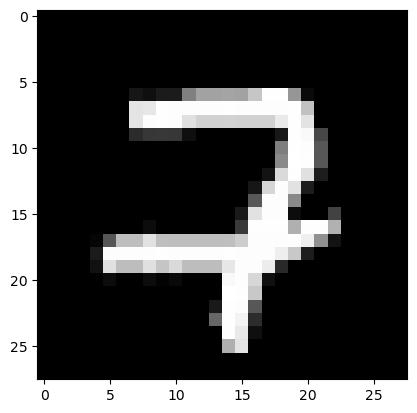

9045


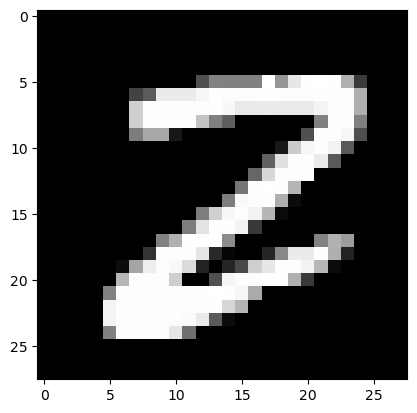

9046


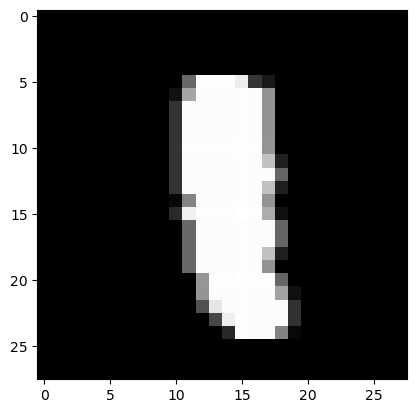

9071


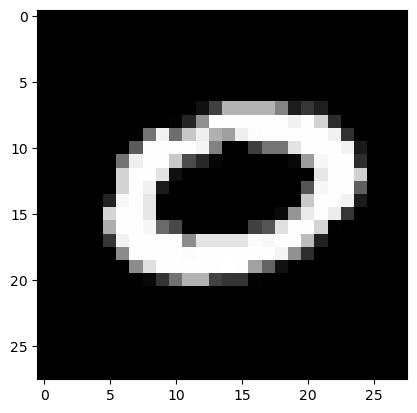

9158


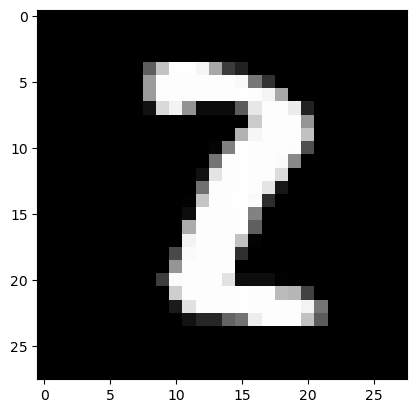

9168


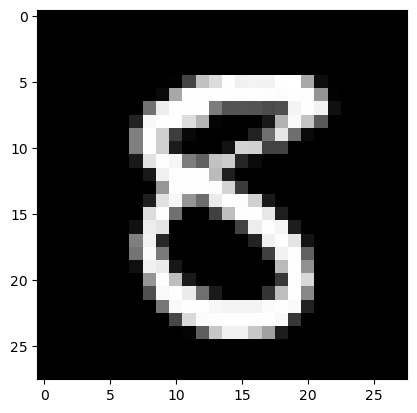

9280


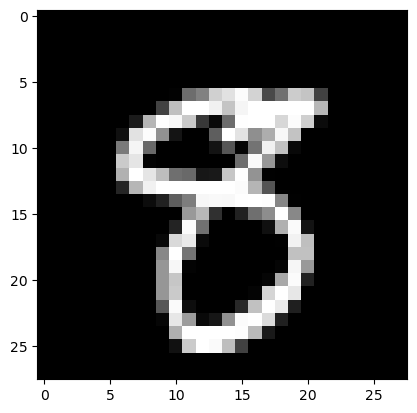

9316


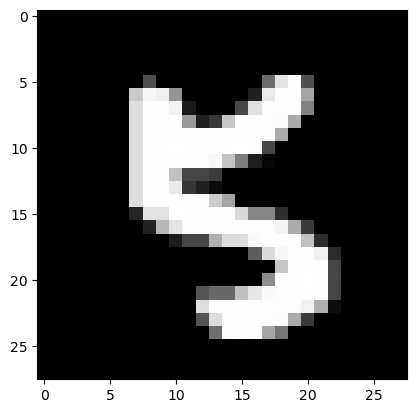

9382


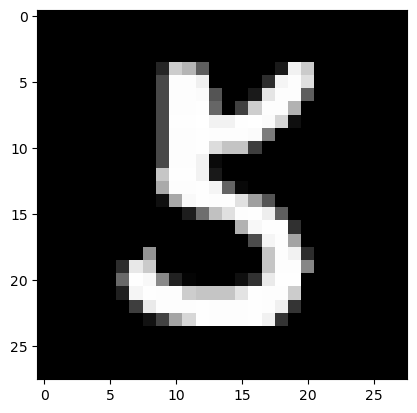

9400


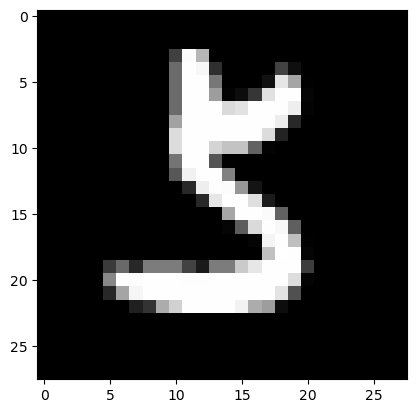

9422


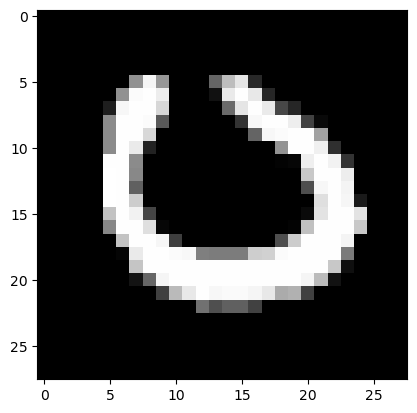

9425


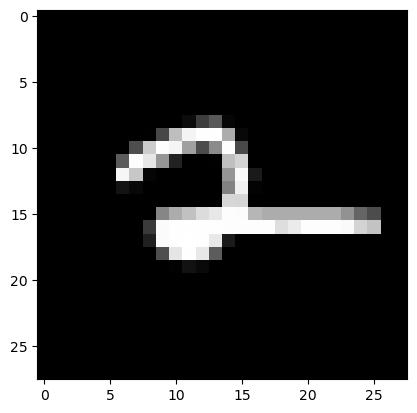

9446


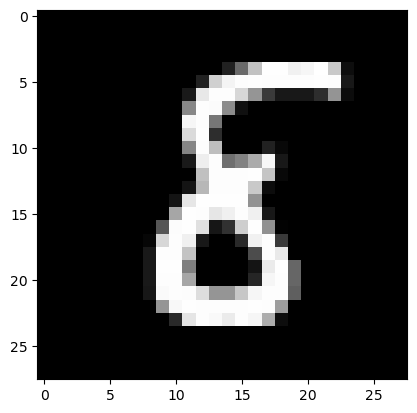

9450


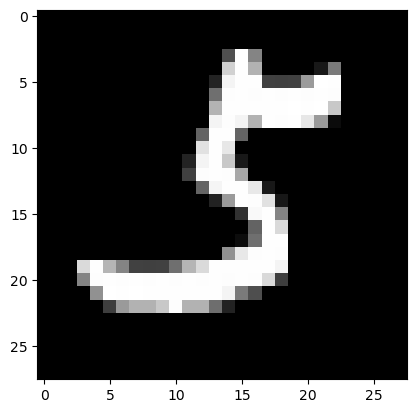

9465


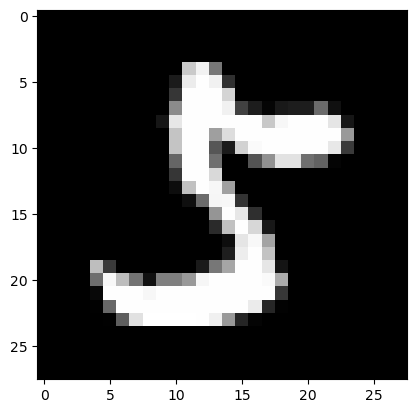

9482


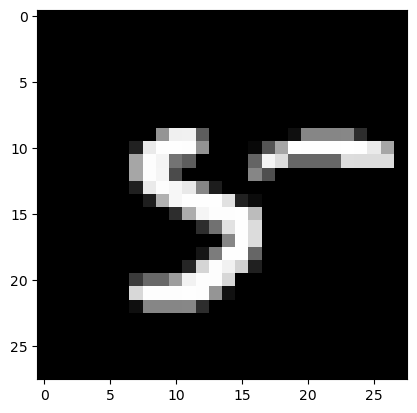

9513


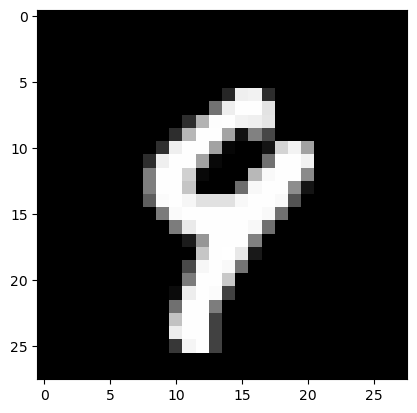

9517


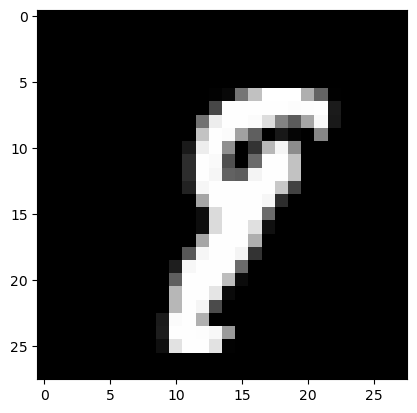

9530


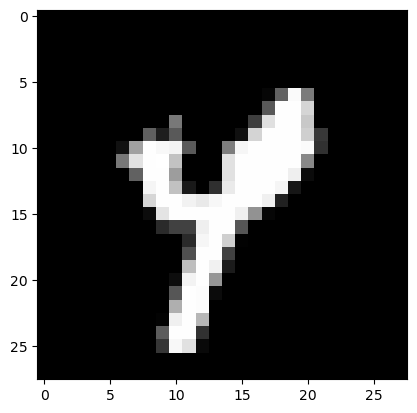

9538


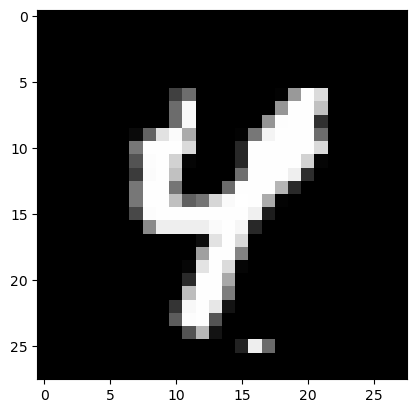

9541


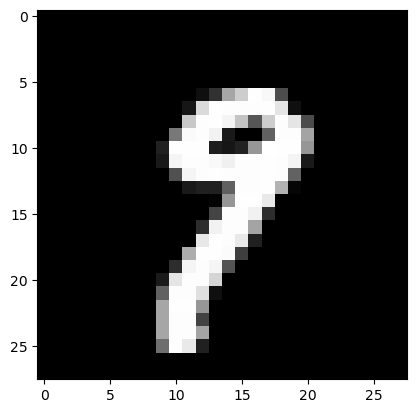

9554


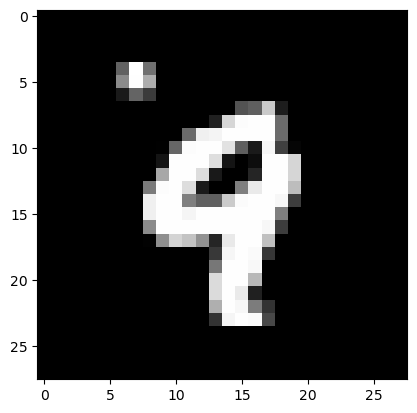

9587


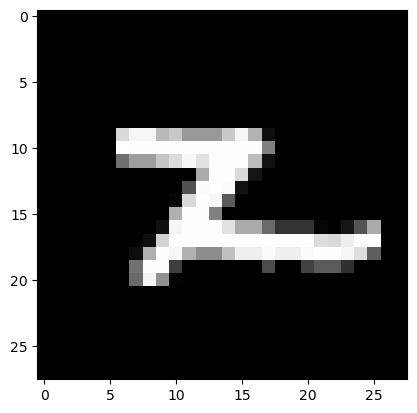

9595


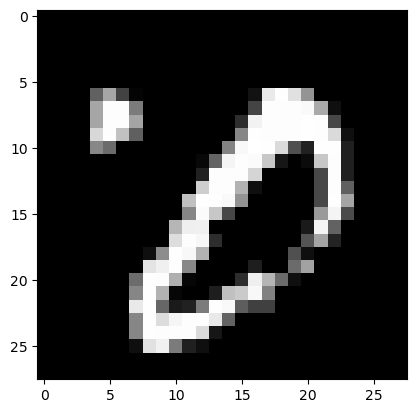

9634


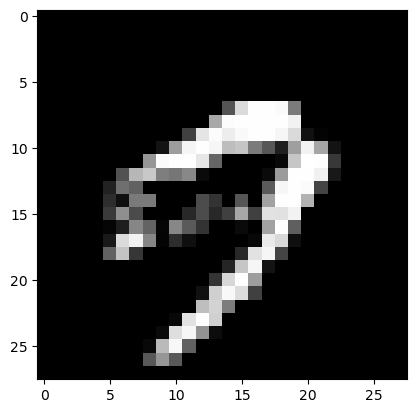

9642


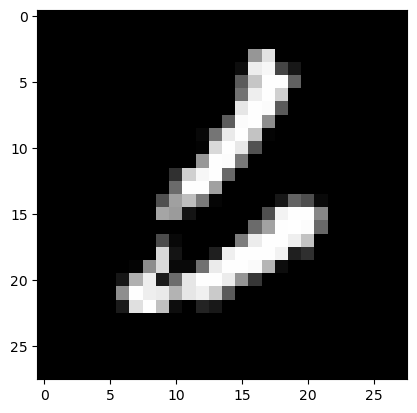

9679


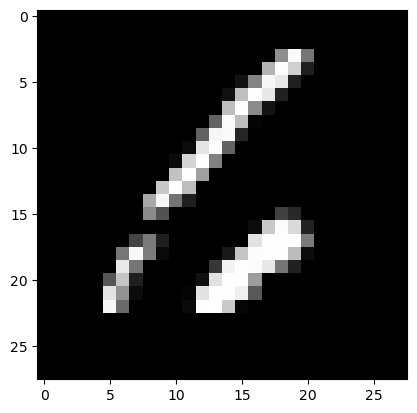

9698


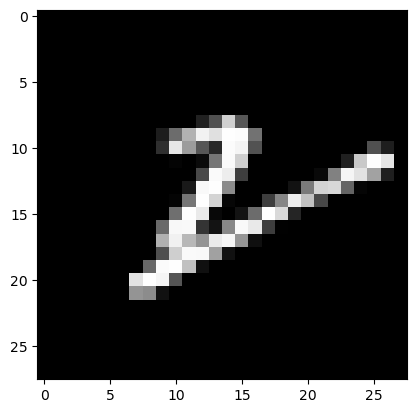

9700


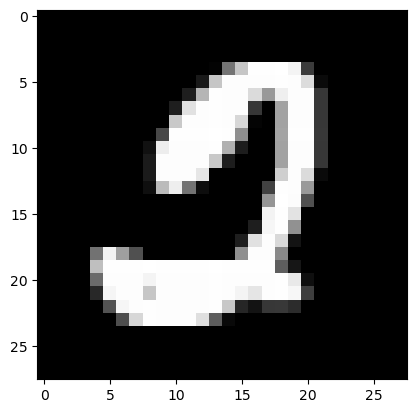

9716


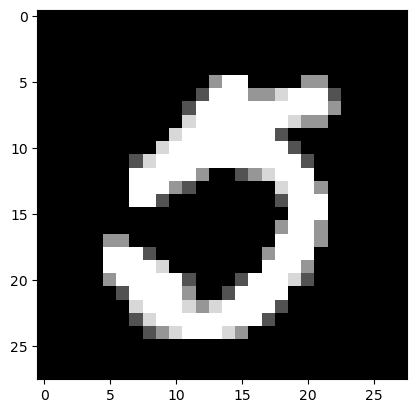

9719


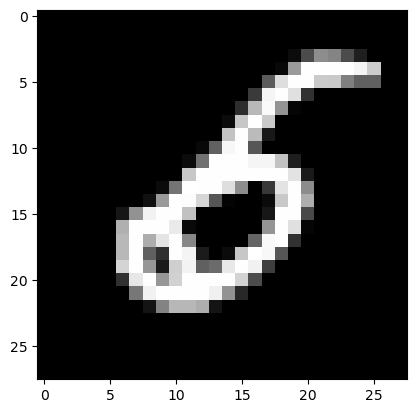

9729


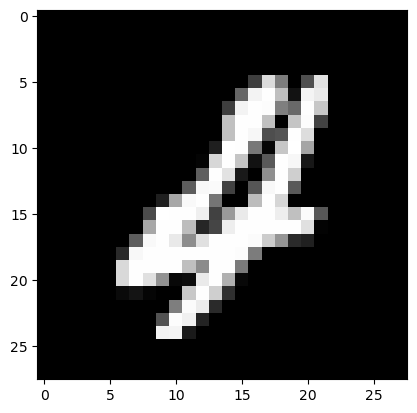

9745


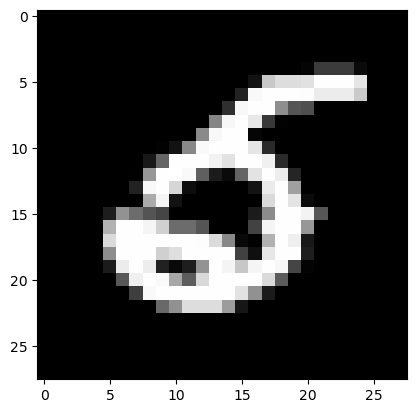

9749


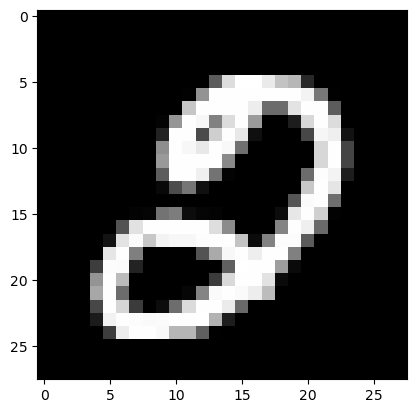

9768


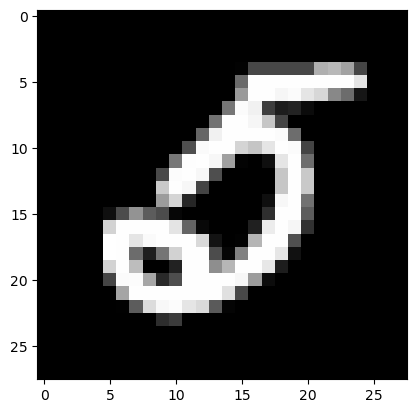

9770


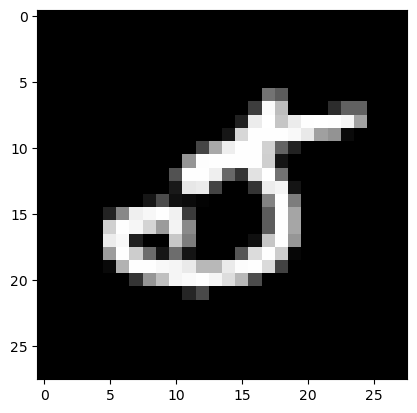

9777


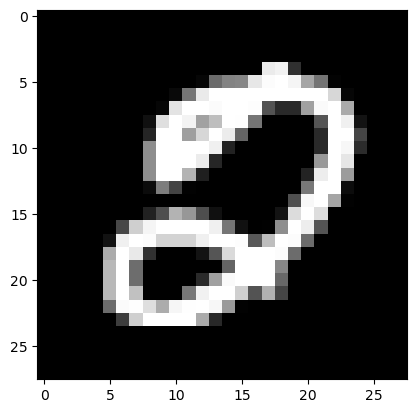

9779


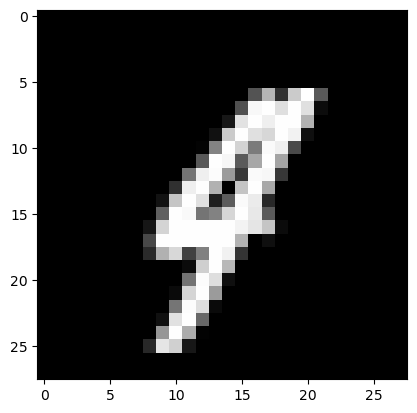

9792


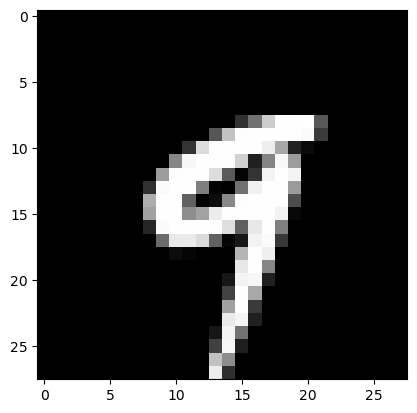

9808


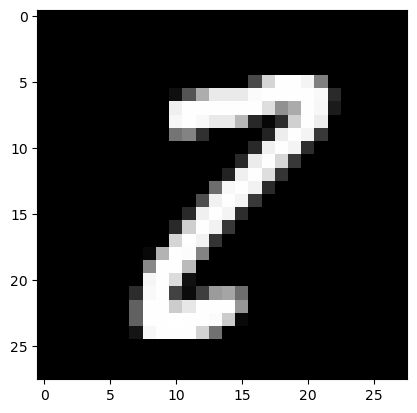

9811


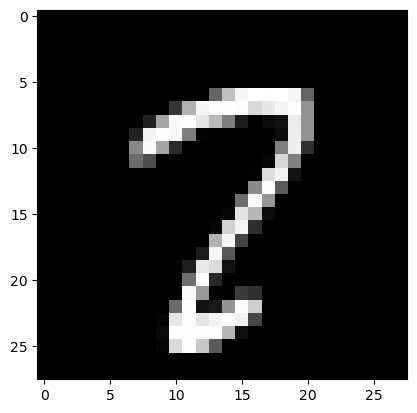

9839


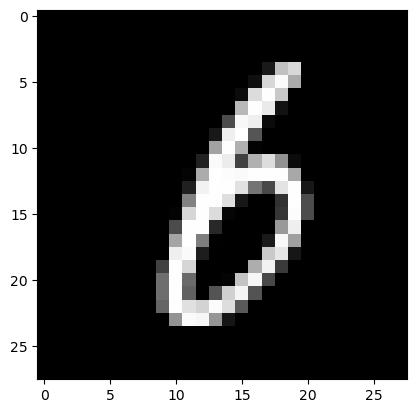

9858


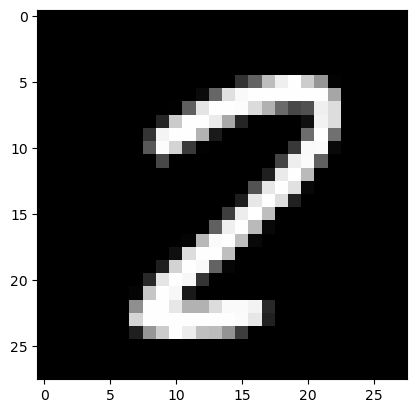

9867


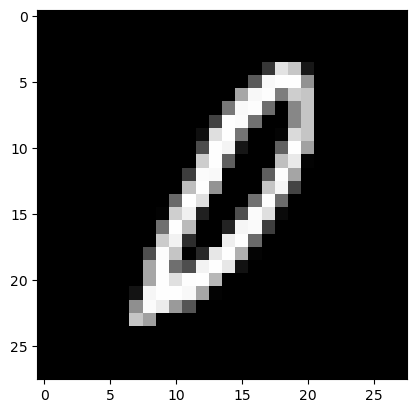

9879


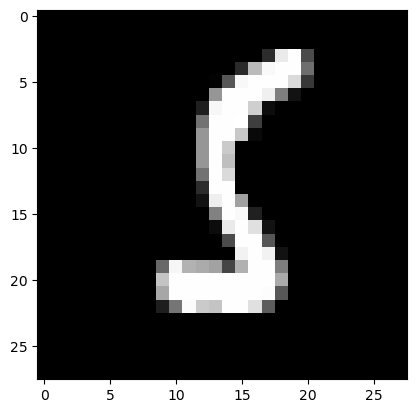

9883


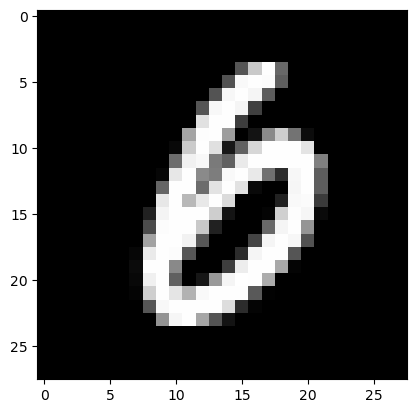

9888


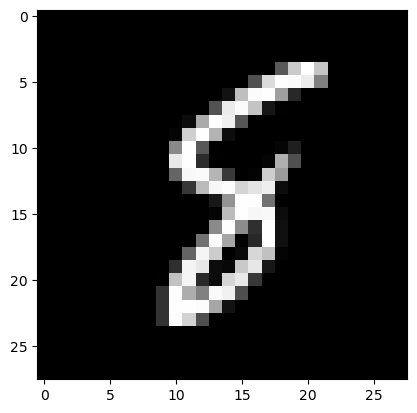

9892


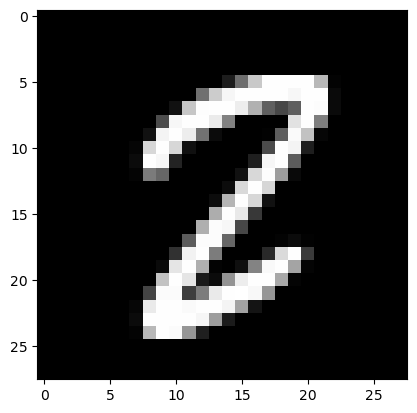

9893


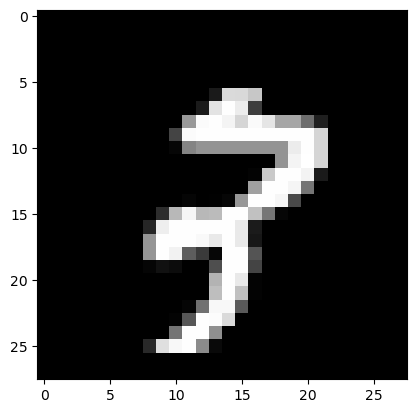

9905


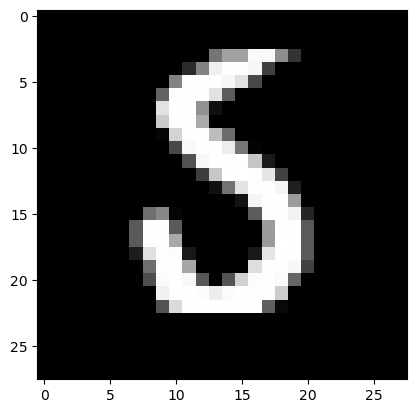

9941


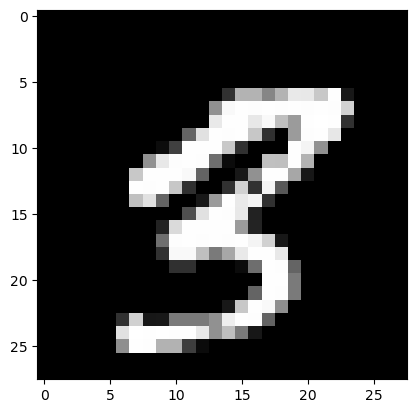

9944


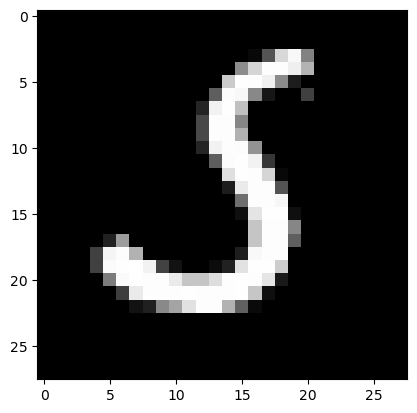

9970


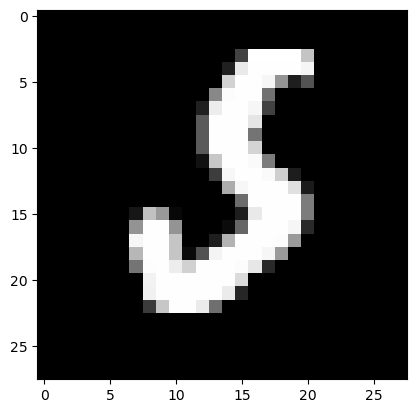

9982


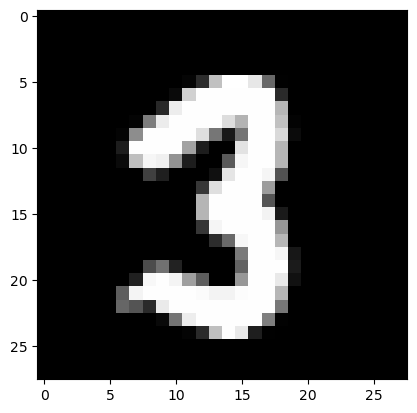

9986


In [88]:
###display the image of wrongly classified answer
import matplotlib.cm as cm
import matplotlib.pyplot as plt

test_x,test_y = test_data
counter = 0
for z in wronglist:
    plt.imshow(test_x[z].reshape((28, 28)), cmap=cm.Greys_r)
    plt.show()
    print(counter)
    counter = counter + 1